In [2]:
# coding=utf8

import os
import json
import statistics
from pprint import pprint
from typing import List, Dict
import numpy as np
from sql_parser import parse_sql, execute_sql, tokenize_sql
from sql_diff import induce_sql_diff, ExecutionException, ParseException
from sql_hardness import eval_hardness, eval_hardness_by_from

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
sparc_data_path = os.path.join('..', 'data', 'sparc.json')
refined_sparc_data_path = os.path.join('..', 'data', 'refined_sparc.json')
translated_sparc_table_path = os.path.join('..', 'data', 'translated_sparc_tables.json')

In [4]:
def get_sparc_sqlite_db_path(database_id: str) -> str:
    sparc_db_path = os.path.join("..", "..", "AnnotationTool", "backend", "data", "translated_database")
    return os.path.join(sparc_db_path, "%s" % database_id, "%s.sqlite" % database_id)

In [44]:
dusql_data_path = os.path.join('..', 'data', 'dusql.json')
dusql_table_path = os.path.join('..', 'data', 'dusql_tables.json')

In [45]:
def get_dusql_sqlite_db_path(database_id: str) -> str:
    dusql_db_path = os.path.join("..", "..", "AnnotationTool", "backend", "data", "DuSQL", "database")
    return os.path.join(dusql_db_path, "%s.sqlite" % database_id)

In [6]:
def read_json_file(filename: str) -> List[Dict]:
    with open(filename, 'r') as f:
        return json.load(f)
    
def read_database(filename: str) -> Dict:
    tables = read_json_file(filename)
    database_dict = dict()
    for table in tables:
        database_dict[table['database_id']] = table
    return database_dict

In [7]:
sparc_without_refined_exampels = read_json_file(sparc_data_path)
sparc_examples = read_json_file(refined_sparc_data_path)
sparc_database_dict = read_database(translated_sparc_table_path)

In [8]:
dusql_examples = read_json_file(dusql_data_path)
dusql_database_dict = read_database(dusql_table_path)

In [9]:
def get_database_statistics(database_dict: Dict):
    print("Number of Databases: %d" % len(database_dict))

In [10]:
get_database_statistics(sparc_database_dict)

Number of Databases: 166


In [11]:
get_database_statistics(dusql_database_dict)

Number of Databases: 120


In [12]:
def examine_sparc_data(examples: List[Dict]):
    for example in examples[:10]:
        print(example['database_id'])
        print(example['example_id'])
        for turn in example['interaction']:
            print(turn['question'])
        print('==\n\n')

In [13]:
def get_turn_statistics(examples: List[Dict]):
    turns = list()
    for ex in examples:
        if len(ex['interaction']) == 0:
            continue
        turns.append(len(ex['interaction']))
    max_turns = max(turns)
    min_turns = min(turns)
    total = sum(turns)
    avg_turns = statistics.mean(turns)
    print("Number of Question Sequence: ", len(turns))
    print("Number of <Question, SQL> pairs: ", total)
    print("Max #Turn: ", max_turns)
    print("Min #Turn: ", min_turns)
    print("Avg #Turn: ", avg_turns)
    

def get_sql_statistics(examples: List[Dict]):
    sqls = set()
    for ex in examples:
        for turn in ex['interaction']:
            sqls.add(turn['sql'].strip().lower())
    print("Number of Distinct SQL Queries: ", len(sqls))
    
    
def get_question_statistics(examples: List[Dict]):
    questions = set()
    num_tokens = list()
    for ex in examples:
        for turn in ex['interaction']:
            questions.add(turn['question'].strip().lower())
            # Number of tokens
            num_tokens.append(len(turn['tokenized_question']))
    print("Avg Tokens: ", statistics.mean(num_tokens))
    print("Number of Distinct Question: ", len(questions))
    
    
def get_updated_sql(examples: List[Dict], original_examples: List[Dict]):
    updated_count = 0
    for ex in examples:
        for oe in original_examples:
            if oe['example_id'] == ex['example_id']:
                break
        else:
            continue
        assert ex['example_id'] == oe['example_id'] and len(ex['interaction']) == len(oe['interaction'])
        for turn1, turn2 in zip(ex['interaction'], oe['interaction']):
            if turn1['sql'].strip().lower() != turn2['sql'].strip().lower():
                updated_count += 1
    print("Number of Updated SQL: ", updated_count)


def get_updated_question(examples: List[Dict], original_examples: List[Dict]):
    updated_count = 0
    for ex in examples:
        for oe in original_examples:
            if oe['example_id'] == ex['example_id']:
                break
        else:
            continue
        assert ex['example_id'] == oe['example_id'] and len(ex['interaction']) == len(oe['interaction'])
        for turn1, turn2 in zip(ex['interaction'], oe['interaction']):
            if turn1['question'].strip().lower() != turn2['question'].strip().lower():
                updated_count += 1
    print("Number of Updated Question: ", updated_count)
    

def get_empty_example(examples: List[Dict]):
    for ex in examples:
        if len(ex['interaction']) == 0:
            print(ex['example_id'])

In [14]:
get_empty_example(sparc_examples)

ex_494
ex_493
ex_461
ex_850


In [15]:
get_turn_statistics(sparc_examples)

Number of Question Sequence:  3452
Number of <Question, SQL> pairs:  10228
Max #Turn:  6
Min #Turn:  1
Avg #Turn:  2.962920046349942


In [16]:
get_turn_statistics(sparc_without_refined_exampels)

Number of Question Sequence:  3452
Number of <Question, SQL> pairs:  10228
Max #Turn:  6
Min #Turn:  1
Avg #Turn:  2.962920046349942


In [17]:
get_sql_statistics(sparc_examples)
get_sql_statistics(sparc_without_refined_exampels)

Number of Distinct SQL Queries:  8825
Number of Distinct SQL Queries:  8677


In [18]:
get_question_statistics(sparc_examples)
get_question_statistics(sparc_without_refined_exampels)

Avg Tokens:  12.066093077825577
Number of Distinct Question:  9434
Avg Tokens:  12.078509972624168
Number of Distinct Question:  9362


In [19]:
get_updated_sql(sparc_examples, sparc_without_refined_exampels)
get_updated_question(sparc_examples, sparc_without_refined_exampels)

Number of Updated SQL:  1412
Number of Updated Question:  1194


In [21]:
# Test
sql = 'select T1.省花, T1.省树 from 省份 AS T1 JOIN 城市 AS T2 ON T1.省份id = T2.所属省id where T2.名称 = (select 名称 from 城市 order by 人口 desc limit 1);'
db_id = "中国城市"
db = dusql_database_dict[db_id]
sql_dict = parse_sql(sql, db)
eval_hardness_by_from(sql_dict)

2

In [22]:
def get_hardness_statistics(examples: List[Dict], database_dict: Dict[str, Dict]):
    hardness_count = {"easy": 0, "medium": 0, "hard": 0, "extra": 0}
    except_count = 0
    invalid_db, example_ids = set(), dict()
    for ex in examples:
        if "example_id" not in ex:
            example_id = ex['_id']['$oid']
        else:
            example_id = ex['example_id']
        db_id = ex['database_id']
        db = database_dict[db_id]
        for turn in ex['interaction']:
            try:
                sql_dict = parse_sql(turn['sql'], db)
            except Exception as e:
                print(db_id, example_id, e)
                invalid_db.add(db_id)
                except_count += 1
                if db_id not in example_ids:
                    example_ids[db_id] = list()
                example_ids[db_id].append(example_id)
                continue
            h = eval_hardness(sql_dict)
            hardness_count[h] += 1
    pprint(hardness_count)
    print("Exception Count: ", except_count)
    print(invalid_db)
    pprint(example_ids)
    return hardness_count


def get_hardness_by_turn_statistics(examples: List[Dict], database_dict: Dict[str, Dict]):
    turn_hardness = [{"easy": 0, "medium": 0, "hard": 0, "extra": 0} for i in range(6)]
    for ex in examples:
        db_id = ex['database_id']
        db = database_dict[db_id]
        for tidx, turn in enumerate(ex['interaction']):
            try:
                sql_dict = parse_sql(turn['sql'], db)
            except Exception as e:
                continue
            h = eval_hardness(sql_dict)
            turn_hardness[tidx][h] += 1
    pprint(turn_hardness)
    return turn_hardness


def visualize_hardness_by_turn(turn_hardness, normalize: bool = True):
    labels = ['1', '2', '3', '4', '5', '6']
    if not normalize:
        easy = [turn['easy'] for turn in turn_hardness]
        medium = [turn['medium'] for turn in turn_hardness]
        hard = [turn['hard'] for turn in turn_hardness]
        extra = [turn['extra'] for turn in turn_hardness]
    else:
        turn_total = [sum([value for _, value in turn.items()]) for turn in turn_hardness]
        easy, medium, hard, extra = list(), list(), list(), list()
        for turn, tt in zip(turn_hardness, turn_total):
            easy.append(turn['easy'] / tt)
            medium.append(turn['medium'] / tt)
            hard.append(turn['hard'] / tt)
            extra.append(turn['extra'] / tt)
    
    x = np.array([i * 2.5 for i in range(len(labels))])  # the label locations
    width = 0.5   # the width of the bars
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - 3*width/2, easy, width, label='Easy')
    rects2 = ax.bar(x - width/2, medium, width, label='Medium')
    rects3 = ax.bar(x + width/2, hard, width, label='Hard')
    rects4 = ax.bar(x + 3*width/2, extra, width, label='Extra')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 0.8)
    ax.legend()


def get_hardness_by_from_statistics(examples: List[Dict], database_dict: Dict[str, Dict]):
    table_hardness_count = {}
    except_count = 0
    invalid_db = set()
    for ex in examples:
        if "example_id" not in ex:
            example_id = ex['_id']['$oid']
        else:
            example_id = ex['example_id']
        db_id = ex['database_id']
        db = database_dict[db_id]
        for turn in ex['interaction']:
            try:
                sql_dict = parse_sql(turn['sql'], db)
            except Exception as e:
                print(db_id, example_id, e)
                invalid_db.add(db_id)
                except_count += 1
                continue
            h = eval_hardness_by_from(sql_dict)
            if h not in table_hardness_count:
                table_hardness_count[h] = 0
            table_hardness_count[h] += 1
    pprint(table_hardness_count)
    print("Exception Count: ", except_count)
    print(invalid_db)
    return table_hardness_count


def get_sql_from_statistics(examples: List[Dict], database_dict: Dict[str, Dict]):
    table_nums = list()
    for ex in examples:
        db_id = ex['database_id']
        db = database_dict[db_id]
        for turn in ex['interaction']:
            try:
                sql_dict = parse_sql(turn['sql'], db)
            except Exception as e:
                continue
            h = eval_hardness_by_from(sql_dict)
            table_nums.append(h)
    print("Average number of tables in from: ", statistics.mean(table_nums))


def jaccard_index(tokens1: List, tokens2: List) -> float:
    token_set1 = set(tokens1)
    token_set2 = set(tokens2)
    return len(token_set1 & token_set2) / len(token_set1 | token_set2)
    

# More turn level statistics
def get_turn_sql_token_overlap(examples: List[Dict], database_dict: Dict[str, Dict]):
    results = [[[] for i in range(6)] for i in range(6)]
    for ex in examples:
        for tidx, turn1 in enumerate(ex['interaction']):
            turn1_tokens = tokenize_sql(turn1['sql'].strip().lower())
            for tjdx, turn2 in enumerate(ex['interaction'][:tidx]):
                if tidx == tjdx:
                    continue
                turn2_tokens = tokenize_sql(turn2['sql'].strip().lower())
                overlap_score = jaccard_index(turn1_tokens, turn2_tokens)
                results[tidx][tjdx].append(overlap_score)
    avg_results = [[0 for i in range(6)] for i in range(6)]
    for i in range(6):
        for j in range(6):
            if len(results[i][j]) > 0:
                avg_results[i][j] = statistics.mean(results[i][j])
    return avg_results

def visualize_overlap(overlap: List[List]):
    overlap_array = np.array(overlap)
    fig, ax = plt.subplots()
    im = ax.imshow(overlap_array, cmap="YlGn")

In [23]:
turn_token_overlap = get_turn_sql_token_overlap(sparc_examples, sparc_database_dict)
original_turn_token_overlap = get_turn_sql_token_overlap(sparc_without_refined_exampels, sparc_database_dict)

In [24]:
turn_token_overlap

[[0, 0, 0, 0, 0, 0],
 [0.5334092060788156, 0, 0, 0, 0, 0],
 [0.4024058313736809, 0.6652526470279844, 0, 0, 0, 0],
 [0.33648577026536947, 0.5361281564833372, 0.737495523378536, 0, 0, 0],
 [0.2725383392303576,
  0.4150979001260685,
  0.612571028118713,
  0.7473660482213278,
  0,
  0],
 [0.2998456510809452,
  0.3744943240454076,
  0.594989898989899,
  0.6753302253302254,
  0.7937619978061154,
  0]]

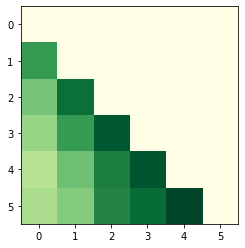

In [25]:
visualize_overlap(turn_token_overlap)

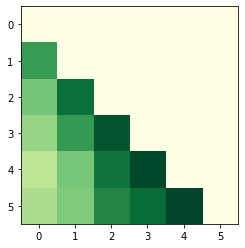

In [26]:
visualize_overlap(original_turn_token_overlap)

In [27]:
refined_sparc_turn_hardness = get_hardness_by_turn_statistics(sparc_examples, sparc_database_dict)

[{'easy': 2307, 'extra': 63, 'hard': 164, 'medium': 876},
 {'easy': 1057, 'extra': 271, 'hard': 508, 'medium': 1552},
 {'easy': 325, 'extra': 444, 'hard': 636, 'medium': 1037},
 {'easy': 54, 'extra': 183, 'hard': 206, 'medium': 281},
 {'easy': 3, 'extra': 17, 'hard': 16, 'medium': 14},
 {'easy': 0, 'extra': 2, 'hard': 2, 'medium': 1}]


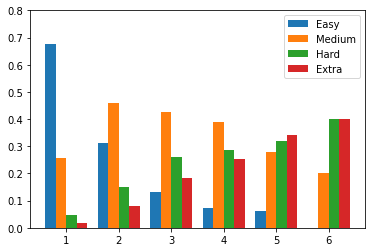

In [28]:
visualize_hardness_by_turn(refined_sparc_turn_hardness)

In [29]:
sparc_turn_hardness = get_hardness_by_turn_statistics(sparc_without_refined_exampels, sparc_database_dict)

[{'easy': 2477, 'extra': 44, 'hard': 143, 'medium': 765},
 {'easy': 1170, 'extra': 231, 'hard': 486, 'medium': 1530},
 {'easy': 338, 'extra': 410, 'hard': 639, 'medium': 1085},
 {'easy': 51, 'extra': 179, 'hard': 220, 'medium': 297},
 {'easy': 2, 'extra': 16, 'hard': 19, 'medium': 13},
 {'easy': 0, 'extra': 2, 'hard': 2, 'medium': 1}]


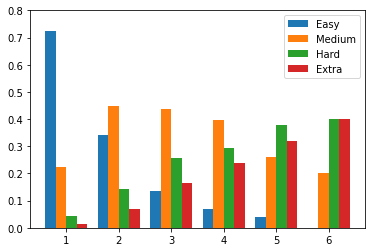

In [30]:
visualize_hardness_by_turn(sparc_turn_hardness)

In [31]:
refined_sparc_hardness_count = get_hardness_statistics(sparc_examples, sparc_database_dict)

flight_company ex_2387 '机场.iata'
phone_1 ex_1570 '芯片型号.wifi'
phone_1 ex_1570 '芯片型号.wifi'
phone_1 ex_1570 '芯片型号.wifi'
car_1 ex_183 '汽车制造商.id'
car_1 ex_183 '汽车制造商.id'
car_1 ex_183 '汽车制造商.id'
car_1 ex_185 '汽车制造商.id'
car_1 ex_185 '汽车信息.id'
car_1 ex_185 '汽车制造商.id'
car_1 ex_185 '汽车制造商.id'
car_1 ex_166 '汽车信息.id'
car_1 ex_166 '汽车信息.id'
car_1 ex_166 '汽车信息.id'
car_1 ex_188 '汽车信息.id'
car_1 ex_188 '汽车信息.id'
car_1 ex_188 '汽车信息.id'
car_1 ex_188 '汽车信息.id'
car_1 ex_169 '汽车信息.id'
car_1 ex_169 '汽车信息.id'
car_1 ex_169 '汽车信息.id'
car_1 ex_181 '汽车信息.id'
car_1 ex_181 '汽车信息.id'
car_1 ex_181 '汽车信息.id'
car_1 ex_196 '汽车制造商.id'
car_1 ex_196 '汽车制造商.id'
car_1 ex_196 '汽车制造商.id'
car_1 ex_196 '汽车制造商.id'
car_1 ex_193 Error col: mpg
car_1 ex_193 Error col: mpg
car_1 ex_193 Error col: mpg
car_1 ex_191 '汽车信息.id'
car_1 ex_191 '汽车信息.id'
car_1 ex_191 '汽车信息.id'
car_1 ex_191 '汽车信息.id'
car_1 ex_168 '汽车信息.id'
car_1 ex_168 '汽车信息.id'
car_1 ex_168 '汽车信息.id'
car_1 ex_184 '汽车制造商.id'
car_1 ex_184 '汽车制造商.id'
car_1 ex_184 '汽车制造商.id'
car_

In [32]:
refined_sparc_hardness_by_from_count = get_hardness_by_from_statistics(sparc_examples, sparc_database_dict)

flight_company ex_2387 '机场.iata'
phone_1 ex_1570 '芯片型号.wifi'
phone_1 ex_1570 '芯片型号.wifi'
phone_1 ex_1570 '芯片型号.wifi'
car_1 ex_183 '汽车制造商.id'
car_1 ex_183 '汽车制造商.id'
car_1 ex_183 '汽车制造商.id'
car_1 ex_185 '汽车制造商.id'
car_1 ex_185 '汽车信息.id'
car_1 ex_185 '汽车制造商.id'
car_1 ex_185 '汽车制造商.id'
car_1 ex_166 '汽车信息.id'
car_1 ex_166 '汽车信息.id'
car_1 ex_166 '汽车信息.id'
car_1 ex_188 '汽车信息.id'
car_1 ex_188 '汽车信息.id'
car_1 ex_188 '汽车信息.id'
car_1 ex_188 '汽车信息.id'
car_1 ex_169 '汽车信息.id'
car_1 ex_169 '汽车信息.id'
car_1 ex_169 '汽车信息.id'
car_1 ex_181 '汽车信息.id'
car_1 ex_181 '汽车信息.id'
car_1 ex_181 '汽车信息.id'
car_1 ex_196 '汽车制造商.id'
car_1 ex_196 '汽车制造商.id'
car_1 ex_196 '汽车制造商.id'
car_1 ex_196 '汽车制造商.id'
car_1 ex_193 Error col: mpg
car_1 ex_193 Error col: mpg
car_1 ex_193 Error col: mpg
car_1 ex_191 '汽车信息.id'
car_1 ex_191 '汽车信息.id'
car_1 ex_191 '汽车信息.id'
car_1 ex_191 '汽车信息.id'
car_1 ex_168 '汽车信息.id'
car_1 ex_168 '汽车信息.id'
car_1 ex_168 '汽车信息.id'
car_1 ex_184 '汽车制造商.id'
car_1 ex_184 '汽车制造商.id'
car_1 ex_184 '汽车制造商.id'
car_

In [33]:
original_sparc_hardness_count = get_hardness_statistics(sparc_without_refined_exampels, sparc_database_dict)

flight_company ex_2387 '机场.iata'
phone_1 ex_1570 '芯片型号.wifi'
phone_1 ex_1570 '芯片型号.wifi'
phone_1 ex_1570 '芯片型号.wifi'
twitter_1 ex_2061 Error col: id
car_1 ex_183 '汽车制造商.id'
car_1 ex_183 '汽车制造商.id'
car_1 ex_183 '汽车制造商.id'
car_1 ex_185 '汽车制造商.id'
car_1 ex_185 '汽车信息.id'
car_1 ex_185 '汽车制造商.id'
car_1 ex_185 '汽车制造商.id'
car_1 ex_166 '汽车信息.id'
car_1 ex_166 '汽车信息.id'
car_1 ex_166 '汽车信息.id'
car_1 ex_188 '汽车信息.id'
car_1 ex_188 '汽车信息.id'
car_1 ex_188 '汽车信息.id'
car_1 ex_188 '汽车信息.id'
car_1 ex_169 '汽车信息.id'
car_1 ex_169 '汽车信息.id'
car_1 ex_169 '汽车信息.id'
car_1 ex_181 '汽车信息.id'
car_1 ex_181 '汽车信息.id'
car_1 ex_181 '汽车信息.id'
car_1 ex_196 '汽车制造商.id'
car_1 ex_196 '汽车制造商.id'
car_1 ex_196 '汽车制造商.id'
car_1 ex_196 '汽车制造商.id'
car_1 ex_193 Error col: mpg
car_1 ex_193 Error col: mpg
car_1 ex_193 Error col: mpg
car_1 ex_191 '汽车信息.id'
car_1 ex_191 '汽车信息.id'
car_1 ex_191 '汽车信息.id'
car_1 ex_191 '汽车信息.id'
car_1 ex_168 '汽车信息.id'
car_1 ex_168 '汽车信息.id'
car_1 ex_168 '汽车信息.id'
car_1 ex_184 '汽车制造商.id'
car_1 ex_184 '汽车制造商.

In [34]:
original_sparc_by_from_hardness_count = get_hardness_by_from_statistics(sparc_without_refined_exampels, sparc_database_dict)

flight_company ex_2387 '机场.iata'
phone_1 ex_1570 '芯片型号.wifi'
phone_1 ex_1570 '芯片型号.wifi'
phone_1 ex_1570 '芯片型号.wifi'
twitter_1 ex_2061 Error col: id
car_1 ex_183 '汽车制造商.id'
car_1 ex_183 '汽车制造商.id'
car_1 ex_183 '汽车制造商.id'
car_1 ex_185 '汽车制造商.id'
car_1 ex_185 '汽车信息.id'
car_1 ex_185 '汽车制造商.id'
car_1 ex_185 '汽车制造商.id'
car_1 ex_166 '汽车信息.id'
car_1 ex_166 '汽车信息.id'
car_1 ex_166 '汽车信息.id'
car_1 ex_188 '汽车信息.id'
car_1 ex_188 '汽车信息.id'
car_1 ex_188 '汽车信息.id'
car_1 ex_188 '汽车信息.id'
car_1 ex_169 '汽车信息.id'
car_1 ex_169 '汽车信息.id'
car_1 ex_169 '汽车信息.id'
car_1 ex_181 '汽车信息.id'
car_1 ex_181 '汽车信息.id'
car_1 ex_181 '汽车信息.id'
car_1 ex_196 '汽车制造商.id'
car_1 ex_196 '汽车制造商.id'
car_1 ex_196 '汽车制造商.id'
car_1 ex_196 '汽车制造商.id'
car_1 ex_193 Error col: mpg
car_1 ex_193 Error col: mpg
car_1 ex_193 Error col: mpg
car_1 ex_191 '汽车信息.id'
car_1 ex_191 '汽车信息.id'
car_1 ex_191 '汽车信息.id'
car_1 ex_191 '汽车信息.id'
car_1 ex_168 '汽车信息.id'
car_1 ex_168 '汽车信息.id'
car_1 ex_168 '汽车信息.id'
car_1 ex_184 '汽车制造商.id'
car_1 ex_184 '汽车制造商.

In [35]:
get_sql_from_statistics(sparc_examples, sparc_database_dict)
get_sql_from_statistics(sparc_without_refined_exampels, sparc_database_dict)

Average number of tables in from:  1.446551552051103
Average number of tables in from:  1.4273715415019763


In [36]:
def collect_problematic_note(examples: List[Dict]):
    for ex in examples:
        if ex['is_problematic'] and ex['problematic_note'].strip() != "":
            print(ex['example_id'], ex['problematic_note'])

In [37]:
collect_problematic_note(sparc_examples)

ex_1858 信息重复 无意义
ex_1856 问题无意义
ex_1857 整段重复
ex_1475 ex_1475_q_1 sql语句有问题
ex_1474 q3应该同时显示人员姓名
ex_1479 q2应该显示的是企业家的名字，q3问题不合理，其次应该为coreference，并且也应该显示的是企业家的姓名
ex_1389 不真实
ex_1374 不真实
ex_562 q1 q2问题表述错误
ex_566 问题没有关联性
ex_551 q2无答案无意义
ex_534 q2SQL不准确
ex_2160 q3应该为substitution
ex_2154 q4只询问了最低价格，删除平均价格的显示
ex_2151 q2应该为context independent
ex_2153 q2删除context independent
ex_2770 q2、q3问题应为评分
ex_2776 q3根据SQL语句应为评分，同时显示评分
ex_2772 q1linking增加评论
ex_2780 q1linking增加商品名
ex_2779 q4不为far side
ex_2781 q3不应该有ellipisis continuation
ex_2777 q2应为ellipsis continuation
ex_2775 q2linking缺失，q4不应该有far side
ex_2765 q4增加linking 5-6为商品名
ex_3088 q1linking中论文投稿应为8-9
ex_3086 q2应为ellipsis substitution
ex_3091 q2应为ellipsis continuation
ex_3090 q3应为ellipsis continuation
ex_3087 q2、q4缺少linking
ex_2387 q4 wrong answer
ex_3247 q3 wrong answer
ex_3299 问题无关联 且 与另一组重复
ex_1924 问题没有关联性
ex_1922 问题没有关联性
ex_1925 问题没有关联性
ex_1929 q2的sql语句有问题
ex_1928 q2的question有问题
ex_1918 改了q2和q3的问题使更符合逻辑
ex_1921 改了Contextual Phenomena
ex_3316 对话内容

In [38]:
"""
Schema Linking
Mentioning
"""

def get_entity_mention_statistics(examples: List[Dict]):
    exact_match, fuzzy_string_match, semantic_match = 0, 0, 0
    failed_count = 0
    for ex in examples:
        for turn in ex['interaction']:
            linkings = turn['schema_linking']
            question_tokens = turn['tokenized_question']
            for link in linkings:
                if link['beg'] == "" or link['end'] == "":
                    failed_count += 1
                    continue
                print(link)
                beg, end = int(link['beg']), int(link['end']) + 1
                entity_tokens = question_tokens[beg:end]
                value = ""
                if link['type'] == 'table':
                    value = link['entity']['value']
                elif link['type'] == 'column':
                    value = link['entity']['value']
                else:
                    continue
#                     assert link['type'] == 'value'
#                     value = str(link['entity']['value'])
                assert len(value) > 0
                if "".join(entity_tokens) == value:
                    exact_match += 1
                    continue
                
                # Fuzzy match
                if any([t in value for t in entity_tokens]):
                    fuzzy_string_match += 1
                    continue
                
                # Semantic
                semantic_match += 1
    print("Total: ", exact_match + fuzzy_string_match + semantic_match)
    print("Exact Match: ", exact_match)
    print("Fuzzy Match: ", fuzzy_string_match)
    print("Semantic Match: ", semantic_match)
    print("Failed Count: ", failed_count)

In [39]:
get_entity_mention_statistics(sparc_examples)

{'beg': 0, 'end': 2, 'type': 'table', 'entity': {'tableId': 1, 'value': '主办方'}}
{'beg': 9, 'end': 10, 'type': 'column', 'entity': {'value': '国籍', 'columnId': 9}}
{'beg': 8, 'end': 10, 'type': 'table', 'entity': {'tableId': 1, 'value': '主办方'}}
{'beg': 2, 'end': 3, 'type': 'column', 'entity': {'value': '国籍', 'columnId': 9}}
{'beg': 0, 'end': 1, 'type': 'table', 'entity': {'tableId': 1, 'value': '主办方'}}
{'beg': 3, 'end': 4, 'type': 'column', 'entity': {'value': '年龄', 'columnId': 10}}
{'beg': 4, 'end': 5, 'type': 'column', 'entity': {'value': '姓名', 'columnId': 8}}
{'beg': 7, 'end': 8, 'type': 'column', 'entity': {'value': '国籍', 'columnId': 9}}
{'beg': 0, 'end': 2, 'type': 'table', 'entity': {'tableId': 1, 'value': '主办方'}}
{'beg': 10, 'end': 11, 'type': 'column', 'entity': {'value': '国籍', 'columnId': 9}}
{'beg': 3, 'end': 4, 'type': 'column', 'entity': {'value': '国籍', 'columnId': 9}}
{'beg': 6, 'end': 8, 'type': 'table', 'entity': {'tableId': 1, 'value': '主办方'}}
{'beg': 3, 'end': 3, 'type':

{'beg': 6, 'end': 7, 'type': 'table', 'entity': {'tableId': 3, 'value': '教师'}}
{'beg': 4, 'end': 4, 'type': 'column', 'entity': {'value': '院系名称', 'columnId': 13}}
{'beg': 3, 'end': 4, 'type': 'table', 'entity': {'tableId': 8, 'value': '导师'}}
{'beg': 9, 'end': 11, 'type': 'column', 'entity': {'value': '学生ID', 'columnId': 37}}
{'beg': 2, 'end': 2, 'type': 'column', 'entity': {'value': '院系名称', 'columnId': 13}}
{'beg': 6, 'end': 7, 'type': 'column', 'entity': {'value': '薪水', 'columnId': 14}}
{'beg': 10, 'end': 10, 'type': 'value', 'entity': {'value': 42000, 'column': '薪水', 'columnId': 14}}
{'beg': 7, 'end': 8, 'type': 'column', 'entity': {'value': '薪水', 'columnId': 14}}
{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 3, 'value': '教师'}}
{'beg': 7, 'end': 8, 'type': 'column', 'entity': {'value': '姓名', 'columnId': 12}}
{'beg': 7, 'end': 8, 'type': 'column', 'entity': {'value': '姓名', 'columnId': 12}}
{'beg': 13, 'end': 13, 'type': 'value', 'entity': {'value': '"%dar%"', 'column': '

{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 0, 'value': '商品'}}
{'beg': 5, 'end': 6, 'type': 'column', 'entity': {'value': '商品名', 'columnId': 2}}
{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 0, 'value': '商品'}}
{'beg': 7, 'end': 8, 'type': 'column', 'entity': {'value': '商品名', 'columnId': 2}}
{'beg': 10, 'end': 11, 'type': 'column', 'entity': {'value': '评分', 'columnId': 6}}
{'beg': 1, 'end': 2, 'type': 'column', 'entity': {'value': '评分', 'columnId': 6}}
{'beg': 3, 'end': 4, 'type': 'column', 'entity': {'value': '评分', 'columnId': 6}}
{'beg': 7, 'end': 7, 'type': 'value', 'entity': {'value': 5, 'column': '评分', 'columnId': 6}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 0, 'value': '商品'}}
{'beg': 5, 'end': 6, 'type': 'column', 'entity': {'value': '商品名', 'columnId': 2}}
{'beg': 3, 'end': 4, 'type': 'column', 'entity': {'value': '作者', 'columnId': 7}}
{'beg': 8, 'end': 9, 'type': 'table', 'entity': {'tableId': 1, 'value': '论文投稿'}}
{'beg': 5, 'end':

{'beg': 4, 'end': 5, 'type': 'column', 'entity': {'value': '供货商ID', 'columnId': 47}}
{'beg': 7, 'end': 7, 'type': 'value', 'entity': {'value': 3, 'column': '供货商ID', 'columnId': 47}}
{'beg': 9, 'end': 11, 'type': 'column', 'entity': {'value': '供货商ID', 'columnId': 47}}
{'beg': 12, 'end': 13, 'type': 'table', 'entity': {'tableId': 12, 'value': '供货'}}
{'beg': 5, 'end': 6, 'type': 'column', 'entity': {'value': '商品类型', 'columnId': 19}}
{'beg': 8, 'end': 9, 'type': 'column', 'entity': {'value': '商品名称', 'columnId': 20}}
{'beg': 11, 'end': 12, 'type': 'column', 'entity': {'value': '商品价格', 'columnId': 21}}
{'beg': 2, 'end': 3, 'type': 'column', 'entity': {'value': '商品ID', 'columnId': 45}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 11, 'value': '商品订购'}}
{'beg': 10, 'end': 10, 'type': 'value', 'entity': {'value': 3, 'column': '*', 'columnId': 0}}
{'beg': 2, 'end': 3, 'type': 'column', 'entity': {'value': '商品ID', 'columnId': 46}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'ta

{'beg': 4, 'end': 5, 'type': 'column', 'entity': {'value': '工资', 'columnId': 14}}
{'beg': 3, 'end': 4, 'type': 'table', 'entity': {'tableId': 3, 'value': '证书'}}
{'beg': 6, 'end': 8, 'type': 'column', 'entity': {'value': '员工ID', 'columnId': 15}}
{'beg': 8, 'end': 8, 'type': 'column', 'entity': {'value': '员工ID', 'columnId': 15}}
{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 1, 'value': '飞机'}}
{'beg': 7, 'end': 8, 'type': 'column', 'entity': {'value': '名称', 'columnId': 10}}
{'beg': 7, 'end': 8, 'type': 'table', 'entity': {'tableId': 0, 'value': '航班'}}
{'beg': 5, 'end': 5, 'type': 'value', 'entity': {'value': 2, 'column': '*', 'columnId': 0}}
{'beg': 7, 'end': 8, 'type': 'table', 'entity': {'tableId': 0, 'value': '航班'}}
{'beg': 2, 'end': 3, 'type': 'column', 'entity': {'value': '队伍', 'columnId': 9}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 1, 'value': '淘汰'}}
{'beg': 3, 'end': 4, 'type': 'table', 'entity': {'tableId': 1, 'value': '淘汰'}}
{'beg': 8, 'end': 8, 

{'beg': '2', 'end': '2', 'type': 'value', 'entity': {'value': '"Aripiprazole"', 'column': '药物名称', 'columnId': 2}}
{'beg': 7, 'end': 10, 'type': 'column', 'entity': {'value': '相互作用类型', 'columnId': 14}}
{'beg': 2, 'end': 5, 'type': 'column', 'entity': {'value': '相互作用类型', 'columnId': 14}}
{'beg': 11, 'end': 13, 'type': 'column', 'entity': {'value': '药物ID', 'columnId': 13}}
{'beg': 6, 'end': 9, 'type': 'table', 'entity': {'tableId': 2, 'value': '药物与酶相互作用'}}
{'beg': 5, 'end': 5, 'type': 'table', 'entity': {'tableId': 1, 'value': '酶'}}
{'beg': 3, 'end': 4, 'type': 'column', 'entity': {'value': '药物名称', 'columnId': 2}}
{'beg': 3, 'end': 3, 'type': 'value', 'entity': {'value': 2, 'column': '*', 'columnId': 0}}
{'beg': 10, 'end': 11, 'type': 'table', 'entity': {'tableId': 0, 'value': '药物'}}
{'beg': 5, 'end': 8, 'type': 'table', 'entity': {'tableId': 2, 'value': '药物与酶相互作用'}}
{'beg': 3, 'end': 3, 'type': 'value', 'entity': {'value': '"X5"', 'column': '型号名称', 'columnId': 1}}
{'beg': 9, 'end': 9, 't

{'beg': 0, 'end': 0, 'type': 'value', 'entity': {'value': 2018, 'column': '年份', 'columnId': 17}}
{'beg': 1, 'end': 1, 'type': 'column', 'entity': {'value': '年份', 'columnId': 17}}
{'beg': 6, 'end': 7, 'type': 'table', 'entity': {'tableId': 3, 'value': '购买'}}
{'beg': 6, 'end': 7, 'type': 'value', 'entity': {'value': '"London"', 'column': '城市', 'columnId': 10}}
{'beg': 9, 'end': 10, 'type': 'table', 'entity': {'tableId': 1, 'value': '分店'}}
{'beg': 7, 'end': 9, 'type': 'column', 'entity': {'value': '总金额', 'columnId': 18}}
{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 1, 'value': '分店'}}
{'beg': 0, 'end': 0, 'type': 'value', 'entity': {'value': 2010, 'column': '开业年份', 'columnId': 8}}
{'beg': 1, 'end': 1, 'type': 'column', 'entity': {'value': '开业年份', 'columnId': 8}}
{'beg': 4, 'end': 5, 'type': 'column', 'entity': {'value': '开业年份', 'columnId': 8}}
{'beg': 8, 'end': 9, 'type': 'column', 'entity': {'value': '城市', 'columnId': 10}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'t

{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 0, 'value': '学校'}}
{'beg': 8, 'end': 12, 'type': 'value', 'entity': {'value': '"FL"', 'column': '所在州', 'columnId': 2}}
{'beg': 5, 'end': 8, 'type': 'column', 'entity': {'value': '学生人数', 'columnId': 3}}
{'beg': 5, 'end': 7, 'type': 'table', 'entity': {'tableId': 1, 'value': '运动员'}}
{'beg': 13, 'end': 14, 'type': 'column', 'entity': {'value': '训练时间', 'columnId': 7}}
{'beg': 8, 'end': 8, 'type': 'value', 'entity': {'value': 1000, 'column': '训练时间', 'columnId': 7}}
{'beg': 0, 'end': 2, 'type': 'table', 'entity': {'tableId': 1, 'value': '运动员'}}
{'beg': 8, 'end': 9, 'type': 'column', 'entity': {'value': '运动员名字', 'columnId': 5}}
{'beg': 4, 'end': 7, 'type': 'column', 'entity': {'value': '训练时间', 'columnId': 7}}
{'beg': 10, 'end': 10, 'type': 'value', 'entity': {'value': 1500, 'column': '训练时间', 'columnId': 7}}
{'beg': 9, 'end': 12, 'type': 'column', 'entity': {'value': '训练时间', 'columnId': 7}}
{'beg': 12, 'end': 14, 'type': 'table', 'ent

{'beg': 7, 'end': 10, 'type': 'column', 'entity': {'value': '位置代码', 'columnId': 25}}
{'beg': 7, 'end': 8, 'type': 'table', 'entity': {'tableId': 6, 'value': '文档位置'}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 2, 'value': '位置'}}
{'beg': 7, 'end': 8, 'type': 'table', 'entity': {'tableId': 4, 'value': '所有文档'}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 2, 'value': '位置'}}
{'beg': 6, 'end': 7, 'type': 'table', 'entity': {'tableId': 5, 'value': '员工'}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 5, 'value': '员工'}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 5, 'value': '员工'}}
{'beg': 4, 'end': 8, 'type': 'table', 'entity': {'tableId': 7, 'value': '销毁文档'}}
{'beg': 16, 'end': 17, 'type': 'table', 'entity': {'tableId': 5, 'value': '员工'}}
{'beg': 20, 'end': 21, 'type': 'table', 'entity': {'tableId': 3, 'value': '岗位'}}
{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 7, 'value': '销毁文档'}}
{'beg': 10, 'end': 11, 'type': 'ta

{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 0, 'value': '铁路'}}
{'beg': 9, 'end': 12, 'type': 'column', 'entity': {'value': '铁路名称', 'columnId': 2}}
{'beg': 2, 'end': 4, 'type': 'column', 'entity': {'value': '建造者', 'columnId': 3}}
{'beg': 4, 'end': 6, 'type': 'column', 'entity': {'value': '建造者', 'columnId': 3}}
{'beg': 3, 'end': 3, 'type': 'value', 'entity': {'value': 1, 'column': '*', 'columnId': 0}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 2, 'value': '经理'}}
{'beg': 4, 'end': 5, 'type': 'column', 'entity': {'value': '姓名', 'columnId': 15}}
{'beg': 10, 'end': 11, 'type': 'column', 'entity': {'value': '工龄', 'columnId': 17}}
{'beg': 4, 'end': 5, 'type': 'column', 'entity': {'value': '工龄', 'columnId': 17}}
{'beg': 1, 'end': 2, 'type': 'table', 'entity': {'tableId': 2, 'value': '经理'}}
{'beg': 3, 'end': 4, 'type': 'column', 'entity': {'value': '级别', 'columnId': 19}}
{'beg': 5, 'end': 6, 'type': 'column', 'entity': {'value': '名称', 'columnId': 10}}
{'beg': 2, 

{'beg': 2, 'end': 2, 'type': 'column', 'entity': {'value': '歌曲', 'columnId': 10}}
{'beg': 4, 'end': 7, 'type': 'column', 'entity': {'value': '热门周数', 'columnId': 9}}
{'beg': 4, 'end': 5, 'type': 'column', 'entity': {'value': '歌曲', 'columnId': 10}}
{'beg': 3, 'end': 5, 'type': 'table', 'entity': {'tableId': 2, 'value': '音乐节'}}
{'beg': 5, 'end': 6, 'type': 'column', 'entity': {'value': '获奖结果', 'columnId': 17}}
{'beg': 8, 'end': 8, 'type': 'value', 'entity': {'value': '"Nominated"', 'column': '获奖结果', 'columnId': 17}}
{'beg': 4, 'end': 6, 'type': 'table', 'entity': {'tableId': 0, 'value': '艺人'}}
{'beg': 8, 'end': 9, 'type': 'column', 'entity': {'value': '姓名', 'columnId': 2}}
{'beg': 4, 'end': 6, 'type': 'table', 'entity': {'tableId': 0, 'value': '艺人'}}
{'beg': 12, 'end': 13, 'type': 'table', 'entity': {'tableId': 1, 'value': '专辑'}}
{'beg': 3, 'end': 4, 'type': 'column', 'entity': {'value': '姓名', 'columnId': 2}}
{'beg': 3, 'end': 4, 'type': 'column', 'entity': {'value': '头衔', 'columnId': 4}}

{'beg': 9, 'end': 10, 'type': 'table', 'entity': {'tableId': 2, 'value': '放映日程'}}
{'beg': 11, 'end': 12, 'type': 'column', 'entity': {'value': '日期', 'columnId': 15}}
{'beg': 0, 'end': 6, 'type': 'column', 'entity': {'value': '每日放映场数', 'columnId': 16}}
{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 1, 'value': '选手'}}
{'beg': 7, 'end': 8, 'type': 'column', 'entity': {'value': '姓名', 'columnId': 6}}
{'beg': 7, 'end': 8, 'type': 'table', 'entity': {'tableId': 0, 'value': '学校'}}
{'beg': 9, 'end': 10, 'type': 'column', 'entity': {'value': '名称', 'columnId': 2}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 0, 'value': '学校'}}
{'beg': 8, 'end': 9, 'type': 'column', 'entity': {'value': '学校位置', 'columnId': 4}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 0, 'value': '学校'}}
{'beg': 4, 'end': 4, 'type': 'column', 'entity': {'value': '姓名', 'columnId': 6}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 1, 'value': '选手'}}
{'beg': 12, 'end': 13, 'ty

{'beg': 2, 'end': 4, 'type': 'table', 'entity': {'tableId': 0, 'value': '建筑师'}}
{'beg': 14, 'end': 15, 'type': 'table', 'entity': {'tableId': 2, 'value': '工厂'}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 2, 'value': '工厂'}}
{'beg': 8, 'end': 9, 'type': 'column', 'entity': {'value': '名字', 'columnId': 14}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 2, 'value': '工厂'}}
{'beg': 5, 'end': 7, 'type': 'table', 'entity': {'tableId': 0, 'value': '建筑师'}}
{'beg': 9, 'end': 9, 'type': 'column', 'entity': {'value': '建筑师ID', 'columnId': 11}}
{'beg': 3, 'end': 4, 'type': 'column', 'entity': {'value': '建筑师姓名', 'columnId': 2}}
{'beg': 6, 'end': 7, 'type': 'column', 'entity': {'value': '国籍', 'columnId': 3}}
{'beg': 6, 'end': 6, 'type': 'value', 'entity': {'value': 1850, 'column': '建造年份', 'columnId': 16}}
{'beg': 11, 'end': 12, 'type': 'table', 'entity': {'tableId': 2, 'value': '工厂'}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 2, 'value': '工厂'}}
{'beg': 5,

{'beg': 4, 'end': 6, 'type': 'table', 'entity': {'tableId': 2, 'value': '教练奖'}}
{'beg': 0, 'end': 0, 'type': 'value', 'entity': {'value': '"Cox"', 'column': '姓氏', 'columnId': 196}}
{'beg': 0, 'end': 0, 'type': 'value', 'entity': {'value': '"Bobby"', 'column': '名字', 'columnId': 195}}
{'beg': 6, 'end': 7, 'type': 'table', 'entity': {'tableId': 23, 'value': '球队'}}
{'beg': 0, 'end': 0, 'type': 'value', 'entity': {'value': 2012, 'column': '年份', 'columnId': 272}}
{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 16, 'value': '球员'}}
{'beg': 7, 'end': 8, 'type': 'column', 'entity': {'value': '薪水', 'columnId': 276}}
{'beg': 1, 'end': 1, 'type': 'column', 'entity': {'value': '年份', 'columnId': 272}}
{'beg': 0, 'end': 0, 'type': 'value', 'entity': {'value': 2010, 'column': '年份', 'columnId': 272}}
{'beg': 1, 'end': 1, 'type': 'column', 'entity': {'value': '年份', 'columnId': 272}}
{'beg': 1, 'end': 1, 'type': 'column', 'entity': {'value': '年份', 'columnId': 272}}
{'beg': 2, 'end': 3, 'type':

{'beg': 10, 'end': 12, 'type': 'table', 'entity': {'tableId': 1, 'value': '保单'}}
{'beg': 18, 'end': 19, 'type': 'table', 'entity': {'tableId': 2, 'value': '索赔'}}
{'beg': 27, 'end': 30, 'type': 'column', 'entity': {'value': '顾客详细信息', 'columnId': 2}}
{'beg': 32, 'end': 32, 'type': 'column', 'entity': {'value': '顾客ID', 'columnId': 1}}
{'beg': 7, 'end': 7, 'type': 'value', 'entity': {'value': '"Dr. Diana Rathk"', 'column': '顾客详细信息', 'columnId': 2}}
{'beg': 9, 'end': 10, 'type': 'table', 'entity': {'tableId': 0, 'value': '顾客'}}
{'beg': 12, 'end': 13, 'type': 'table', 'entity': {'tableId': 2, 'value': '索赔'}}
{'beg': 22, 'end': 25, 'type': 'column', 'entity': {'value': '索赔ID', 'columnId': 8}}
{'beg': 1, 'end': 2, 'type': 'table', 'entity': {'tableId': 2, 'value': '索赔'}}
{'beg': 3, 'end': 4, 'type': 'table', 'entity': {'tableId': 2, 'value': '索赔'}}
{'beg': 8, 'end': 11, 'type': 'column', 'entity': {'value': '理赔金额', 'columnId': 13}}
{'beg': 17, 'end': 20, 'type': 'column', 'entity': {'value': '

{'beg': 1, 'end': 4, 'type': 'column', 'entity': {'value': '邮政编码', 'columnId': 46}}
{'beg': 2, 'end': 5, 'type': 'column', 'entity': {'value': '邮政编码', 'columnId': 46}}
{'beg': 4, 'end': 4, 'type': 'value', 'entity': {'value': 636, 'column': '自行车ID', 'columnId': 20}}
{'beg': 2, 'end': 2, 'type': 'column', 'entity': {'value': '自行车ID', 'columnId': 20}}
{'beg': 10, 'end': 11, 'type': 'table', 'entity': {'tableId': 2, 'value': '行程'}}
{'beg': 3, 'end': 6, 'type': 'column', 'entity': {'value': '持续时间', 'columnId': 13}}
{'beg': 2, 'end': 5, 'type': 'column', 'entity': {'value': '邮政编码', 'columnId': 22}}
{'beg': 9, 'end': 9, 'type': 'value', 'entity': {'value': 100, 'column': '*', 'columnId': 0}}
{'beg': 11, 'end': 12, 'type': 'table', 'entity': {'tableId': 2, 'value': '行程'}}
{'beg': 9, 'end': 9, 'type': 'value', 'entity': {'value': 70, 'column': '平均湿度', 'columnId': 31}}
{'beg': 14, 'end': 17, 'type': 'column', 'entity': {'value': '邮政编码', 'columnId': 46}}
{'beg': 3, 'end': 6, 'type': 'column', 'e

{'beg': 8, 'end': 9, 'type': 'column', 'entity': {'value': '病人', 'columnId': 30}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 5, 'value': '病人'}}
{'beg': 4, 'end': 6, 'type': 'column', 'entity': {'value': '名字', 'columnId': 19}}
{'beg': 4, 'end': 5, 'type': 'column', 'entity': {'value': '是否可用', 'columnId': 52}}
{'beg': 7, 'end': 8, 'type': 'table', 'entity': {'tableId': 11, 'value': '病房'}}
{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 11, 'value': '病房'}}
{'beg': 12, 'end': 14, 'type': 'column', 'entity': {'value': '区域号', 'columnId': 51}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 0, 'value': '医生'}}
{'beg': 10, 'end': 11, 'type': 'table', 'entity': {'tableId': 5, 'value': '病人'}}
{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 0, 'value': '医生'}}
{'beg': 10, 'end': 10, 'type': 'value', 'entity': {'value': 1, 'column': '*', 'columnId': 0}}
{'beg': 12, 'end': 13, 'type': 'table', 'entity': {'tableId': 5, 'value': '病人'}}
{'beg': 4, 'en

{'beg': 6, 'end': 6, 'type': 'value', 'entity': {'value': 2, 'column': '*', 'columnId': 0}}
{'beg': 5, 'end': 5, 'type': 'table', 'entity': {'tableId': 1, 'value': '船'}}
{'beg': 8, 'end': 9, 'type': 'value', 'entity': {'value': '"United States"', 'column': '国籍', 'columnId': 11}}
{'beg': 2, 'end': 2, 'type': 'table', 'entity': {'tableId': 1, 'value': '船'}}
{'beg': 6, 'end': 7, 'type': 'table', 'entity': {'tableId': 0, 'value': '任务'}}
{'beg': 10, 'end': 11, 'type': 'column', 'entity': {'value': '命运', 'columnId': 7}}
{'beg': 3, 'end': 3, 'type': 'table', 'entity': {'tableId': 0, 'value': '任务'}}
{'beg': 10, 'end': 11, 'type': 'table', 'entity': {'tableId': 0, 'value': '任务'}}
{'beg': 3, 'end': 3, 'type': 'table', 'entity': {'tableId': 1, 'value': '船'}}
{'beg': 3, 'end': 3, 'type': 'table', 'entity': {'tableId': 1, 'value': '船'}}
{'beg': 5, 'end': 6, 'type': 'column', 'entity': {'value': '船只类型', 'columnId': 10}}
{'beg': 5, 'end': 5, 'type': 'table', 'entity': {'tableId': 1, 'value': '船'}}
{'

{'beg': 0, 'end': 1, 'type': 'column', 'entity': {'value': '公寓类型', 'columnId': 10}}
{'beg': 9, 'end': 11, 'type': 'column', 'entity': {'value': '公寓号', 'columnId': 11}}
{'beg': 6, 'end': 7, 'type': 'table', 'entity': {'tableId': 1, 'value': '公寓'}}
{'beg': 4, 'end': 7, 'type': 'column', 'entity': {'value': '卧室数量', 'columnId': 13}}
{'beg': 1, 'end': 4, 'type': 'column', 'entity': {'value': '房间总数', 'columnId': 14}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 3, 'value': '客人'}}
{'beg': 6, 'end': 7, 'type': 'column', 'entity': {'value': '客人名字', 'columnId': 19}}
{'beg': 6, 'end': 7, 'type': 'column', 'entity': {'value': '客人姓氏', 'columnId': 20}}
{'beg': 2, 'end': 7, 'type': 'column', 'entity': {'value': '大楼的管理员', 'columnId': 6}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 0, 'value': '公寓楼'}}
{'beg': 9, 'end': 9, 'type': 'value', 'entity': {'value': '"Emma"', 'column': '大楼的管理员', 'columnId': 6}}
{'beg': 11, 'end': 12, 'type': 'column', 'entity': {'value': '大楼的管理员'

{'beg': 0, 'end': 0, 'type': 'value', 'entity': {'value': 5, 'column': '年级', 'columnId': 3}}
{'beg': 1, 'end': 2, 'type': 'column', 'entity': {'value': '年级', 'columnId': 3}}
{'beg': 8, 'end': 9, 'type': 'column', 'entity': {'value': '班级', 'columnId': 4}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 1, 'value': '老师'}}
{'beg': 8, 'end': 9, 'type': 'column', 'entity': {'value': '姓氏', 'columnId': 5}}
{'beg': 14, 'end': 14, 'type': 'column', 'entity': {'value': '姓氏', 'columnId': 5}}
{'beg': 6, 'end': 7, 'type': 'column', 'entity': {'value': '班级', 'columnId': 4}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 0, 'value': '学生'}}
{'beg': 6, 'end': 7, 'type': 'table', 'entity': {'tableId': 1, 'value': '老师'}}
{'beg': 0, 'end': 0, 'type': 'value', 'entity': {'value': '"COVIN"', 'column': '姓氏', 'columnId': 5}}
{'beg': 0, 'end': 0, 'type': 'value', 'entity': {'value': '"JEROME"', 'column': '名字', 'columnId': 6}}
{'beg': 5, 'end': 6, 'type': 'column', 'entity': {'value': '

{'beg': 3, 'end': 4, 'type': 'table', 'entity': {'tableId': 2, 'value': '支票'}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 0, 'value': '帐户'}}
{'beg': 7, 'end': 8, 'type': 'column', 'entity': {'value': '余额', 'columnId': 6}}
{'beg': 3, 'end': 4, 'type': 'table', 'entity': {'tableId': 2, 'value': '支票'}}
{'beg': 6, 'end': 7, 'type': 'table', 'entity': {'tableId': 1, 'value': '储蓄'}}
{'beg': 8, 'end': 9, 'type': 'column', 'entity': {'value': '余额', 'columnId': 4}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 1, 'value': '储蓄'}}
{'beg': 4, 'end': 5, 'type': 'column', 'entity': {'value': '余额', 'columnId': 4}}
{'beg': 3, 'end': 4, 'type': 'table', 'entity': {'tableId': 1, 'value': '储蓄'}}
{'beg': 5, 'end': 6, 'type': 'column', 'entity': {'value': '余额', 'columnId': 4}}
{'beg': 9, 'end': 10, 'type': 'column', 'entity': {'value': '名称', 'columnId': 2}}
{'beg': 6, 'end': 7, 'type': 'table', 'entity': {'tableId': 2, 'value': '支票'}}
{'beg': 8, 'end': 9, 'type': 'column', 'e

{'beg': 1, 'end': 2, 'type': 'column', 'entity': {'value': '人口', 'columnId': 14}}
{'beg': 11, 'end': 12, 'type': 'table', 'entity': {'tableId': 2, 'value': '国家'}}
{'beg': 0, 'end': 1, 'type': 'column', 'entity': {'value': '人口', 'columnId': 14}}
{'beg': 5, 'end': 5, 'type': 'value', 'entity': {'value': 3, 'column': '*', 'columnId': 0}}
{'beg': 7, 'end': 8, 'type': 'table', 'entity': {'tableId': 2, 'value': '国家'}}
{'beg': 9, 'end': 11, 'type': 'column', 'entity': {'value': '名称', 'columnId': 9}}
{'beg': 4, 'end': 8, 'type': 'column', 'entity': {'value': '国家代码', 'columnId': 23}}
{'beg': 5, 'end': 6, 'type': 'value', 'entity': {'value': '"English"', 'column': '语言', 'columnId': 24}}
{'beg': 8, 'end': 12, 'type': 'column', 'entity': {'value': '国家代码', 'columnId': 23}}
{'beg': 3, 'end': 3, 'type': 'column', 'entity': {'value': '洲', 'columnId': 10}}
{'beg': 9, 'end': 10, 'type': 'table', 'entity': {'tableId': 3, 'value': '国家语言'}}
{'beg': 2, 'end': 2, 'type': 'column', 'entity': {'value': '洲', 'c

{'beg': 4, 'end': 4, 'type': 'value', 'entity': {'value': '"S%"', 'column': '姓氏', 'columnId': 33}}
{'beg': 9, 'end': 10, 'type': 'table', 'entity': {'tableId': 6, 'value': '学生'}}
{'beg': 0, 'end': 1, 'type': 'column', 'entity': {'value': '姓氏', 'columnId': 33}}
{'beg': 7, 'end': 7, 'type': 'value', 'entity': {'value': '"ACCT-211"', 'column': '课程代码', 'columnId': 2}}
{'beg': 8, 'end': 9, 'type': 'table', 'entity': {'tableId': 1, 'value': '课程'}}
{'beg': 2, 'end': 4, 'type': 'column', 'entity': {'value': '名字', 'columnId': 34}}
{'beg': 4, 'end': 4, 'type': 'table', 'entity': {'tableId': 2, 'value': '系'}}
{'beg': 7, 'end': 8, 'type': 'table', 'entity': {'tableId': 1, 'value': '课程'}}
{'beg': 10, 'end': 11, 'type': 'table', 'entity': {'tableId': 4, 'value': '注册学生'}}
{'beg': 12, 'end': 13, 'type': 'table', 'entity': {'tableId': 6, 'value': '学生'}}
{'beg': 2, 'end': 2, 'type': 'table', 'entity': {'tableId': 2, 'value': '系'}}
{'beg': 3, 'end': 4, 'type': 'table', 'entity': {'tableId': 4, 'value': '

{'beg': 10, 'end': 11, 'type': 'table', 'entity': {'tableId': 1, 'value': '老师'}}
{'beg': 5, 'end': 5, 'type': 'value', 'entity': {'value': 2, 'column': '*', 'columnId': 0}}
{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 1, 'value': '老师'}}
{'beg': 14, 'end': 15, 'type': 'column', 'entity': {'value': '年龄', 'columnId': 6}}
{'beg': 3, 'end': 4, 'type': 'column', 'entity': {'value': '年龄', 'columnId': 6}}
{'beg': 2, 'end': 3, 'type': 'column', 'entity': {'value': '家乡', 'columnId': 7}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 1, 'value': '老师'}}
{'beg': 5, 'end': 6, 'type': 'column', 'entity': {'value': '家乡', 'columnId': 7}}
{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 1, 'value': '老师'}}
{'beg': 18, 'end': 22, 'type': 'value', 'entity': {'value': '"Little Lever Urban Distric"', 'column': '家乡', 'columnId': 7}}
{'beg': 5, 'end': 6, 'type': 'column', 'entity': {'value': '姓名', 'columnId': 5}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId':

{'beg': 2, 'end': 5, 'type': 'column', 'entity': {'value': '颜色描述', 'columnId': 4}}
{'beg': 7, 'end': 10, 'type': 'value', 'entity': {'value': '"white"', 'column': '颜色描述', 'columnId': 4}}
{'beg': 12, 'end': 13, 'type': 'table', 'entity': {'tableId': 4, 'value': '产品'}}
{'beg': 6, 'end': 9, 'type': 'column', 'entity': {'value': '特征名称', 'columnId': 11}}
{'beg': 10, 'end': 12, 'type': 'value', 'entity': {'value': '"hot"', 'column': '特征名称', 'columnId': 11}}
{'beg': 0, 'end': 1, 'type': 'table', 'entity': {'tableId': 4, 'value': '产品'}}
{'beg': 5, 'end': 10, 'type': 'column', 'entity': {'value': '产品类别代码', 'columnId': 15}}
{'beg': 1, 'end': 4, 'type': 'column', 'entity': {'value': '特征名称', 'columnId': 11}}
{'beg': 0, 'end': 1, 'type': 'column', 'entity': {'value': '典型售价', 'columnId': 18}}
{'beg': 4, 'end': 4, 'type': 'value', 'entity': {'value': 1000, 'column': '典型售价', 'columnId': 18}}
{'beg': 6, 'end': 9, 'type': 'column', 'entity': {'value': '产品的名称', 'columnId': 16}}
{'beg': 0, 'end': 1, 'type

{'beg': 6, 'end': 6, 'type': 'value', 'entity': {'value': 2, 'column': '*', 'columnId': 0}}
{'beg': 2, 'end': 2, 'type': 'value', 'entity': {'value': 3, 'column': '*', 'columnId': 0}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 3, 'value': '歌曲'}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 1, 'value': '歌手'}}
{'beg': 8, 'end': 9, 'type': 'column', 'entity': {'value': '歌手姓名', 'columnId': 4}}
{'beg': 11, 'end': 12, 'type': 'column', 'entity': {'value': '国家', 'columnId': 5}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 3, 'value': '歌曲'}}
{'beg': 7, 'end': 8, 'type': 'column', 'entity': {'value': '歌曲名称', 'columnId': 13}}
{'beg': 7, 'end': 8, 'type': 'value', 'entity': {'value': '"%robe%"', 'column': '歌曲名称', 'columnId': 13}}
{'beg': 1, 'end': 1, 'type': 'value', 'entity': {'value': '"%love%"', 'column': '歌曲名称', 'columnId': 13}}
{'beg': 2, 'end': 2, 'type': 'table', 'entity': {'tableId': 3, 'value': '歌曲'}}
{'beg': 4, 'end': 5, 'type': 'table', 'e

{'beg': 28, 'end': 31, 'type': 'column', 'entity': {'value': '工作年限', 'columnId': 16}}
{'beg': 0, 'end': 0, 'type': 'value', 'entity': {'value': '"Tim Naegeli"', 'column': '姓名', 'columnId': 3}}
{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 1, 'value': '公司'}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 1, 'value': '公司'}}
{'beg': 5, 'end': 7, 'type': 'column', 'entity': {'value': '销售额', 'columnId': 10}}
{'beg': 2, 'end': 4, 'type': 'column', 'entity': {'value': '销售额', 'columnId': 10}}
{'beg': 7, 'end': 9, 'type': 'value', 'entity': {'value': 200, 'column': '销售额', 'columnId': 10}}
{'beg': 11, 'end': 12, 'type': 'table', 'entity': {'tableId': 1, 'value': '公司'}}
{'beg': 13, 'end': 14, 'type': 'table', 'entity': {'tableId': 2, 'value': '雇佣关系'}}
{'beg': 0, 'end': 4, 'type': 'value', 'entity': {'value': '"ExxonMobil"', 'column': '名称', 'columnId': 7}}
{'beg': 9, 'end': 10, 'type': 'column', 'entity': {'value': '行业', 'columnId': 9}}
{'beg': 2, 'end': 3, 'type': 'colu

{'beg': 2, 'end': 2, 'type': 'table', 'entity': {'tableId': 0, 'value': '个人'}}
{'beg': 6, 'end': 7, 'type': 'column', 'entity': {'value': '年龄', 'columnId': 2}}
{'beg': 9, 'end': 10, 'type': 'column', 'entity': {'value': '职业', 'columnId': 5}}
{'beg': 3, 'end': 5, 'type': 'value', 'entity': {'value': '"engineer"', 'column': '职业', 'columnId': 5}}
{'beg': 6, 'end': 8, 'type': 'column', 'entity': {'value': '年龄', 'columnId': 2}}
{'beg': 6, 'end': 6, 'type': 'table', 'entity': {'tableId': 0, 'value': '个人'}}
{'beg': 6, 'end': 7, 'type': 'column', 'entity': {'value': '姓名', 'columnId': 1}}
{'beg': 1, 'end': 2, 'type': 'column', 'entity': {'value': '年龄', 'columnId': 2}}
{'beg': 5, 'end': 5, 'type': 'table', 'entity': {'tableId': 0, 'value': '个人'}}
{'beg': 0, 'end': 1, 'type': 'table', 'entity': {'tableId': 1, 'value': '朋友关系'}}
{'beg': 9, 'end': 9, 'type': 'column', 'entity': {'value': '姓名', 'columnId': 6}}
{'beg': 2, 'end': 4, 'type': 'value', 'entity': {'value': '"Alice"', 'column': '朋友', 'colum

{'beg': 10, 'end': 11, 'type': 'column', 'entity': {'value': '国旗', 'columnId': 12}}
{'beg': 2, 'end': 6, 'type': 'column', 'entity': {'value': '名字', 'columnId': 2}}
{'beg': 9, 'end': 11, 'type': 'column', 'entity': {'value': '年龄', 'columnId': 4}}
{'beg': 0, 'end': 1, 'type': 'table', 'entity': {'tableId': 0, 'value': '船长'}}
{'beg': 2, 'end': 3, 'type': 'column', 'entity': {'value': '军衔', 'columnId': 6}}
{'beg': 7, 'end': 8, 'type': 'column', 'entity': {'value': '年龄', 'columnId': 4}}
{'beg': 6, 'end': 7, 'type': 'column', 'entity': {'value': '年龄', 'columnId': 4}}
{'beg': 11, 'end': 11, 'type': 'value', 'entity': {'value': 50, 'column': '年龄', 'columnId': 4}}
{'beg': 4, 'end': 4, 'type': 'table', 'entity': {'tableId': 1, 'value': '军舰'}}
{'beg': 7, 'end': 8, 'type': 'table', 'entity': {'tableId': 0, 'value': '船长'}}
{'beg': 10, 'end': 11, 'type': 'column', 'entity': {'value': '名称', 'columnId': 8}}
{'beg': 10, 'end': 11, 'type': 'column', 'entity': {'value': '名字', 'columnId': 2}}
{'beg': 7, 

{'beg': 22, 'end': 23, 'type': 'column', 'entity': {'value': '性别', 'columnId': 9}}
{'beg': 6, 'end': 7, 'type': 'column', 'entity': {'value': '性别', 'columnId': 9}}
{'beg': 2, 'end': 3, 'type': 'column', 'entity': {'value': '性别', 'columnId': 9}}
{'beg': 10, 'end': 11, 'type': 'table', 'entity': {'tableId': 2, 'value': '学生'}}
{'beg': 5, 'end': 6, 'type': 'column', 'entity': {'value': '年龄', 'columnId': 8}}
{'beg': 6, 'end': 7, 'type': 'column', 'entity': {'value': '专业', 'columnId': 10}}
{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 2, 'value': '学生'}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 2, 'value': '学生'}}
{'beg': 6, 'end': 7, 'type': 'column', 'entity': {'value': '专业', 'columnId': 10}}
{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 2, 'value': '学生'}}
{'beg': 6, 'end': 8, 'type': 'column', 'entity': {'value': '过敏源', 'columnId': 4}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 2, 'value': '学生'}}
{'beg': 6, 'end': 7, 'type': 't

{'beg': 3, 'end': 3, 'type': 'column', 'entity': {'value': '员工ID', 'columnId': 14}}
{'beg': 5, 'end': 6, 'type': 'column', 'entity': {'value': '名字', 'columnId': 15}}
{'beg': 5, 'end': 6, 'type': 'column', 'entity': {'value': '姓氏', 'columnId': 16}}
{'beg': 9, 'end': 10, 'type': 'column', 'entity': {'value': '薪水', 'columnId': 21}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 4, 'value': '员工'}}
{'beg': 7, 'end': 8, 'type': 'column', 'entity': {'value': '薪水', 'columnId': 21}}
{'beg': 2, 'end': 2, 'type': 'table', 'entity': {'tableId': 3, 'value': '工作'}}
{'beg': 7, 'end': 8, 'type': 'column', 'entity': {'value': '薪水', 'columnId': 21}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 4, 'value': '员工'}}
{'beg': 8, 'end': 9, 'type': 'column', 'entity': {'value': '姓氏', 'columnId': 16}}
{'beg': 8, 'end': 9, 'type': 'column', 'entity': {'value': '名字', 'columnId': 15}}
{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 2, 'value': '部门'}}
{'beg': 6, 'end': 6, 'typ

{'beg': 19, 'end': 20, 'type': 'table', 'entity': {'tableId': 3, 'value': '交易'}}
{'beg': 9, 'end': 9, 'type': 'value', 'entity': {'value': 2, 'column': '*', 'columnId': 0}}
{'beg': 11, 'end': 12, 'type': 'value', 'entity': {'value': '"Sale"', 'column': '交易类型描述', 'columnId': 7}}
{'beg': 13, 'end': 13, 'type': 'table', 'entity': {'tableId': 2, 'value': '交易类型'}}
{'beg': 14, 'end': 15, 'type': 'table', 'entity': {'tableId': 3, 'value': '交易'}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 3, 'value': '交易'}}
{'beg': 15, 'end': 16, 'type': 'column', 'entity': {'value': '交易额', 'columnId': 12}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 2, 'value': '交易类型'}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 3, 'value': '交易'}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 2, 'value': '交易类型'}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 3, 'value': '交易'}}
{'beg': 10, 'end': 11, 'type': 'column', 'entity': {'value': '交易额', 'colu

{'beg': 10, 'end': 13, 'type': 'value', 'entity': {'value': '"Malaysia"', 'column': '国家', 'columnId': 5}}
{'beg': 2, 'end': 3, 'type': 'column', 'entity': {'value': '国籍', 'columnId': 25}}
{'beg': 5, 'end': 6, 'type': 'table', 'entity': {'tableId': 2, 'value': '赛车手'}}
{'beg': 4, 'end': 5, 'type': 'column', 'entity': {'value': '国籍', 'columnId': 25}}
{'beg': 9, 'end': 10, 'type': 'table', 'entity': {'tableId': 2, 'value': '赛车手'}}
{'beg': 12, 'end': 13, 'type': 'column', 'entity': {'value': '姓氏', 'columnId': 23}}
{'beg': 12, 'end': 13, 'type': 'column', 'entity': {'value': '名字', 'columnId': 22}}
{'beg': 16, 'end': 19, 'type': 'column', 'entity': {'value': '出生日期', 'columnId': 24}}
{'beg': 4, 'end': 6, 'type': 'table', 'entity': {'tableId': 5, 'value': '制造商'}}
{'beg': 10, 'end': 11, 'type': 'table', 'entity': {'tableId': 1, 'value': '赛事'}}
{'beg': 2, 'end': 3, 'type': 'table', 'entity': {'tableId': 1, 'value': '赛事'}}
{'beg': 5, 'end': 6, 'type': 'column', 'entity': {'value': '日期', 'columnId'

{'beg': 12, 'end': 13, 'type': 'column', 'entity': {'value': '时长', 'columnId': 62}}
{'beg': 9, 'end': 10, 'type': 'table', 'entity': {'tableId': 10, 'value': '曲目'}}
{'beg': 5, 'end': 5, 'type': 'value', 'entity': {'value': '"Metallica"', 'column': '姓名', 'columnId': 5}}
{'beg': 10, 'end': 11, 'type': 'table', 'entity': {'tableId': 0, 'value': '专辑'}}
{'beg': 3, 'end': 4, 'type': 'table', 'entity': {'tableId': 0, 'value': '专辑'}}
{'beg': 3, 'end': 4, 'type': 'table', 'entity': {'tableId': 10, 'value': '曲目'}}
{'beg': 1, 'end': 1, 'type': 'column', 'entity': {'value': '时长', 'columnId': 62}}
{'beg': 8, 'end': 9, 'type': 'table', 'entity': {'tableId': 0, 'value': '专辑'}}
{'beg': 11, 'end': 12, 'type': 'table', 'entity': {'tableId': 1, 'value': '歌手'}}
{'beg': 6, 'end': 6, 'type': 'value', 'entity': {'value': 3, 'column': '*', 'columnId': 0}}
{'beg': 7, 'end': 8, 'type': 'column', 'entity': {'value': '姓名', 'columnId': 5}}
{'beg': 10, 'end': 10, 'type': 'column', 'entity': {'value': '歌手ID', 'colum

{'beg': 11, 'end': 12, 'type': 'table', 'entity': {'tableId': 3, 'value': '段落'}}
{'beg': 3, 'end': 4, 'type': 'table', 'entity': {'tableId': 2, 'value': '文档'}}
{'beg': 6, 'end': 9, 'type': 'column', 'entity': {'value': '模板ID', 'columnId': 10}}
{'beg': 4, 'end': 9, 'type': 'column', 'entity': {'value': '模板类型代码', 'columnId': 5}}
{'beg': 10, 'end': 11, 'type': 'table', 'entity': {'tableId': 2, 'value': '文档'}}
{'beg': 4, 'end': 10, 'type': 'column', 'entity': {'value': '模板类型代码', 'columnId': 5}}
{'beg': 2, 'end': 3, 'type': 'column', 'entity': {'value': '模板类型代码', 'columnId': 5}}
{'beg': 7, 'end': 8, 'type': 'table', 'entity': {'tableId': 1, 'value': '模板'}}
{'beg': 2, 'end': 3, 'type': 'column', 'entity': {'value': '模板类型代码', 'columnId': 5}}
{'beg': 6, 'end': 6, 'type': 'value', 'entity': {'value': 3, 'column': '*', 'columnId': 0}}
{'beg': 4, 'end': 5, 'type': 'table', 'entity': {'tableId': 1, 'value': '模板'}}
{'beg': 7, 'end': 9, 'type': 'column', 'entity': {'value': '版本号', 'columnId': 4}}
{'

{'beg': 16, 'end': 19, 'type': 'column', 'entity': {'value': '项目详细信息', 'columnId': 7}}
{'beg': 4, 'end': 10, 'type': 'column', 'entity': {'value': '类型描述', 'columnId': 3}}
{'beg': 3, 'end': 6, 'type': 'table', 'entity': {'tableId': 0, 'value': '文档类型'}}
{'beg': 8, 'end': 9, 'type': 'value', 'entity': {'value': '"Film"', 'column': '类型名称', 'columnId': 2}}
{'beg': 12, 'end': 13, 'type': 'column', 'entity': {'value': '类型描述', 'columnId': 3}}
{'beg': 2, 'end': 8, 'type': 'table', 'entity': {'tableId': 5, 'value': '包含费用预算的文档'}}
{'beg': 10, 'end': 10, 'type': 'column', 'entity': {'value': '文档ID', 'columnId': 17}}
{'beg': 7, 'end': 12, 'type': 'column', 'entity': {'value': '预算类型代码', 'columnId': 18}}
{'beg': 0, 'end': 5, 'type': 'column', 'entity': {'value': '预算类型代码', 'columnId': 18}}
{'beg': 8, 'end': 8, 'type': 'value', 'entity': {'value': '"SF"', 'column': '预算类型代码', 'columnId': 18}}
{'beg': 11, 'end': 14, 'type': 'column', 'entity': {'value': '文档ID', 'columnId': 17}}
{'beg': 2, 'end': 8, 'type'

In [107]:
def get_contextual_phenomena_dependence(examples: List[Dict], include_first_turn: bool = False):
    cp_count = dict()
    total = 0
    for ex in examples:
        for tidx, turn in enumerate(ex['interaction']):
            if not include_first_turn and tidx == 0:
                continue
            total += 1
            cps = turn['contextual_phenomena']
            for cp in cps:
                if cp not in cp_count:
                    cp_count[cp] = 0
                cp_count[cp] += 1
    normalized_cp_count = dict()
    for cp, count in cp_count.items():
        normalized_cp_count[cp] = count / total
    return cp_count, normalized_cp_count


def get_example_id(example: Dict):
    if "example_id" in example:
        return example['example_id']
    return example['_id']['$oid']


def get_conversation_duplication_question(examples: List[Dict]):
    duplicate_count = 0
    total = 0
    exs = set()
    for ex in examples:
        if len(ex['interaction']) > 0:
            total += 1
        else:
            continue
        example_id = get_example_id(ex)
        database_id = ex['database_id']
        has_duplicated = False
        for turn in ex['interaction']:
            for oe in examples:
                if get_example_id(oe) == example_id or oe['database_id'] != database_id:
                    continue
                for oe_turn in oe['interaction']:
                    if turn['sql'].strip().lower() == oe_turn['sql'].strip().lower():
                        has_duplicated = True
                        break
                if has_duplicated:
                    break
            if has_duplicated:
                exs.add(example_id)
                duplicate_count += 1
                break
    assert len(exs) == duplicate_count
    print("Conversations having duplciated SQLs: %d, %d, %s" % (duplicate_count, total, duplicate_count/total))

In [109]:
get_conversation_duplication_question(sparc_without_refined_exampels)

Conversations having duplciated SQLs: 1728, 3452, 0.5005793742757821


In [95]:
get_contextual_phenomena_dependence(sparc_examples)

({'other': 0,
  'Coreference': 3188,
  'Ellipsis Continuation': 1996,
  'Far Side': 360,
  'Context Independent': 929,
  'Ellipsis Substitution': 813},
 {'other': 0.0,
  'Coreference': 0.4704840613931523,
  'Ellipsis Continuation': 0.29456906729634,
  'Far Side': 0.053128689492325853,
  'Context Independent': 0.13710153482880755,
  'Ellipsis Substitution': 0.11998229043683589})

In [96]:
get_contextual_phenomena_dependence(sparc_examples, True)

({'other': 0,
  'Context Independent': 4380,
  'Coreference': 3189,
  'Ellipsis Continuation': 1996,
  'Far Side': 360,
  'Ellipsis Substitution': 813},
 {'other': 0.0,
  'Context Independent': 0.42823621431364883,
  'Coreference': 0.3117911615174032,
  'Ellipsis Continuation': 0.19515056707078607,
  'Far Side': 0.03519749706687524,
  'Ellipsis Substitution': 0.07948768087602659})

In [97]:
get_contextual_phenomena_dependence(sparc_without_refined_exampels, True)

({'other': 0,
  'Context Independent': 4425,
  'Coreference': 3214,
  'Ellipsis Continuation': 2062,
  'Far Side': 435,
  'Ellipsis Substitution': 753},
 {'other': 0.0,
  'Context Independent': 0.4326359014470082,
  'Coreference': 0.3142354321470473,
  'Ellipsis Continuation': 0.20160344153304655,
  'Far Side': 0.04253030895580759,
  'Ellipsis Substitution': 0.07362143136488072})

{'other': 640,
 'Coreference': 2762,
 'Ellipsis Continuation': 1727,
 'Context Independent': 972,
 'Ellipsis Substitution': 620,
 'Far Side': 55}

In [116]:
def get_sql_diff_statistics(examples: List[Dict], database_dict: Dict[str, Dict], db_path_func):
    turn_statisitcs = [dict() for i in range(6)]
    for ex in examples:
        database_id = ex['database_id']
        splite_path = db_path_func(database_id)
        database = database_dict[database_id]
        print(database_id)
        if "example_id" in ex:
            print(ex['example_id'])
        else:
            print(ex['_id']['$oid'])
        for tidx, turn in enumerate(ex['interaction']):
            if tidx == 0:
                continue
            if 'Context Independent' in turn['contextual_phenomena']:
                continue
            
            sql = ex['interaction'][tidx - 1]['sql']
            follow_up_sql = ex['interaction'][tidx]['sql']
            print(sql)
            print(follow_up_sql)
            try:
                diff_ops = induce_sql_diff(sql, follow_up_sql, splite_path, database)
            except Exception as e:
                continue
            print(diff_ops)

            for op in diff_ops:
                if op not in turn_statisitcs[tidx]:
                    turn_statisitcs[tidx][op] = 0
                turn_statisitcs[tidx][op] += 1
            
            print("===\n")
        print("***\n\n")
    pprint(turn_statisitcs)
    return turn_statisitcs


def group_diff_ops(statistics: List[Dict]) -> List[Dict]:
    results = [{"select": 0, "filter": 0, "order": 0, "limit": 0, "distinct": 0, "groupby": 0} for i in range(len(statistics))]
    for tidx, ts in enumerate(statistics):
        for op, count in ts.items():
            if op.endswith("select"):
                results[tidx]["select"] += count
                continue
            results[tidx][op] += count
    return results


def get_ill_turn_statistics(examples: List[Dict], database_dict: Dict[str, Dict], db_path_func):
    ill_count = 0
    simple_count = 0
    for ex in examples:
        database_id = ex['database_id']
        splite_path = db_path_func(database_id)
        database = database_dict[database_id]
        print(database_id)
        if "example_id" in ex:
            print(ex['example_id'])
        else:
            print(ex['_id']['$oid'])
        for tidx, turn in enumerate(ex['interaction']):
            if tidx == 0:
                continue
            if 'Context Independent' in turn['contextual_phenomena']:
                continue
            
            sql = ex['interaction'][tidx - 1]['sql']
            follow_up_sql = ex['interaction'][tidx]['sql']
            try:
                diff_ops = induce_sql_diff(sql, follow_up_sql, splite_path, database)
            except Exception as e:
                continue
            
            if len(diff_ops) != 1:
                continue
                
            simple_count += 1

            if "limit" in diff_ops:
                ill_count += 1
                continue
            
            if "remove_select" in diff_ops and sql.lower().startswith("select *"):
                ill_count += 1
    print(ill_count)
    print(simple_count)
    

def visualize_diff_ops_turn(turn_statistics, normalize: bool = True):
    labels = ['1', '2', '3', '4', '5', '6']
    if not normalize:
        keys = list(turn_statistics[0].keys())
        num_breakdowns = len(keys)
        breakdowns = [[] for i in range(num_breakdowns)]
        for kidx, key in enumerate(keys):
            for ts in turn_statistics:
                breakdowns[kidx].append(ts[key])
    else:
        turn_total = [sum([value for _, value in turn.items()]) for turn in turn_statistics]
        keys = list(turn_statistics[0].keys())
        num_breakdowns = len(keys)
        breakdowns = [[] for i in range(num_breakdowns)]
        for kidx, key in enumerate(keys):
            turn_total
            for ts, tt in zip(turn_statistics, turn_total):
                if tt == 0:
                    breakdowns[kidx].append(0.0)
                else:
                    breakdowns[kidx].append(ts[key] / tt)
    
    print(breakdowns)
#     x = np.array([i * 2.5 for i in range(len(labels))])  # the label locations
#     width = 0.5   # the width of the bars

#     fig, ax = plt.subplots()
#     rects1 = ax.bar(x - 3*width/2, easy, width, label='Easy')
#     rects2 = ax.bar(x - width/2, medium, width, label='Medium')
#     rects3 = ax.bar(x + width/2, hard, width, label='Hard')
#     rects4 = ax.bar(x + 3*width/2, extra, width, label='Extra')

#     ax.set_xticks(x)
#     ax.set_xticklabels(labels)
#     ax.set_ylim(0, 0.8)
#     ax.legend()

In [117]:
get_ill_turn_statistics(sparc_without_refined_exampels, sparc_database_dict, get_sparc_sqlite_db_path)

party_host
ex_1854
['主办方ID', '姓名', '国籍', '年龄']
['国籍']
False False
['国籍']
['国籍', 'count(*)']
False False
party_host
ex_1861
['主办方ID', '姓名', '国籍', '年龄']
['主办方ID', '姓名', '国籍', '年龄']
False False
['主办方ID', '姓名', '国籍', '年龄']
['姓名', '国籍']
False False
party_host
ex_1855
['主办方ID', '姓名', '国籍', '年龄']
['国籍']
False False
['国籍']
['国籍']
False False
['国籍']
['国籍']
False False
party_host
ex_1849
['派对', '派对主题', '地点', '开始年份', '结束年份', '主办方数量']
['派对', '派对主题', '地点', '开始年份', '结束年份', '主办方数量']
False False
['派对', '派对主题', '地点', '开始年份', '结束年份', '主办方数量']
['派对主题']
False False
party_host
ex_1850
['派对', '派对主题', '地点', '开始年份', '结束年份', '主办方数量']
['派对主题', '地点']
False False
party_host
ex_1859
['派对ID', '主办方ID', '是否为主要负责人']
['姓名']
False False
['姓名']
['地点']
False False
party_host
ex_1851
['派对', '派对主题', '地点', '开始年份', '结束年份', '主办方数量']
['派对', '派对主题', '地点', '开始年份', '结束年份', '主办方数量']
False False
['派对', '派对主题', '地点', '开始年份', '结束年份', '主办方数量']
['开始年份', '结束年份']
False False
party_host
ex_1858
['派对ID', '主办方ID', '是否为主要负责人']
['姓名']
False Fa

college_2
ex_538
['学年', 'count(*)']
['学年']
False False
college_2
ex_576
['课程ID']
['课程ID']
False False
college_2
ex_573
['姓名']
['姓名']
True True
college_2
ex_506
['课程ID', '课程名称', '院系名称', '学分']
['课程ID']
False True
['课程ID']
['count(distinct 课程ID)']
True False
college_2
ex_567
['课程ID', '课程名称', '院系名称', '学分']
['建筑', '教室号', '学期', '学年']
False False
college_2
ex_499
['院系名称', '建筑', '预算']
['院系名称', '建筑']
False False
college_2
ex_527
['教师ID', '姓名', '院系名称', '薪水']
['教师ID', '姓名', '院系名称', '薪水']
False False
college_2
ex_534
['课程名称']
['课程名称']
False False
college_2
ex_531
['姓名']
['姓名']
False False
college_2
ex_574
['课程ID']
['课程ID']
False False
college_2
ex_520
['姓名']
['姓名']
True True
college_2
ex_543
['教师ID']
['教师ID']
False False
college_2
ex_550
['课程名称']
['课程名称']
False False
college_2
ex_553
['教师ID']
['姓名', '薪水']
False False
['姓名', '薪水']
['姓名']
False False
college_2
ex_544
['教师ID']
['教师ID']
False False
['教师ID']
['姓名', '薪水']
False False
college_2
ex_571
['姓名', '课程ID']
['姓名', '课程ID']
False False
college_2
e

['出生地']
['出生地']
False False
body_builder
ex_3292
['名字']
['count(名字)']
False False
['count(名字)']
['名字']
False False
body_builder
ex_3308
['总分']
['总分']
False False
['总分']
['总分']
False False
body_builder
ex_3287
['总分']
['总分']
False False
body_builder
ex_3305
['出生地']
['出生地']
False True
['出生地']
['count(distinct 出生地)']
True False
body_builder
ex_3288
['抓举', '挺举']
['抓举', '挺举']
False False
body_builder
ex_3301
['出生地', 'count(*)']
['出生地']
False False
['出生地']
['出生地']
False False
body_builder
ex_3303
body_builder
ex_3286
['健美运动员ID', '个人ID', '抓举', '挺举', '总分']
['count(*)']
False False
body_builder
ex_3295
['个人ID', '名字', '身高', '体重', '出生日期', '出生地']
['出生日期', '出生地']
False False
['出生日期', '出生地']
['出生日期', '出生地']
False False
['出生日期', '出生地']
['出生日期', '出生地']
False False
['出生日期', '出生地']
['出生日期', '出生地']
False False
body_builder
ex_3306
['个人ID']
['个人ID', '名字', '身高', '体重', '出生日期', '出生地']
False False
['个人ID', '名字', '身高', '体重', '出生日期', '出生地']
['count(*)']
False False
body_builder
ex_3293
['名字']
['名字']
False False


['航班号', '出发地', '目的地', '飞行距离', '出发日期', '到达日期', '价格', '飞机ID']
['count(*)']
False False
flight_1
ex_2493
['名称']
['名称', '姓名']
False False
flight_1
ex_2470
['工资']
['avg(工资)']
False False
['avg(工资)']
['姓名']
False False
flight_1
ex_2492
['员工ID']
['员工ID']
False False
flight_1
ex_2495
['姓名']
['姓名']
False False
['姓名']
['姓名']
False False
['姓名']
['姓名']
False False
flight_1
ex_2483
['count(*)']
['出发地', 'count(*)']
False False
flight_1
ex_2475
['出发地']
['出发地']
False False
flight_1
ex_2460
['名称']
['名称']
False False
['名称']
['名称']
False False
flight_1
ex_2484
['目的地']
['目的地', 'count(*)']
False False
flight_1
ex_2496
['姓名']
['姓名']
False False
['姓名']
['姓名']
False False
flight_1
ex_2468
['员工ID', '姓名']
['员工ID', '姓名']
False False
['员工ID', '姓名']
['员工ID', '姓名']
False False
flight_1
ex_2473
['航班号']
['航班号', '出发地', '目的地']
False False
['航班号', '出发地', '目的地']
['航班号', '出发地', '目的地']
False False
flight_1
ex_2478
['价格']
['价格']
False False
['价格']
['avg(价格)']
False False
flight_1
ex_2477
['航班号']
['航班号']
False False
flight_1

['地点']
['地点']
False False
school_player
ex_2522
['地点']
['地点']
False False
school_player
ex_2524
['教派']
['在校学生人数']
False False
['在校学生人数']
['在校学生人数']
False False
school_player
ex_2531
['学校名称']
['学校名称']
False False
['学校名称']
['教派']
False False
school_player
ex_2533
['教派']
['教派', 'count(*)']
True False
school_player
ex_2538
['学校名称']
['学校名称']
False False
['学校名称']
['昵称']
False False
school_player
ex_2529
['地点']
['球队', '地点']
False False
protein_institute
ex_2988
['蛋白质名称']
['蛋白质名称']
False False
['蛋白质名称']
['count(*)']
False False
protein_institute
ex_2974
['高度']
['max(高度)']
False False
['max(高度)']
['名称']
False False
protein_institute
ex_2981
['机构']
['机构', '类型']
False False
protein_institute
ex_2987
['蛋白质名称']
['蛋白质名称']
False False
['蛋白质名称']
['蛋白质名称']
False False
['蛋白质名称']
['count(*)']
False False
protein_institute
ex_2986
protein_institute
ex_2984
protein_institute
ex_2983
['机构']
['建筑ID']
False False
['建筑ID']
['名称']
False False
['名称']
['名称']
False False
protein_institute
ex_2982
['建筑ID']
['建筑编号']

['名', '姓']
['avg(t1.年龄)']
True False
voter_2
ex_2718
['指导老师']
['count(*)']
True False
['count(*)']
['count(*)']
False False
['count(*)']
['指导老师']
False False
voter_2
ex_2717
['count(distinct t1.学生ID)']
['count(distinct t1.学生ID)']
False False
['count(distinct t1.学生ID)']
['名', '姓']
False True
['名', '姓']
['姓']
True True
voter_2
ex_2709
['count(distinct t1.学生ID)']
['count(distinct t1.学生ID)']
False False
['count(distinct t1.学生ID)']
['名', '姓']
False True
voter_2
ex_2715
['count(distinct t1.学生ID)']
['名', '姓']
False True
['名', '姓']
['名']
True True
voter_2
ex_2707
['count(distinct t1.学生ID)']
['count(distinct t1.学生ID)']
False False
['count(distinct t1.学生ID)']
['名', '姓']
False True
['名', '姓']
['年龄']
True True
voter_2
ex_2716
['名', '姓']
['count(distinct t1.学生ID)']
True False
['count(distinct t1.学生ID)']
['名', '姓']
False True
['名', '姓']
['姓']
True True
voter_2
ex_2720
['专业']
['专业', 'count(*)']
True False
['专业', 'count(*)']
['专业', 'count(*)']
False False
['专业', 'count(*)']
['专业']
False False
voter_2


['名']
['名']
True True
activity_1
ex_3064
activity_1
ex_3045
['办公楼']
['办公楼']
False True
activity_1
ex_3046
['名']
['名', '姓']
False False
['名', '姓']
['职称', '名', '姓']
False False
activity_1
ex_3084
['名', '活动名']
['名']
False True
['名']
['名']
True False
['名']
['名']
False False
activity_1
ex_3076
activity_1
ex_3079
['学生id']
['学生ID']
False False
activity_1
ex_3048
['教职工ID']
['教职工ID']
False False
activity_1
ex_3070
['教职工ID']
['count(distinct 教职工ID)']
False False
activity_1
ex_3069
activity_1
ex_3075
['名', '姓']
['名', '姓']
False False
['名', '姓']
['名', '姓', 'count(*)']
False False
activity_1
ex_3047
['教职工ID', '姓', '名', '职称', '性别', '电话号码', '房间号', '办公楼']
['教职工ID', '姓', '名', '职称', '性别', '电话号码', '房间号', '办公楼']
False False
['教职工ID', '姓', '名', '职称', '性别', '电话号码', '房间号', '办公楼']
['名', '姓', '电话号码']
False False
activity_1
ex_3071
['教职工ID']
['教职工ID']
False False
activity_1
ex_3050
['教职工ID', '姓', '名', '职称', '性别', '电话号码', '房间号', '办公楼']
['教职工ID', '姓', '名', '职称', '性别', '电话号码', '房间号', '办公楼']
False False
['教职工ID', '

['名', '姓', 'avg(t1.价格)']
['avg(价格)']
False False
driving_school
ex_1621
['名', '姓', '成为客户的日期']
['成为客户的日期']
False False
driving_school
ex_1634
['员工ID', 'sum(上课时间)']
['sum(上课时间)']
False False
driving_school
ex_1629
['名', '姓', 'sum(t1.付款总额)']
['sum(t1.付款总额)']
False False
driving_school
ex_1610
['名', '姓', '入职日期']
['入职日期']
False False
driving_school
ex_1586
['地址ID']
['名', '姓']
False False
driving_school
ex_1613
['城市']
['城市']
False False
driving_school
ex_1623
driving_school
ex_1588
['州、省、县', 'count(*)']
['州、省、县']
False False
driving_school
ex_1625
['客户ID', '客户地址ID', '客户状态代码', '成为客户的日期', '出生日期', '名', '姓', '未付金额', '电子邮件地址', '电话号码', '手机号码', '地址ID', '门牌号', '城市', '邮政编码', '州、省、县', '国家']
['名', '姓']
False False
concert_singer
ex_277
['歌名']
['歌名', '发行年份']
False False
['歌名', '发行年份']
['歌名', '发行年份']
False False
['歌名', '发行年份']
['歌名', '发行年份']
False False
concert_singer
ex_294
['名字']
['名字']
False False
['名字']
['名字', '国家']
False False
concert_singer
ex_281
['名称']
['名称']
False False
['名称']
['位置', '名称']
False

['名', '姓']
['名', '姓', '手机号码']
False False
['名', '姓', '手机号码']
['名', '姓', '电子邮件']
False False
['名', '姓', '电子邮件']
['名', '姓', '电子邮件']
False False
['名', '姓', '电子邮件']
['名']
False False
behavior_monitoring
ex_2185
['count(*)']
['姓']
False False
['姓']
['笔记内容']
False False
behavior_monitoring
ex_2176
['count(*)']
['学生ID', 'count(*)']
False False
['学生ID', 'count(*)']
['学生ID', '名']
False False
behavior_monitoring
ex_2190
['地址ID', '月租金']
['地址ID', '月租金', '所在州']
False False
behavior_monitoring
ex_2192
['count(*)']
['count(*)']
False False
['count(*)']
['地址行1', 'avg(t2.月租金)']
False False
behavior_monitoring
ex_2183
['处罚类型代码']
['处罚类型代码', 'count(*)']
False False
['处罚类型代码', 'count(*)']
['处罚类型代码', '处罚类型描述']
False False
behavior_monitoring
ex_2184
['count(*)']
['名']
False False
behavior_monitoring
ex_2178
['事件类型代码']
['count(*)']
False False
['count(*)']
['学生ID', 'count(*)']
False False
['学生ID', 'count(*)']
['学生ID', '姓']
False False
behavior_monitoring
ex_2194
['名']
['名']
False False
['名']
['电子邮件']
False F

car_1
ex_188
car_1
ex_169
car_1
ex_186
['生产年份']
['生产年份']
True True
['生产年份']
['生产年份']
True True
car_1
ex_174
['制造商缩写']
['制造商缩写', '国家名']
True False
['制造商缩写', '国家名']
['制造商缩写']
False False
['制造商缩写']
['count(*)']
False False
car_1
ex_181
car_1
ex_190
['国家名']
['国家名']
False True
['国家名']
['count(*)']
True False
['count(*)']
['count(*)']
False False
car_1
ex_196
car_1
ex_193
car_1
ex_191
car_1
ex_195
['国家名']
['国家名']
False True
['国家名']
['国家名']
True False
car_1
ex_168
car_1
ex_170
['制造商缩写', '国家名']
['大洲名字', '制造商缩写', '国家名']
False False
['大洲名字', '制造商缩写', '国家名']
['大洲名字', 'count(*)']
False False
car_1
ex_171
['count(*)']
['id', '制造商缩写', '制造商名称', '所在国家', '国家ID', '国家名', '所在洲', 'count(*)']
False False
['id', '制造商缩写', '制造商名称', '所在国家', '国家ID', '国家名', '所在洲', 'count(*)']
['国家名']
False False
['国家名']
['国家名']
False False
car_1
ex_184
car_1
ex_175
car_1
ex_167
car_1
ex_163
['count(*)']
['洲ID', '大洲名字']
False False
['洲ID', '大洲名字']
['洲ID', '大洲名字', '洲ID', '大洲名字', '国家ID', '国家名', '所在洲']
False False
['洲ID', '大洲名字', '洲I

['建筑师ID', '建筑师姓名', '性别']
['建筑师ID', '建筑师姓名', '性别']
False False
csu_1
ex_3024
['校区名']
['count(*)']
False False
['count(*)']
['count(*)']
False False
['count(*)']
['count(*)']
False False
['count(*)']
['校区名']
False False
csu_1
ex_3035
['总入学人数']
['avg(总入学人数)']
False False
['校区名']
['校区名']
False False
csu_1
ex_3036
['sum(学位数)']
['sum(学位数)']
False False
['sum(学位数)']
['学位数']
False False
['学位数']
['学位数']
False False
csu_1
ex_3026
['学费']
['max(学费)']
False False
csu_1
ex_3031
['校区名']
['校区名']
False False
csu_1
ex_3030
['count(distinct 校区)']
['校区', 'count(*)']
False False
['校区', 'count(*)']
['校区']
False False
['校区']
['校区']
False False
csu_1
ex_3032
['count(*)']
['校区名', 'sum(t2.学位数)']
False False
['校区名', 'sum(t2.学位数)']
['校区名', 'sum(t2.学位数)']
False False
csu_1
ex_3025
['学费']
['学费']
False False
['学费']
['学费']
False False
csu_1
ex_3029
['sum(学位数)']
['年', 'count(*)']
False False
['年', 'count(*)']
['年']
False False
csu_1
ex_3028
['count(校区名)']
['count(*)']
False False
['count(*)']
['校区名']
False False
csu_1

['出生地所在国家']
['出生地所在国家', 'count(*)']
False False
['出生地所在国家', 'count(*)']
['出生地所在国家']
False False
['出生地所在国家']
['出生地所在国家']
False False
baseball_1
ex_1685
['count(*)']
['年份', 'count(*)']
False False
['年份', 'count(*)']
['年份']
False False
baseball_1
ex_1679
['count(*)']
['count(*)', '年份']
False False
['count(*)', '年份']
['count(*)', '年份']
False False
baseball_1
ex_1672
['avg(薪水)']
['球队名', 'avg(t2.薪水)']
False False
['球队名', 'avg(t2.薪水)']
['球队名', 'max(t2.薪水)']
False False
['球队名', 'max(t2.薪水)']
['球队名', '球队id', 'max(t2.薪水)']
False False
baseball_1
ex_1667
['名字', '姓氏']
['名字', '姓氏', 'count(*)']
False False
['名字', '姓氏', 'count(*)']
['名字', '姓氏', 'count(*)']
False False
['名字', '姓氏', 'count(*)']
['名字', '姓氏', '球员id']
False False
baseball_1
ex_1684
['薪水']
['薪水']
False False
['薪水']
['avg(薪水)']
False False
baseball_1
ex_1678
['球队名', '获胜球队id']
['球队名', '获胜球队id']
False False
['球队名', '获胜球队id']
['球队名', '获胜球队id']
False False
['球队名', '获胜球队id']
['球队名', '获胜球队id']
False False
baseball_1
ex_1693
['州', 'count(*)']
['州'

['个人名字', '个人中间名', '个人姓氏']
['个人名字', '个人中间名', '个人姓氏']
False False
e_government
ex_2213
['州、省、县']
['州、省、县']
False False
e_government
ex_2207
['地址ID', '大厦号码', '城市', '邮政编码', '州、省、县', '国家']
['城市']
False False
['城市']
['城市']
False False
e_government
ex_2201
e_government
ex_2205
['max(英国增值税)']
['组织ID', '成立日期', '组织名称', '英国增值税', '个人ID', '组织ID', '开始联系日', '联系日期', '个人ID', '个人名字', '个人中间名', '个人电话', '个人电子邮箱', '个人地址', '个人姓氏']
False False
['组织ID', '成立日期', '组织名称', '英国增值税', '个人ID', '组织ID', '开始联系日', '联系日期', '个人ID', '个人名字', '个人中间名', '个人电话', '个人电子邮箱', '个人地址', '个人姓氏']
['个人姓氏']
False False
e_government
ex_2209
['付款方式代码']
['付款方式代码']
False False
e_government
ex_2210
['组织名称']
['组织名称']
False False
school_bus
ex_1024
['count(*)']
['count(*)']
False False
['count(*)']
['count(*)']
False False
school_bus
ex_1020
['count(*)']
['学校名']
False False
['学校名']
['学校名', '名字']
False False
school_bus
ex_1014
['家乡', 'count(*)']
['家乡']
False False
school_bus
ex_1017
['count(distinct 家乡)']
['家乡']
False False
school_bus
ex_1021
['运营时

['日期', '最高温度', '最低温度']
['日期', '最高温度 - 最低温度']
False False
bike_1
ex_3324
['名称']
['纬度', '经度']
False False
['纬度', '经度']
['avg(纬度)', 'avg(经度)']
False False
bike_1
ex_3354
['持续时间']
['行程ID', '持续时间']
False False
bike_1
ex_3339
['邮政编码']
['行程ID']
False False
bike_1
ex_3329
['行程ID', '持续时间', '起始日期', '起始车站名称', '起始车站ID', '终点日期', '终点车站名称', '终点车站ID', '自行车ID', '订阅类型', '邮政编码']
['起始车站名称', '起始车站ID']
False False
bike_1
ex_3327
['日期', '最高温度', '平均温度', '最低温度', '最高露点', '平均露点', '最低露点', '最高湿度', '平均湿度', '最低湿度', '最高海平面压力', '平均海平面压力', '最低海平面压力', '最高能见度', '平均能见度', '最低能见度', '最大风速', '平均风速', '最大阵风速度', '降水量', '云覆盖率', '事件', '风向角度', '邮政编码']
['平均温度']
False False
['平均温度']
['邮政编码', 'avg(平均温度)']
False False
bike_1
ex_3347
['名称', '纬度', '城市']
['名称', '纬度', '城市']
False False
['名称', '纬度', '城市']
['名称', '纬度', '城市']
False False
bike_1
ex_3356
bike_1
ex_3341
['min(最低露点)']
['日期', '邮政编码']
False False
bike_1
ex_3336
['邮政编码', '平均海平面压力']
['邮政编码', 'avg(平均海平面压力)']
False False
['邮政编码', 'avg(平均海平面压力)']
['邮政编码']
False False
bike_1
ex_3326
['行程

['治疗日期']
['病人', '手术', '住院号', '治疗日期', '医生', '辅助的护士']
False False
['病人', '手术', '住院号', '治疗日期', '医生', '辅助的护士']
['病人']
False False
hospital_1
ex_454
hospital_1
ex_447
['职称']
['员工ID', '姓名', '职称', '社会安全号码']
False False
['员工ID', '姓名', '职称', '社会安全号码']
['姓名']
False False
hospital_1
ex_424
['count(部门ID)']
['部门ID', '名称', '负责人']
False False
['部门ID', '名称', '负责人']
['负责人']
False False
hospital_1
ex_450
['名字']
['名字']
True True
hospital_1
ex_436
['病人']
['病人']
False False
['病人']
['病人']
False False
hospital_1
ex_432
['预约编号', '病人', '接待护士', '医生', '开始时间', '结束时间', '检查室']
['名字']
False False
hospital_1
ex_444
['编号']
['医生']
False True
['医生']
['姓名']
True True
hospital_1
ex_445
['编号', '名称', '品牌', '描述']
['医生']
False True
['医生']
['姓名', '职称']
True True
hospital_1
ex_428
hospital_1
ex_433
['住院号', '病人', '病房', '住院开始日期', '住院结束日期']
['count(病人)']
False False
hospital_1
ex_434
['员工ID']
['医生', '病人', '药名', '日期', '预约编号', '剂量', '员工ID', '姓名', '职称', '社会安全号码']
False False
['医生', '病人', '药名', '日期', '预约编号', '剂量', '员工ID', '姓名', '职称', 

['行业', 'count(*)']
['行业', 'count(*)']
False False
['行业', 'count(*)']
['行业']
False False
company_office
ex_1212
['名称']
['名称']
False False
company_office
ex_1219
['count(*)']
['count(*)']
False False
['count(*)']
['count(*)']
False False
company_office
ex_1213
['建筑物ID', '公司ID', '移入年份', '建筑物ID', '名称', '城市', '高度', '层数', '状态', '公司ID', '公司名称', '总部', '行业', '销售额', '利润', '资产', '市值']
['建筑物ID', 'count(*)']
False False
['建筑物ID', 'count(*)']
['建筑物ID', '公司ID', '移入年份', '建筑物ID', '名称', '城市', '高度', '层数', '状态', '公司ID', '公司名称', '总部', '行业', '销售额', '利润', '资产', '市值']
False False
['建筑物ID', '公司ID', '移入年份', '建筑物ID', '名称', '城市', '高度', '层数', '状态', '公司ID', '公司名称', '总部', '行业', '销售额', '利润', '资产', '市值']
['名称']
False False
company_office
ex_1211
['公司名称']
['count(*)']
False False
['count(*)']
['公司名称']
False False
['公司名称']
['公司名称', '名称']
False False
company_office
ex_1209
['公司ID', '销售额']
['公司ID', '销售额', '行业']
False False
['公司ID', '销售额', '行业']
['公司ID', '销售额', '行业']
False False
['公司ID', '销售额', '行业']
['max(销售额)', 'min(销售额)

['count(distinct 公寓类型)']
['公寓类型', 'count(*)']
False False
['公寓类型', 'count(*)']
['公寓类型']
False False
['公寓类型']
['公寓类型']
False False
apartment_rentals
ex_3118
['预订开始日期', '预订开始日期']
['公寓类型', '预订开始日期', '预订开始日期']
False False
['预订开始日期', '预订开始日期']
['预订开始日期', '预订开始日期']
False False
apartment_rentals
ex_3136
['公寓ID', '大楼ID', '公寓类型', '公寓号', '浴室数量', '卧室数量', '房间总数']
['公寓ID', '大楼ID', '公寓类型', '公寓号', '浴室数量', '卧室数量', '房间总数']
False False
['公寓ID', '大楼ID', '公寓类型', '公寓号', '浴室数量', '卧室数量', '房间总数']
['公寓类型']
False False
['公寓类型']
['公寓类型', '浴室数量', '卧室数量']
False False
apartment_rentals
ex_3124
['预订开始日期', '预订开始日期']
['预订开始日期', '预订开始日期', '卧室数量']
False False
['预订开始日期', '预订开始日期']
['预订开始日期', '预订开始日期']
False False
apartment_rentals
ex_3112
apartment_rentals
ex_3111
['浴室数量']
['min(浴室数量)', 'max(浴室数量)']
False False
['min(浴室数量)', 'max(浴室数量)']
['avg(卧室数量)']
False False
apartment_rentals
ex_3123
['客人名字', '客人姓氏']
['客人名字', '客人姓氏', '预订状态代码']
False False
apartment_rentals
ex_3121
['公寓号']
['公寓号']
True True
apartment_rentals
ex_3138


['名称']
['名称', '余额']
False False
['名称', '余额']
['sum(t2.余额)', '名称']
False False
small_bank_1
ex_1429
['余额']
['min(余额)']
False False
['min(余额)']
['名称']
False False
['名称']
['名称', '余额']
False False
small_bank_1
ex_1428
['count(*)']
['名称']
False False
['名称']
['名称', '余额']
False False
['名称', '余额']
['名称', 't2.余额 + t3.余额']
False False
small_bank_1
ex_1435
['avg(余额)']
['余额']
False False
['余额']
['名称', '余额']
False False
['名称', '余额']
['余额', '名称']
False False
small_bank_1
ex_1422
['客户ID']
['max(余额)']
False False
['max(余额)']
['名称']
False False
['名称']
['帐户ID', '名称']
False False
small_bank_1
ex_1421
['max(余额)']
['avg(余额)']
False False
['avg(余额)']
['名称']
False False
['名称']
['count(*)']
False False
match_season
ex_3158
match_season
ex_3157
['名称']
['名称']
False False
['名称']
['名称']
False False
match_season
ex_3146
['国家名称']
['国家名称']
False False
['国家名称']
['位置']
False False
['位置']
['位置']
False True
match_season
ex_3149
['球员姓名', '位置', '名称']
['位置']
False False
['位置']
['位置']
False False
match_season
ex_3144
['赛季',

['国家代码']
['国家代码']
True True
world_1
ex_73
['代码', '名称', '洲', '地区', '面积', '独立年份', '人口', '预期寿命', '国民生产总值', '旧国民生产总值', '本地名', '政体', '领导人', '首都', '代码2']
['代码', '名称', '洲', '地区', '面积', '独立年份', '人口', '预期寿命', '国民生产总值', '旧国民生产总值', '本地名', '政体', '领导人', '首都', '代码2']
False False
['代码', '名称', '洲', '地区', '面积', '独立年份', '人口', '预期寿命', '国民生产总值', '旧国民生产总值', '本地名', '政体', '领导人', '首都', '代码2']
['avg(预期寿命)']
False False
world_1
ex_110
['洲']
['sum(人口)', 'avg(预期寿命)', '洲']
False False
world_1
ex_113
['代码', '名称', '洲', '地区', '面积', '独立年份', '人口', '预期寿命', '国民生产总值', '旧国民生产总值', '本地名', '政体', '领导人', '首都', '代码2']
['名称']
False False
world_1
ex_80
['语言']
['count(*)']
False False
world_1
ex_99
['min(人口)']
['名称']
False False
world_1
ex_69
['地区']
['人口']
False False
world_1
ex_64
['代码', '名称', '洲', '地区', '面积', '独立年份', '人口', '预期寿命', '国民生产总值', '旧国民生产总值', '本地名', '政体', '领导人', '首都', '代码2']
['面积']
False False
['面积']
['sum(面积)']
False False
world_1
ex_62
['名称']
['名称']
False False
world_1
ex_111
['代码', '名称', '洲', '地区', '面积', '独立年份', '人口',

college_1
ex_651
['班级代码', '课程代码', '课程分区', '上课时间', '教室', '教授编号', '员工号', '姓氏', '名字', '初始状态', '职务', '就职日期', '生日']
['名字']
False False
['名字']
['名字', '课程信息']
False False
college_1
ex_636
['员工号', '系代码', '办公室', '拓展信息', '最高学位']
['姓氏']
False False
['姓氏']
['就职日期']
False False
college_1
ex_662
['课程代码', '系代码', '课程信息', '学分']
['系名称']
False False
college_1
ex_615
['sum(t1.学分)', '系代码']
['课程代码', '系代码', '课程信息', '学分', '班级代码', '课程代码', '课程分区', '上课时间', '教室', '教授编号']
False False
['课程代码', '系代码', '课程信息', '学分', '班级代码', '课程代码', '课程分区', '上课时间', '教室', '教授编号']
['系名称']
False False
college_1
ex_634
['系代码', '系名称', '学校代码', '员工编号', '系地址', '系拓展']
['姓氏']
False False
['姓氏']
['姓氏', '办公室']
False False
college_1
ex_599
college_1
ex_654
college_1
ex_658
college_1
ex_607
college_1
ex_608
['学校代码']
['学校代码']
False True
['学校代码']
['count(distinct 学校代码)']
True False
college_1
ex_635
['员工号', '姓氏', '名字', '初始状态', '职务', '就职日期', '生日']
['系名称']
False False
['系名称']
['系名称', '办公室']
False False
college_1
ex_624
['班级代码', '课程代码', '课程分区', '上课时间', '

['count(*)']
['名称']
False False
dorm_1
ex_2609
dorm_1
ex_2625
dorm_1
ex_2624
['count(*)', '城市代码']
['count(*)', '城市代码']
False False
['count(*)', '城市代码']
['count(*)', 'avg(年龄)', '城市代码']
False False
dorm_1
ex_2623
['count(*)', '城市代码']
['count(*)', 'avg(年龄)', '城市代码']
False False
dorm_1
ex_2632
['名称']
['count(*)']
False False
['count(*)']
['avg(t1.年龄)']
False False
dorm_1
ex_2612
['count(distinct 专业)']
['count(distinct 专业)', 'count(distinct 城市代码)']
False False
dorm_1
ex_2631
['count(*)']
['姓', '房间号']
False False
['姓', '房间号']
['名']
False False
dorm_1
ex_2613
['名称']
['名称']
False False
musical
ex_3439
['姓名']
['姓名']
False False
musical
ex_3451
['被提名者']
['被提名者', 'count(*)']
False False
musical
ex_3450
['名称']
['名称']
False False
musical
ex_3444
['名称']
['名称']
False False
['名称']
['名称']
False False
musical
ex_3447
['姓名']
['姓名']
False False
musical
ex_3438
['演员ID', '姓名', '音乐剧ID', '角色', '演出时间', '年龄']
['count(*)']
False False
musical
ex_3440
['演员ID', '姓名', '音乐剧ID', '角色', '演出时间', '年龄']
['count(*)']
False

['名字', '姓氏']
['名字', '姓氏']
True True
dog_kennels
ex_402
['名字']
['名字']
False False
dog_kennels
ex_421
['主人ID', '名字', '姓氏', '街道', '城市', '州', '邮政编码', '电子邮件地址', '家庭电话', '手机号码']
['count(*)']
False False
['count(*)']
['count(*)']
False False
dog_kennels
ex_412
['品种代码', 'count(*)']
['品种代码', 'count(*)']
False False
['品种代码', 'count(*)']
['品种代码', 'count(*)']
False False
['品种代码', 'count(*)']
['名字', '服务日期']
False False
dog_kennels
ex_414
['狗的ID', '主人ID', '是否被遗弃', '品种代码', '体型代码', '名字', '年龄', '出生日期', '性别', '体重', '到来日期', '被收养日期', '离开日期']
['姓氏']
False False
['姓氏']
['姓氏']
False False
dog_kennels
ex_408
['服务类型ID', 'sum(服务费用)']
['服务类型ID', '服务类型描述', 'sum(服务费用)']
False False
['服务类型ID', '服务类型描述', 'sum(服务费用)']
['服务类型描述']
False False
dog_kennels
ex_409
['名字', 'sum(服务费用)']
['count(名字)']
False False
['主人ID', '邮政编码']
['主人ID', '邮政编码']
False False
dog_kennels
ex_404
['主人ID', 'count(*)']
['主人ID', '名字', '姓氏', 'count(*)']
False False
dog_kennels
ex_422
['count(*)']
['count(*)']
False False
['count(*)']
['count(*)']
Fa

['城市']
['城市']
False False
flight_2
ex_28
['航空公司', '航班号', '起飞机场', '目的地机场']
['航空公司名称']
False False
flight_2
ex_34
['航班号']
['航班号']
False False
scientist_1
ex_947
['姓名']
['姓名']
False False
['姓名']
['count(*)']
False False
scientist_1
ex_938
['SSN号码', '姓名']
['名称']
False False
scientist_1
ex_939
['SSN号码']
['名称']
False False
['名称']
['sum(t2.小时数)']
False False
scientist_1
ex_945
['count(*)']
['count(*)']
False False
['count(*)']
['名称']
False False
scientist_1
ex_944
['max(小时数)']
['名称']
False False
['名称']
['SSN号码', '姓名']
False False
scientist_1
ex_941
['count(*)']
['名称']
False False
scientist_1
ex_943
['姓名']
['count(*)', '姓名']
False False
scientist_1
ex_936
['avg(小时数)']
['max(小时数)', 'min(小时数)']
False False
['count(*)']
['名称']
False False
scientist_1
ex_937
['名称']
['名称', 'count(*)']
False False
['名称', 'count(*)']
['名称']
False False
['名称']
['名称', '小时数']
False False
scientist_1
ex_946
['姓名']
['姓名']
False False
['姓名']
['count(*)']
False False
['count(*)']
['姓名']
False False
scientist_1
ex_940
['小时数'

['avg(年龄)']
['姓名']
False False
['姓名']
['姓名']
False True
network_2
ex_2581
['姓名']
['姓名']
False False
['姓名']
['姓名', '持续时间']
False False
['姓名', '持续时间']
['年龄']
False False
network_2
ex_2582
['min(持续时间)']
['姓名']
False False
network_2
ex_2579
['count(*)']
['count(*)']
False False
['count(*)']
['姓名', '朋友', '年龄']
False True
network_2
ex_2585
['avg(年龄)']
['avg(t1.年龄)']
False False
['姓名', 'avg(t1.年龄)']
['姓名', 'avg(t1.年龄)']
False False
network_2
ex_2565
['姓名']
['姓名']
False False
['姓名']
['姓名']
False False
['姓名']
['姓名', '年龄']
False False
network_2
ex_2560
['count(*)']
['count(*)']
False False
['count(*)']
['count(*)']
False False
network_2
ex_2572
['count(*)']
['朋友', '持续时间']
False False
['朋友', '持续时间']
['朋友']
False False
network_2
ex_2557
['count(distinct 职业)']
['职业']
False True
['姓名']
['max(年龄)']
False False
['max(年龄)']
['姓名']
False False
network_2
ex_2586
['count(*)']
['姓名']
False False
['姓名']
['count(distinct 姓名)']
False False
network_2
ex_2555
['年龄']
['城市']
False False
['城市']
['姓名', '朋友', '持续时间'

['支持率']
['支持率']
False False
candidate_poll
ex_2043
['候选人ID']
['候选人ID']
False False
candidate_poll
ex_2045
['个人ID', '性别', '姓名', '出生日期', '身高', '体重']
['avg(身高)']
False False
['avg(身高)']
['avg(身高)', 'avg(体重)']
False False
candidate_poll
ex_2048
['候选人ID', '个人ID', '民意调查来源', '日期', '支持率', '考虑率', '反对率', '不确定率']
['姓名']
False False
['姓名']
['姓名', '性别']
False False
candidate_poll
ex_2047
['avg(体重)']
['min(体重)']
False False
['min(体重)']
['avg(体重)', 'min(体重)', '性别']
False False
candidate_poll
ex_2053
['姓名']
['姓名']
False False
['姓名']
['count(*)']
False False
['count(*)']
['count(*)', '性别']
False False
candidate_poll
ex_2054
['max(支持率)']
['min(考虑率)', 'min(反对率)']
False False
candidate_poll
ex_2041
['民意调查来源']
['count(distinct 民意调查来源)']
True False
['count(distinct 民意调查来源)']
['民意调查来源']
False False
entertainment_awards
ex_2165
['名称']
['名称', '艺术节名称']
False False
['名称', '艺术节名称']
['名称', '年份']
False False
['名称', '年份']
['名称']
False False
entertainment_awards
ex_2166
['艺术节名称']
['艺术节名称', '名称']
False False
['艺术节名称',

['部门ID']
['员工ID', '名字', '姓氏', '电子邮件', '电话号码', '雇佣日期', '工作ID', '薪水', '佣金', '经理ID', '部门ID']
False False
['员工ID', '名字', '姓氏', '电子邮件', '电话号码', '雇佣日期', '工作ID', '薪水', '佣金', '经理ID', '部门ID']
['名字', '姓氏', '雇佣日期']
False False
['名字', '姓氏', '雇佣日期']
['名字', '姓氏', '雇佣日期']
False False
hr_1
ex_837
['avg(薪水)']
['员工ID', '名字', '姓氏', '电子邮件', '电话号码', '雇佣日期', '工作ID', '薪水', '佣金', '经理ID', '部门ID']
False False
['员工ID', '名字', '姓氏', '电子邮件', '电话号码', '雇佣日期', '工作ID', '薪水', '佣金', '经理ID', '部门ID']
['员工ID', '名字', '姓氏', '电子邮件', '电话号码', '雇佣日期', '工作ID', '薪水', '佣金', '经理ID', '部门ID']
False False
['员工ID', '名字', '姓氏', '电子邮件', '电话号码', '雇佣日期', '工作ID', '薪水', '佣金', '经理ID', '部门ID']
['员工ID', '名字', '姓氏', '薪水']
False False
hr_1
ex_818
hr_1
ex_804
['名字', '姓氏']
['名字', '姓氏']
False False
hr_1
ex_846
['部门名称']
['部门名称', 'count(*)']
False False
hr_1
ex_822
['avg(薪水)']
['员工ID', '名字', '姓氏', '电子邮件', '电话号码', '雇佣日期', '工作ID', '薪水', '佣金', '经理ID', '部门ID']
False False
['员工ID', '名字', '姓氏', '电子邮件', '电话号码', '雇佣日期', '工作ID', '薪水', '佣金', '经理ID', '部门ID']
['员工I

['count(*)']
['问题ID', '产品ID', '授权的员工ID', '报告的员工ID', '报告问题的日期', '解决问题的日期', '问题的描述', '其他问题信息', '工作人员ID', '员工名', '员工姓', '员工详细信息']
False False
['问题ID', '产品ID', '授权的员工ID', '报告的员工ID', '报告问题的日期', '解决问题的日期', '问题的描述', '其他问题信息', '工作人员ID', '员工名', '员工姓', '员工详细信息']
['问题ID', '产品ID', '授权的员工ID', '报告的员工ID', '报告问题的日期', '解决问题的日期', '问题的描述', '其他问题信息', '工作人员ID', '员工名', '员工姓', '员工详细信息']
False False
['问题ID', '产品ID', '授权的员工ID', '报告的员工ID', '报告问题的日期', '解决问题的日期', '问题的描述', '其他问题信息', '工作人员ID', '员工名', '员工姓', '员工详细信息']
['问题的描述']
False False
tracking_software_problems
ex_2107
['问题ID', '产品ID', '授权的员工ID', '报告的员工ID', '报告问题的日期', '解决问题的日期', '问题的描述', '其他问题信息', '产品ID', '产品的名称', '产品详细信息']
['产品的名称', 'count(*)']
False False
['产品的名称', 'count(*)']
['产品的名称']
False False
['产品的名称']
['产品的名称']
False False
tracking_software_problems
ex_2098
['count(*)']
['产品ID', '产品的名称', '产品详细信息', '问题ID', '产品ID', '授权的员工ID', '报告的员工ID', '报告问题的日期', '解决问题的日期', '问题的描述', '其他问题信息']
False False
['count(*)', '产品ID']
['count(*)', '产品的名称']
False False
tracking_so

['车手ID', '参考信息', '编号', '代码', '名字', '姓氏', '出生日期', '国籍', '链接']
['count(distinct 车手ID)']
False False
formula_1
ex_1551
['巡回赛ID', '位置']
['巡回赛ID', '位置']
False False
formula_1
ex_1546
['名称']
['名称']
False False
formula_1
ex_1534
['名字', '姓氏']
['名字', '姓氏']
False False
formula_1
ex_1542
['min(停站时间)']
['车手ID', '站号']
False True
formula_1
ex_1556
['赛事ID', '年份', '圈', '巡回赛ID', '名称', '日期', '时长', '链接']
['avg(t2.最快圈速度)', '名称', '年份']
False False
['avg(t2.最快圈速度)', '名称', '年份']
['avg(t2.最快圈速度)', '名称', '年份']
False False
formula_1
ex_1540
['赛事ID', '年份', '圈', '巡回赛ID', '名称', '日期', '时长', '链接']
['名称']
False False
['名称']
['名称']
False True
formula_1
ex_1544
['名称']
['名称']
False True
formula_1
ex_1524
['车手ID', '参考信息', '编号', '代码', '名字', '姓氏', '出生日期', '国籍', '链接']
['车手ID', '参考信息', '编号', '代码', '名字', '姓氏', '出生日期', '国籍', '链接', '赛事ID', '车手ID', '圈数', '排名', '时间', '毫秒时间']
False False
['车手ID', '参考信息', '编号', '代码', '名字', '姓氏', '出生日期', '国籍', '链接', '赛事ID', '车手ID', '圈数', '排名', '时间', '毫秒时间']
['名字', '姓氏']
False True
formula_1
ex_1522


['帐户ID']
['帐户ID', '开户日期', '帐户名称', '其他帐户详细信息']
False False
customers_and_invoices
ex_1298
['名字', '客户ID']
['名字', '客户ID', 'count(*)']
False False
customers_and_invoices
ex_1311
['发票编号']
['发票编号', 'count(*)']
False False
customers_and_invoices
ex_1306
['帐户ID']
['帐户名称', '帐户ID']
False False
['帐户名称', '帐户ID']
['帐户名称', '帐户ID', 'count(*)']
False False
customers_and_invoices
ex_1308
['帐户ID', '帐户名称']
['帐户ID', '帐户名称', 'count(*)']
False False
['帐户ID', '帐户名称', 'count(*)']
['帐户ID', '帐户名称']
False False
customers_and_invoices
ex_1295
customers_and_invoices
ex_1310
['产品ID', '母产品ID', '产品类型代码', '单价', '产品名称', '颜色', '尺寸']
['颜色']
False True
customers_and_invoices
ex_1304
customers_and_invoices
ex_1294
['客户ID']
['客户ID']
False False
customers_and_invoices
ex_1307
['帐户ID']
['帐户ID', 'count(*)']
False False
['帐户ID', 'count(*)']
['帐户ID']
False False
['帐户ID']
['帐户ID']
False False
customers_and_invoices
ex_1289
['帐户ID']
['帐户ID', '开户日期', '帐户名称']
False False
['帐户ID', '开户日期', '帐户名称']
['帐户ID', '开户日期', '帐户名称', '其他帐户详细信息']


['金额']
['sum(金额)']
False False
tracking_grants_for_research
ex_3210
['项目详细信息']
['项目详细信息']
False False
['项目详细信息']
['项目详细信息']
False False
tracking_grants_for_research
ex_3235
['count(*)']
['组织ID']
False False
['组织ID']
['组织ID', 'count(*)']
False False
tracking_grants_for_research
ex_3225
['count(*)']
['组织ID']
False False
['组织ID']
['组织ID', '组织类型', '详细信息']
False False
tracking_grants_for_research
ex_3233
['开始日期']
['结束日期']
False False
['结束日期']
['结束日期']
False False
tracking_grants_for_research
ex_3218
['项目ID']
['项目ID']
False False
['项目ID']
['项目详细信息']
False False
cre_Doc_Template_Mgt
ex_247
['模板类型代码']
['count(*)']
False False
cre_Doc_Template_Mgt
ex_265
['段落文本']
['详细信息', '段落文本']
False False
cre_Doc_Template_Mgt
ex_266
['段落的ID', '段落文本']
['段落的ID', '段落文本', '文档名']
False False
cre_Doc_Template_Mgt
ex_238
['文档ID']
['文档ID', '模板ID', '模板类型代码']
False False
['文档ID']
['count(*)']
False False
cre_Doc_Template_Mgt
ex_261
['模板ID']
['模板ID', '模板类型代码']
False False
['模板ID', '模板类型代码']
['模板类型描述']
False False
['模板类

['count(*)']
['count(*)']
False False
['count(*)']
['count(*)']
False False
cre_Doc_Control_Systems
ex_2655
['员工ID']
['职位说明', '员工ID']
False False
['职位说明', '员工ID']
['职位说明', 'count(员工.员工ID)']
False False
cre_Doc_Control_Systems
ex_2643
['文件ID', '文件状态代码', '文件类型代码', '货运公司代码', '接收日期', '收据编号', '其他信息']
['文件类型代码']
False False
['文件类型代码']
['文件状态代码']
False False
cre_Doc_Control_Systems
ex_2662
['货运公司名称', 'count(文件.文件ID)']
['货运公司名称', 'count(文件.文件ID)']
False False
['货运公司名称', 'count(文件.文件ID)']
['货运公司名称', 'count(文件.文件ID)']
False False
cre_Doc_Control_Systems
ex_2672
['文件ID', '文件状态代码', '文件类型代码', '货运公司代码', '接收日期', '收据编号', '其他信息']
['职位代码']
False False
['职位代码']
['员工姓名']
False False
cre_Doc_Control_Systems
ex_2674
['文件ID', '草稿数', '副本数', '员工ID']
['员工姓名']
False False
['员工姓名']
['员工姓名', 'count(*)']
False False
cre_Doc_Control_Systems
ex_2671
['文件ID', 'count(*)']
['文件ID', 'count(*)']
False False
['文件ID', 'count(*)']
['文件ID', 'count(*)']
False False
cre_Doc_Control_Systems
ex_2666
['文件ID']
['文件ID']
False False


In [52]:
refined_sparc_turn_statisitcs = get_sql_diff_statistics(sparc_examples, sparc_database_dict, get_sparc_sqlite_db_path)

party_host
ex_1854
select 姓名 from 主办方
select distinct 国籍 from 主办方
['姓名']
['国籍']
False True
{'distinct', 'change_select'}
===

select distinct 国籍 from 主办方
select 国籍 , count(*) from 主办方 group by 国籍
['国籍']
['国籍', 'count(*)']
True False
{'add_select', 'groupby'}
===

***


party_host
ex_1861
select 姓名 from 主办方
select 姓名 from 主办方 order by 年龄 desc limit 1
['姓名']
['姓名']
False False
{'order', 'limit'}
===

select 姓名 from 主办方 order by 年龄 desc limit 1
select 姓名 , 国籍 from 主办方 order by 年龄 desc limit 1
['姓名']
['姓名', '国籍']
False False
{'add_select'}
===

***


party_host
ex_1855
select 姓名 from 主办方
select distinct 国籍 from 主办方
['姓名']
['国籍']
False True
{'distinct', 'change_select'}
===

select distinct 国籍 from 主办方
select 国籍 from 主办方 group by 国籍 order by count(*)
['国籍']
['国籍']
True False
{'order', 'groupby'}
===

select 国籍 from 主办方 group by 国籍 order by count(*)
select 国籍 from 主办方 group by 国籍 order by count(*) desc limit 1
['国籍']
['国籍']
False False
{'order', 'limit'}
===

***


party_host
ex_1849
select 

select 姓名 from 教师
select 姓名 from 教师 where 院系名称 = "Comp. Sci."
['姓名']
['姓名']
False False
{'filter'}
===

***


college_2
ex_564
select t2.先修课程ID from 课程 as t1 join 先修课程 as t2 on t1.课程ID = t2.课程ID where t1.课程名称 = "International Finance"
select t1.学生ID from 学生 as t1 join 修读课程 as t2 on t1.学生ID = t2.学生ID where t2.课程ID in  ( select t4.先修课程ID from 课程 as t3 join 先修课程 as t4 on t3.课程ID = t4.课程ID where t3.课程名称 = "International Finance" )
['先修课程ID']
['学生ID']
False False
{'change_select', 'filter'}
===

select t1.学生ID from 学生 as t1 join 修读课程 as t2 on t1.学生ID = t2.学生ID where t2.课程ID in  ( select t4.先修课程ID from 课程 as t3 join 先修课程 as t4 on t3.课程ID = t4.课程ID where t3.课程名称 = "International Finance" )
select t1.姓名 from 学生 as t1 join 修读课程 as t2 on t1.学生ID = t2.学生ID where t2.课程ID in ( select t4.先修课程ID from 课程 as t3 join 先修课程 as t4 on t3.课程ID = t4.课程ID where t3.课程名称 = "International Finance" )
['学生ID']
['姓名']
False False
{'change_select'}
===

***


college_2
ex_560
select 院系名称 from 院系 order by 预算 desc
sele

['count(distinct t2.学生ID)', '院系名称']
['count(distinct t2.学生ID)', 'count(distinct t3.教师ID)', '院系名称']
False False
{'add_select', 'groupby', 'filter'}
===

***


college_2
ex_575
select 课程ID from 课程分区 where 学期 = "Fall" and 学年 = 2009
select 课程ID from 课程分区 where 学期 = "Fall" and 学年 = 2009 intersect select 课程ID from 课程分区 where 学期 = "Spring" and 学年 = 2010
['课程ID']
['课程ID']
False False
{'filter'}
===

***


college_2
ex_551
select 姓名 from 教师
select t1.姓名 from 教师 as t1 join 教授课程 as t2 on t1.教师ID = t2.教师ID join 课程 as t3 on t2.课程ID = t3.课程ID where t3.课程名称 = "International Practicum"
['姓名']
['姓名']
False False
{'filter'}
===

***


college_2
ex_522
select 院系名称 , sum(学分) from 课程 group by 院系名称
select 院系名称 from 课程 group by 院系名称 order by sum(学分) desc limit 1
['院系名称', 'sum(学分)']
['院系名称']
False False
{'order', 'limit', 'remove_select'}
===

***


college_2
ex_545
select 课程ID from 先修课程
select 课程ID from 课程 except select 课程ID from 先修课程
['课程ID']
['课程ID']
False False
{'filter'}
===

***


college_2
ex_501
selec

select t1.商品名 , avg(t2.评分) from 商品 as t1 join 评论 as t2 on t1.商品ID = t2.商品ID group by t2.商品ID
['商品名']
['商品名', 'avg(t2.评分)']
False False
{'add_select', 'groupby', 'filter'}
===

select t1.商品名 , avg(t2.评分) from 商品 as t1 join 评论 as t2 on t1.商品ID = t2.商品ID group by t2.商品ID
select t1.商品名 , avg(t2.评分) from 商品 as t1 join 评论 as t2 on t1.商品ID = t2.商品ID group by t2.商品ID order by avg(t2.评分)
['商品名', 'avg(t2.评分)']
['商品名', 'avg(t2.评分)']
False False
{'order'}
===

select t1.商品名 , avg(t2.评分) from 商品 as t1 join 评论 as t2 on t1.商品ID = t2.商品ID group by t2.商品ID order by avg(t2.评分)
select t1.商品名 from 商品 as t1 join 评论 as t2 on t1.商品ID = t2.商品ID group by t2.商品ID order by avg(t2.评分) limit 1
['商品名', 'avg(t2.评分)']
['商品名']
False False
{'limit', 'remove_select'}
===

***


epinions_1
ex_2776
select distinct t1.用户名 from 评论用户 as t1 join 评论 as t2 on t1.用户ID = t2.用户ID
select t1.用户名 , t2.评分 from 评论用户 as t1 join 评论 as t2 on t1.用户ID = t2.用户ID
['用户名']
['用户名', '评分']
True False
{'add_select'}
===

select t1.用户名 , t2.评分 from 

['名称']
['count(*)']
True False
{'change_select', 'filter'}
===

***


icfp_1
ex_3244
select 名 , 姓 from 作者
select distinct t1.名 , t1.姓 from 作者 as t1 join 论文作者 as t2 on t1.作者ID = t2.作者ID join 机构 as t3 on t2.机构ID = t3.机构ID where t3.名称 = "University of Oxford"
['名', '姓']
['名', '姓']
False True
{'distinct', 'filter'}
===

***


icfp_1
ex_3239
select * from 论文
select t3.标题 from 作者 as t1 join 论文作者 as t2 on t1.作者ID = t2.作者ID join 论文 as t3 on t2.论文ID = t3.论文ID where t1.名 = "Jeremy" and t1.姓 = "Gibbons"
['论文ID', '标题']
['标题']
False False
{'remove_select', 'filter'}
===

***


icfp_1
ex_3257
select 国家 , count(*) from 机构 as t1 join 论文作者 as t2 on t1.机构ID = t2.机构ID join 论文 as t3 on t2.论文ID = t3.论文ID group by t1.国家
select t1.国家 from 机构 as t1 join 论文作者 as t2 on t1.机构ID = t2.机构ID join 论文 as t3 on t2.论文ID = t3.论文ID group by t1.国家 order by count(*) desc limit 1
['国家', 'count(*)']
['国家']
False False
{'order', 'limit', 'remove_select'}
===

***


icfp_1
ex_3251
***


icfp_1
ex_3254
select * from 机构 where 国家 

['飞行员姓名']
['飞行员姓名', 'count(*)']
True False
{'add_select', 'groupby', 'filter'}
===

select t2.飞行员姓名 , count(*) from 飞行记录 as t1 join 飞行员 as t2 on t1.飞行员ID = t2.飞行员ID group by t2.飞行员姓名 having count(*) = 1
select t2.飞行员姓名 , count(*) from 飞行记录 as t1 join 飞行员 as t2 on t1.飞行员ID = t2.飞行员ID group by t2.飞行员姓名 having count(*) > 1
['飞行员姓名', 'count(*)']
['飞行员姓名', 'count(*)']
False False
{'filter'}
===

***


pilot_record
ex_3316
select count(*) from 飞行记录 AS T1 JOIN 飞行员 AS T2 ON T1.飞行员ID = T2.飞行员ID where T2.年龄 < 34
select T2.飞行员姓名 from 飞行记录 AS T1 JOIN 飞行员 AS T2 ON T1.飞行员ID = T2.飞行员ID where T2.年龄 < 34 group by T2.飞行员ID order by count(*) desc limit 1
['count(*)']
['飞行员姓名']
False False
{'order', 'limit', 'groupby', 'change_select'}
===

***


pilot_record
ex_3313
select count(*) from 飞行员 where 团队 = "Bradley"
select count(*) from 飞行员 where 团队 = "Eau Claire High School"
['count(*)']
['count(*)']
False False
{'filter'}
===

select count(*) from 飞行员 where 团队 = "Eau Claire High School"
select count(*) from

ex_2272
select 顾客号 from 顾客
select max(顾客号) from 顾客
['顾客号']
['max(顾客号)']
False False
{'change_select'}
===

select max(顾客号) from 顾客
select max(顾客号) , min(顾客号) from 顾客
['max(顾客号)']
['max(顾客号)', 'min(顾客号)']
False False
{'add_select'}
===

***


department_store
ex_2270
select 供货商ID from 供货
select avg(供货数量) from 供货
['供货商ID']
['avg(供货数量)']
False False
{'change_select'}
===

***


department_store
ex_2281
select * from 商品
select avg(商品价格) from 商品
['商品ID', '商品类型', '商品名称', '商品价格']
['avg(商品价格)']
False False
{'change_select'}
===

select avg(商品价格) from 商品
select avg(商品价格) from 商品 where 商品类型 = "Clothes"
['avg(商品价格)']
['avg(商品价格)']
False False
{'filter'}
===

***


department_store
ex_2252
select * from 顾客
select t1.顾客ID from 顾客 as t1 join 订单 as t2 on t1.顾客ID = t2.顾客ID where t2.订单状态 = "New" intersect select t1.顾客ID from 顾客 as t1 join 订单 as t2 on t1.顾客ID = t2.顾客ID where t2.订单状态 = "Pending"
['顾客ID', '付款方式代码', '顾客号', '顾客姓名', '顾客地址', '顾客电话', '顾客电子邮箱']
['顾客ID']
False False
{'remove_select', 'filter'}
=

['顾客姓名', '起始日期', '结束日期']
['顾客姓名', '城市', '起始日期', '结束日期']
False False
{'add_select', 'filter'}
===

***


customers_and_products_contacts
ex_2679
select 顾客姓名 from 顾客
select t1.顾客姓名 , count(*) from 顾客 as t1 join 顾客订单 as t2 on t1.顾客ID = t2.顾客ID group by t1.顾客ID
['顾客姓名']
['顾客姓名', 'count(*)']
False False
{'add_select', 'groupby', 'filter'}
===

select t1.顾客姓名 , count(*) from 顾客 as t1 join 顾客订单 as t2 on t1.顾客ID = t2.顾客ID group by t1.顾客ID
select t1.顾客姓名 from 顾客 as t1 join 顾客订单 as t2 on t1.顾客ID = t2.顾客ID group by t1.顾客ID order by count(*) desc
['顾客姓名', 'count(*)']
['顾客姓名']
False False
{'order', 'remove_select'}
===

select t1.顾客姓名 from 顾客 as t1 join 顾客订单 as t2 on t1.顾客ID = t2.顾客ID group by t1.顾客ID order by count(*) desc
select t1.顾客姓名 from 顾客 as t1 join 顾客订单 as t2 on t1.顾客ID = t2.顾客ID group by t1.顾客ID order by count(*) desc limit 1
['顾客姓名']
['顾客姓名']
False False
{'limit'}
===

***


flight_1
ex_2456
select count(*) from 飞机
select count(*) from 飞机 where 飞行距离 between 1000 and 5000
['count(*)']
['c

['姓名']
['姓名']
False False
{'order'}
===

select 姓名 from 摔跤运动员 order by 举办天数 desc limit 1
select t1.淘汰动作 from 淘汰 as t1 join 摔跤运动员 as t2 on t1.摔跤运动员ID = t2.摔跤运动员ID order by 举办天数 desc limit 1
['姓名']
['淘汰动作']
False False
{'change_select', 'filter'}
===

select t1.淘汰动作 from 淘汰 as t1 join 摔跤运动员 as t2 on t1.摔跤运动员ID = t2.摔跤运动员ID order by 举办天数 desc limit 1
select t1.时间 from 淘汰 as t1 join 摔跤运动员 as t2 on t1.摔跤运动员ID = t2.摔跤运动员ID order by t2.举办天数 desc limit 1
['淘汰动作']
['时间']
False False
{'change_select'}
===

***


wrestler
ex_2129
select t2.姓名 , t1.队伍 from 淘汰 as t1 join 摔跤运动员 as t2 on t1.摔跤运动员ID = t2.摔跤运动员ID
select t2.姓名 , t1.队伍 from 淘汰 as t1 join 摔跤运动员 as t2 on t1.摔跤运动员ID = t2.摔跤运动员ID order by t1.时间 asc
['姓名', '队伍']
['姓名', '队伍']
False False
{'order'}
===

select t2.姓名 , t1.队伍 from 淘汰 as t1 join 摔跤运动员 as t2 on t1.摔跤运动员ID = t2.摔跤运动员ID order by t1.时间 asc
select t2.姓名 , t1.队伍 from 淘汰 as t1 join 摔跤运动员 as t2 on t1.摔跤运动员ID = t2.摔跤运动员ID order by t1.时间 desc
['姓名', '队伍']
['姓名', '队伍']
False False
{'order'}


['硬件型号名称', '公司名称']
['硬件型号名称', '公司名称']
True True
{'filter'}
===

***


phone_1
ex_1571
select t2.硬件型号名称 from 芯片型号 as t1 join 手机 as t2 on t1.型号名称 = t2.芯片型号 join 屏幕型号 as t3 on t2.屏幕型号 = t3.图形型号 where t3.类型 = "Graphics"
select t2.硬件型号名称 from 芯片型号 as t1 join 手机 as t2 on t1.型号名称 = t2.芯片型号 join 屏幕型号 as t3 on t2.屏幕型号 = t3.图形型号 where t3.类型 = "Text"
['硬件型号名称']
['硬件型号名称']
False False
{'filter'}
===

***


phone_1
ex_1568
select distinct 按键映射 from 屏幕型号
select distinct 屏幕使用量（kb） from 屏幕型号
['按键映射']
['屏幕使用量（kb）']
True True
{'change_select'}
===

***


phone_1
ex_1572
select distinct t2.硬件型号名称 from 屏幕型号 as t1 join 手机 as t2 on t1.图形型号 = t2.屏幕型号 where t1.类型 = "Graphics"
select distinct t2.硬件型号名称 from 屏幕型号 as t1 join 手机 as t2 on t1.图形型号 = t2.屏幕型号 where t1.类型 = "Text"
['硬件型号名称']
['硬件型号名称']
True True
{'filter'}
===

***


phone_1
ex_1567
select 公司名称 from 手机 where 硬件型号名称 = "Nokia 700"
select 公司名称 from 手机 where 硬件型号名称 = "LG-P760"
['公司名称']
['公司名称']
False False
{'filter'}
===

***


phone_1
ex_1566
select 公司名称

['类型', 'count(*)']
['类型', 'count(*)', 'sum(在职人数)']
False False
{'add_select'}
===

***


protein_institute
ex_2975
select 名称 , 楼层数 from 建筑
select avg(楼层数) from 建筑
['名称', '楼层数']
['avg(楼层数)']
False False
{'change_select'}
===

***


protein_institute
ex_2985
select 机构 from 机构 where 成立年份 > 1880
select T1.机构, T2.名称 from 机构 AS T1 JOIN 建筑 AS T2 ON T1.建筑ID = T2.建筑编号 where T1.成立年份 > 1880
['机构']
['机构', '名称']
False False
{'add_select', 'filter'}
===

select T1.机构, T2.名称 from 机构 AS T1 JOIN 建筑 AS T2 ON T1.建筑ID = T2.建筑编号 where T1.成立年份 > 1880
select T2.名称 from 机构 AS T1 JOIN 建筑 AS T2 ON T1.建筑ID = T2.建筑编号 where T1.成立年份 > 1880 group by T2.名称 having count(*) >= 2
['机构', '名称']
['名称']
False False
{'remove_select', 'groupby', 'filter'}
===

select T2.名称 from 机构 AS T1 JOIN 建筑 AS T2 ON T1.建筑ID = T2.建筑编号 where T1.成立年份 > 1880 group by T2.名称 having count(*) >= 2
select T2.名称, T2.楼层数 from 机构 AS T1 JOIN 建筑 AS T2 ON T1.建筑ID = T2.建筑编号 where T1.成立年份 > 1880 group by T2.名称 having count(*) >= 2
['名称']
['名称', '楼层数']
Fal

['max(价格)']
['名字']
False False
{'change_select', 'filter'}
===

***


wine_1
ex_1194
select distinct 颜色 from 葡萄
select t1.颜色 from 葡萄 as t1 join 葡萄酒 as t2 on t1.葡萄种类 = t2.葡萄 group by t2.葡萄 order by avg(价格) desc limit 1
['颜色']
['颜色']
True False
{'order', 'limit', 'groupby', 'filter'}
===

***


wine_1
ex_1196
select count(*) from 葡萄酒 where 葡萄 = "Zinfandel"
select avg(价格) , avg(箱数) from 葡萄酒 where 葡萄 = "Zinfandel"
['count(*)']
['avg(价格)', 'avg(箱数)']
False False
{'change_select'}
===

select avg(价格) , avg(箱数) from 葡萄酒 where 葡萄 = "Zinfandel"
select avg(价格) , avg(箱数) from 葡萄酒 where 年份 = 2009 and 葡萄 = "Zinfandel"
['avg(价格)', 'avg(箱数)']
['avg(价格)', 'avg(箱数)']
False False
{'filter'}
===

***


wine_1
ex_1197
select 名字 from 葡萄酒 where 产地 = "St. Helena"
select 名字 from 葡萄酒 where 产地 = "St. Helena" order by 价格 desc limit 1
['名字']
['名字']
False False
{'order', 'limit'}
===

select 名字 from 葡萄酒 where 产地 = "St. Helena" order by 价格 desc limit 1
select max(价格) from 葡萄酒 where 产地 = "St. Helena"
['名字']
['max(价格

['国家']
['国家']
False False
{'filter'}
===

***


wedding
ex_2371
select 名字 from 教堂 as t1 join 婚礼 as t2 on t1.教堂ID = t2.教堂ID where t2.婚礼年份 = 2015
select 名字, count(*) from 教堂 as t1 join 婚礼 as t2 on t1.教堂ID = t2.教堂ID where t2.婚礼年份 = 2015 group by t1.教堂ID 
['名字']
['名字', 'count(*)']
False False
{'add_select', 'groupby'}
===

***


wedding
ex_2376
select T2.宗教 from 婚礼 AS T1 JOIN 教堂 AS T2 ON T1.教堂ID = T2.教堂ID group by T2.宗教 order by count(*) desc limit 1
select count(*) from 婚礼 AS T1 JOIN 教堂 AS T2 ON T1.教堂ID = T2.教堂ID group by T2.宗教 order by count(*) desc limit 1
['宗教']
['count(*)']
False False
{'change_select'}
===

***


wedding
ex_2359
select 婚礼年份, count(*) from 婚礼 group by 婚礼年份
select 婚礼年份 from 婚礼 group by 婚礼年份 order by count(*) desc limit 1
['婚礼年份', 'count(*)']
['婚礼年份']
False False
{'order', 'limit', 'remove_select'}
===

***


wedding
ex_2358
select count(*) from 教堂 where 宗教 like "%Christ%"
select count(*) from 教堂 where 宗教 like "%Christ%" AND 开放日期 < 1840
['count(*)']
['count(*)']
False F

select 车站ID from 车站 ;
select 站名 from 车站 ;
['车站ID']
['站名']
False False
{'change_select'}
===

select 站名 from 车站 ;
select 地方政府 , 运营公司 from 车站 ;
['站名']
['地方政府', '运营公司']
False False
{'change_select'}
===

***


shop_membership
ex_1360
select count(*) from 会员
select 级别 from 会员 group by 级别 order by count(*) desc limit 1
['count(*)']
['级别']
False False
{'order', 'limit', 'groupby', 'change_select'}
===

***


shop_membership
ex_1363
select count(*) from 会员注册
select 会员ID from 会员注册
['count(*)']
['会员ID']
False False
{'change_select'}
===

select 会员ID from 会员注册
select 姓名 from 会员 where 会员ID not in ( select 会员ID from 会员注册 )
['会员ID']
['姓名']
False False
{'change_select', 'filter'}
===

***


shop_membership
ex_1368
select count(*) from 分店 where 会员人数 > 100
select distinct 城市 from 分店 where 会员人数 > 100
['count(*)']
['城市']
False True
{'distinct', 'change_select'}
===

select distinct 城市 from 分店 where 会员人数 > 100
select 城市 from 分店 except select 城市 from 分店 where 会员人数 > 100
['城市']
['城市']
True False
{'filter'}

['count(*)']
['avg(价格范围)']
False False
{'change_select'}
===

select avg(价格范围) from 酒店 where 星级评价 = "5" and 是否允许携带宠物 = 1
select min(价格范围) from 酒店 where 星级评价 = "5" and 是否允许携带宠物 = 1
['avg(价格范围)']
['min(价格范围)']
False False
{'change_select'}
===

***


twitter_1
ex_2062
select 粉丝数 from 用户个人简历 where 姓名 = "Mary"
select 粉丝数 from 用户个人简历 where 姓名 = "Susan"
['粉丝数']
['粉丝数']
False False
{'filter'}
===

select 粉丝数 from 用户个人简历 where 姓名 = "Susan"
select t3.姓名 from 用户个人简历 as t1 join 关注 as t2 on t1.用户ID = t2.粉丝ID join 用户个人简历 as t3 on t3.用户ID = t2.用户ID where t1.姓名 = "Mary" or t1.姓名 = "Susan"
['粉丝数']
['姓名']
False False
{'change_select', 'filter'}
===

select t3.姓名 from 用户个人简历 as t1 join 关注 as t2 on t1.用户ID = t2.粉丝ID join 用户个人简历 as t3 on t3.用户ID = t2.用户ID where t1.姓名 = "Mary" or t1.姓名 = "Susan"
select t3.用户ID from 用户个人简历 as t1 join 关注 as t2 on t1.用户ID = t2.粉丝ID join 用户个人简历 as t3 on t3.用户ID = t2.用户ID where t1.姓名 = "Mary" or t1.姓名 = "Susan"
['姓名']
['用户ID']
False False
{'change_select'}
===

***


twitter_1


['名', '姓']
['名', '姓']
False False
{'filter'}
===

select t1.名 , t1.姓 from 教职工 as t1 join 教职工参与名单 as t2 on t1.教职工ID = t2.教职工ID
select t1.名 , t1.姓 , count(*) from 教职工 as t1 join 教职工参与名单 as t2 on t1.教职工ID = t2.教职工ID group by t1.教职工ID
['名', '姓']
['名', '姓', 'count(*)']
False False
{'add_select', 'groupby'}
===

***


activity_1
ex_3047
select * from 教职工
select * from 教职工 where 性别 = "F"
['教职工ID', '姓', '名', '职称', '性别', '电话号码', '房间号', '办公楼']
['教职工ID', '姓', '名', '职称', '性别', '电话号码', '房间号', '办公楼']
False False
{'filter'}
===

select * from 教职工 where 性别 = "F"
select 名 , 姓 , 电话号码 from 教职工 where 性别 = "F"
['教职工ID', '姓', '名', '职称', '性别', '电话号码', '房间号', '办公楼']
['名', '姓', '电话号码']
False False
{'remove_select'}
===

***


activity_1
ex_3071
select 教职工ID from 教职工参与名单
select 教职工ID from 教职工 except select 教职工ID from 教职工参与名单
['教职工ID']
['教职工ID']
False False
{'filter'}
===

***


activity_1
ex_3050
select * from 教职工
select * from 教职工 where 名 = "Jerry" and 姓 = "Prince"
['教职工ID', '姓', '名', '职称', '性别', '电话号码', '房间号'

['count(t1.最终决定)']
['运动员名字']
False False
{'change_select', 'filter'}
===

select t2.运动员名字 from 预算赛 as t1 join 运动员 as t2 on t2.运动员ID = t1.运动员ID where t1.最终决定 = "yes"
select count(*) from 预算赛 where 最终决定 = "yes"
['运动员名字']
['count(*)']
False False
{'change_select', 'filter'}
===

***


cre_Doc_Tracking_DB
ex_1035
select 文档名称 from 所有文档
select t2.文档类型名 , t1.文档名称 from 所有文档 as t1 join 参考文档类型 as t2 on t1.文档类型代码 = t2.文档类型代码
['文档名称']
['文档类型名', '文档名称']
False False
{'add_select', 'filter'}
===

select t2.文档类型名 , t1.文档名称 from 所有文档 as t1 join 参考文档类型 as t2 on t1.文档类型代码 = t2.文档类型代码
select t2.文档类型名 from 所有文档 as t1 join 参考文档类型 as t2 on t1.文档类型代码 = t2.文档类型代码 where t1.文档名称 = "How to read a book"
['文档类型名', '文档名称']
['文档类型名']
False False
{'remove_select', 'filter'}
===

***


cre_Doc_Tracking_DB
ex_1049
select T2.岗位名称, count(*) from 员工 AS T1 JOIN 岗位 AS T2 ON T1.岗位代码 = T2.岗位代码 group by T2.岗位代码
select T2.岗位名称, count(*) from 员工 AS T1 JOIN 岗位 AS T2 ON T1.岗位代码 = T2.岗位代码 group by T2.岗位代码 order by count(*) desc
['岗位

['客户ID', '客户地址ID', '客户状态代码', '成为客户的日期', '出生日期', '名', '姓', '未付金额', '电子邮件地址', '电话号码', '手机号码']
['客户状态代码', '手机号码', '电子邮件地址']
False False
{'remove_select', 'filter'}
===

***


driving_school
ex_1615
select distinct 客户ID from 课程
select 客户ID , sum(上课时间) , count(*) from 课程 group by 客户ID
['客户ID']
['客户ID', 'sum(上课时间)', 'count(*)']
True False
{'add_select', 'groupby'}
===

select 客户ID from 客户 where 名 = "Rylan" and 姓 = "Goodwin" ;
select sum(t1.上课时间) from 课程 as t1 join 客户 as t2 on t1.客户ID = t2.客户ID where t2.名 = "Rylan" and t2.姓 = "Goodwin" ;
['客户ID']
['sum(t1.上课时间)']
False False
{'change_select', 'filter'}
===

***


driving_school
ex_1592
select t2.名 , t2.姓 , count(*) from 课程 as t1 join 客户 as t2 on t1.客户ID = t2.客户ID group by t2.客户ID
select t2.名 , t2.姓 , count(*) from 课程 as t1 join 客户 as t2 on t1.客户ID = t2.客户ID group by t2.客户ID where t1.lesson_status_code = "Completed"
***


driving_school
ex_1582
***


driving_school
ex_1579
***


driving_school
ex_1638
select distinct t2.名 from 课程 as t1 join 员工

['演唱会名称', '年份']
['年份']
False False
{'order', 'remove_select', 'groupby'}
===

select 年份 from 演唱会 group by 年份 order by count(*) desc
select 年份 from 演唱会 group by 年份 order by count(*) desc limit 1
['年份']
['年份']
False False
{'limit'}
===

***


concert_singer
ex_274
***


concert_singer
ex_280
select avg(年龄) from 歌手
select 歌名 from 歌手 where 年龄 > ( select avg(年龄) from 歌手 )
['avg(年龄)']
['歌名']
False False
{'change_select', 'filter'}
===

***


concert_singer
ex_283
select 名称 , 容量 from 场馆
select 名称 , 容量 from 场馆 order by 平均出席人数 desc
['名称', '容量']
['名称', '容量']
False False
{'order'}
===

select 名称 , 容量 from 场馆 order by 平均出席人数 desc
select 名称 , 容量 from 场馆 order by 平均出席人数 desc limit 1
['名称', '容量']
['名称', '容量']
False False
{'limit'}
===

***


concert_singer
ex_284
select * from 演唱会 where 年份 = 2014
select * from 演唱会 where 年份 = 2014 or 年份 = 2015
['演唱会ID', '演唱会名称', '主题', '场馆ID', '年份']
['演唱会ID', '演唱会名称', '主题', '场馆ID', '年份']
False False
{'filter'}
===

select * from 演唱会 where 年份 = 2014 or 年份 = 2015
select 

['姓名']
['姓名']
False False
{'order', 'filter'}
===

***


railway
ex_3390
select 建造者 from 铁路
select t2.铁路ID , t1.位置 from 铁路 as t1 join 火车 as t2 on t1.铁路ID = t2.铁路ID
['建造者']
['铁路ID', '位置']
False False
{'change_select', 'filter'}
===

select t2.铁路ID , t1.位置 from 铁路 as t1 join 火车 as t2 on t1.铁路ID = t2.铁路ID
select t2.铁路ID , t1.位置 from 铁路 as t1 join 火车 as t2 on t1.铁路ID = t2.铁路ID group by t2.铁路ID having count(*) > 1
['铁路ID', '位置']
['铁路ID', '位置']
False False
{'groupby', 'filter'}
===

***


railway
ex_3387
select 姓名 , 年龄 from 经理
select 姓名 from 经理 where 级别 >= 5
['姓名', '年龄']
['姓名']
False False
{'remove_select', 'filter'}
===

select 姓名 from 经理 where 级别 >= 5
select 姓名 from 经理 order by 年龄 desc
['姓名']
['姓名']
False False
{'order', 'filter'}
===

select 姓名 from 经理 order by 年龄 desc
select 姓名 from 经理 order by 年龄 desc limit 1
['姓名']
['姓名']
False False
{'limit'}
===

***


railway
ex_3381
select 建造者 from 铁路
select 建造者 from 铁路 order by 建造者 asc
['建造者']
['建造者']
False False
{'order'}
===

***


railway
ex_33

['地址ID']
['邮政编码']
False False
{'change_select', 'filter'}
===

***


behavior_monitoring
ex_2173
select 手机号码 from 学生 where 名 = "Emma" and 姓 = "Rohan"
select 电子邮箱 from 学生 where 名 = "Emma" and 姓 = "Rohan"
['手机号码']
['电子邮箱']
False False
{'change_select'}
===

***


behavior_monitoring
ex_2179
select count(*) from 处罚
select count(*) from 处罚 where 处罚类型代码 = "AFTER"
['count(*)']
['count(*)']
False False
{'filter'}
===

select count(*) from 处罚 where 处罚类型代码 = "AFTER"
select t1.老师ID , t2.姓 , count(*) from 处罚 as t1 join 老师 as t2 on t1.老师ID = t2.老师ID where t1.处罚类型代码 = "AFTER" group by t1.老师ID
['count(*)']
['老师ID', '姓', 'count(*)']
False False
{'add_select', 'groupby', 'filter'}
===

select t1.老师ID , t2.姓 , count(*) from 处罚 as t1 join 老师 as t2 on t1.老师ID = t2.老师ID where t1.处罚类型代码 = "AFTER" group by t1.老师ID
select t1.老师ID , t2.姓 from 处罚 as t1 join 老师 as t2 on t1.老师ID = t2.老师ID where t1.处罚类型代码 = "AFTER" group by t1.老师ID order by count(*) desc limit 1
['老师ID', '姓', 'count(*)']
['老师ID', '姓']
False False

['客户姓名']
['count(*)']
False True
{'order', 'change_select', 'groupby', 'limit', 'distinct', 'filter'}
===

select distinct count(*) from 客户 as t1 join 保单 as t2 on t1.客户ID = t2.客户ID join 可用保险 as t3 on t2.保险ID = t3.保险ID where t1.客户姓名 = ( select t1.客户姓名 from 客户 as t1 join 保单 as t2 on t1.客户ID = t2.客户ID group by t1.客户姓名 order by count(*) desc limit 1 )
select distinct t3.保险类型 from 客户 as t1 join 保单 as t2 on t1.客户ID = t2.客户ID join 可用保险 as t3 on t2.保险ID = t3.保险ID where t1.客户姓名 = ( select t1.客户姓名 from 客户 as t1 join 保单 as t2 on t1.客户ID = t2.客户ID group by t1.客户姓名 order by count(*) desc limit 1 )
['count(*)']
['保险类型']
True True
{'change_select'}
===

***


insurance_fnol
ex_1168
select 保险类型 from 可用保险 group by 保险类型 order by count(*) desc limit 1
select 客户电话号码 from 可用保险 where 保险类型 = ( select 保险类型 from 可用保险 group by 保险类型 order by count(*) desc limit 1 )
['保险类型']
['客户电话号码']
False False
{'order', 'groupby', 'change_select', 'limit', 'filter'}
===

***


insurance_fnol
ex_1175
select distinct t3.客户电话号码 

['产品名称', '最大页面尺寸']
['产品名称']
False False
{'remove_select', 'filter'}
===

select 产品名称 from 产品 where 最大页面尺寸 = "A4"
select 产品名称 from 产品 where 最大页面尺寸 = "A4" or 每分钟扫描页数 < 5
['产品名称']
['产品名称']
False False
{'filter'}
===

***


store_product
ex_2541
select 地区名称 from 地区
select 地区名称 , 城市人口 from 地区
['地区名称']
['地区名称', '城市人口']
False False
{'add_select'}
===

select 地区名称 , 城市人口 from 地区
select 地区名称 from 地区 where 城市人口 > ( select avg(城市人口) from 地区 )
['地区名称', '城市人口']
['地区名称']
False False
{'remove_select', 'filter'}
===

select 地区名称 from 地区 where 城市人口 > ( select avg(城市人口) from 地区 )
select 地区名称 from 地区 order by 城市人口 desc limit 1
['地区名称']
['地区名称']
False False
{'order', 'limit', 'filter'}
===

***


store_product
ex_2545
select 商店名称 from 商店
select 类型 from 商店 where 商店名称 = "Blackville"
['商店名称']
['类型']
False False
{'change_select', 'filter'}
===

select 类型 from 商店 where 商店名称 = "Blackville"
select t1.地区名称 from 地区 as t1 join 商店所在地 as t2 on t1.地区ID = t2.地区ID join 商店 as t3 on t3.商店ID = t2.商店ID where t3.商店名称 = "Blac

select MPG , 马力 , 加速 from 汽车信息 where 气缸数 = 8 or 生产年份 < 1980 ;
select MPG , 马力 , 加速 from 汽车信息 where 气缸数 = 8 or 生产年份 < 1980 ;
select 加速 from 汽车信息 where 气缸数 = 8 or 生产年份 < 1980 order by 加速 desc limit 1 ;
select 加速 from 汽车信息 where 气缸数 = 8 or 生产年份 < 1980 order by 加速 desc limit 1 ;
select MPG from 汽车信息 where 气缸数 = 8 or 生产年份 < 1980 order by MPG desc limit 1 ;
***


car_1
ex_191
select t1.型号 , t2.马力 from 汽车名称 as t1 join 汽车信息 as t2 on t1.制造商ID = t2.ID ;
select t1.型号 , t2.马力 from 汽车名称 as t1 join 汽车信息 as t2 on t1.制造商ID = t2.ID where t2.气缸数 = 4 ;
select t1.型号 , t2.马力 from 汽车名称 as t1 join 汽车信息 as t2 on t1.制造商ID = t2.ID where t2.气缸数 = 4 ;
select t1.型号 from 汽车名称 as t1 join 汽车信息 as t2 on t1.制造商ID = t2.ID where t2.气缸数 = 4 order by t2.马力 asc limit 1 ;
select t1.型号 from 汽车名称 as t1 join 汽车信息 as t2 on t1.制造商ID = t2.ID where t2.气缸数 = 4 order by t2.马力 asc limit 1 ;
select t1.型号 from 汽车名称 as t1 join 汽车信息 as t2 on t1.制造商ID = t2.ID where t2.气缸数 = 4 order by t2.马力 desc limit 1 ;
***


car_1
ex_195
select 国家名 from

False False
{'add_select'}
===

***


museum_visit
ex_320
select count(*) from 博物馆
select count(*) from 博物馆 where 博物馆ID not in ( select 博物馆ID from 参观 )
['count(*)']
['count(*)']
False False
{'filter'}
===

select count(*) from 博物馆 where 博物馆ID not in ( select 博物馆ID from 参观 )
select 名字 from 博物馆 where 博物馆ID not in ( select 博物馆ID from 参观 )
['count(*)']
['名字']
False False
{'change_select'}
===

***


museum_visit
ex_316
select 名字 from 博物馆 where 开业年份 < 2010
select 名字 from 博物馆 where 开业年份 > 2010
['名字']
['名字']
False False
{'filter'}
===

select 名字 from 博物馆 where 开业年份 > 2010
select min(工作人员数量) from 博物馆 where 开业年份 > 2010
['名字']
['min(工作人员数量)']
False False
{'change_select'}
===

select min(工作人员数量) from 博物馆 where 开业年份 > 2010
select 名字 from 博物馆 where 工作人员数量 > ( select min(工作人员数量) from 博物馆 where 开业年份 > 2010 )
['min(工作人员数量)']
['名字']
False False
{'change_select', 'filter'}
===

***


museum_visit
ex_317
select t1.名字 from 游客 as t1 join 参观 as t2 on t1.游客ID = t2.游客ID
select t1.名字 from 游客 as t1 join 参观 as 

['位置']
['位置']
False False
{'filter'}
===

***


architecture
ex_1814
select 名字 from 工厂
select 名字 from 工厂 where 名字 like "%Moulin%"
['名字']
['名字']
False False
{'filter'}
===

***


architecture
ex_2520
select distinct 类型 from 工厂
select 类型 from 工厂 group by 类型 order by count(*) desc
['类型']
['类型']
True False
{'order', 'groupby'}
===

select 类型 from 工厂 group by 类型 order by count(*) desc
select 类型 from 工厂 group by 类型 order by count(*) desc limit 1
['类型']
['类型']
False False
{'limit'}
===

select 类型 from 工厂 group by 类型 order by count(*) desc limit 1
select 类型 , count(*) from 工厂 group by 类型 order by count(*) desc limit 1
['类型']
['类型', 'count(*)']
False False
{'add_select'}
===

***


architecture
ex_2515
select t1.建筑师姓名 , count(*) from 建筑师 as t1 join 工厂 as t2 on t1.建筑师ID = t2.建筑师ID group by t1.建筑师ID order by count(*)
select t1.建筑师姓名 , count(*) from 建筑师 as t1 join 工厂 as t2 on t1.建筑师ID = t2.建筑师ID group by t1.建筑师ID order by count(*) desc
['建筑师姓名', 'count(*)']
['建筑师姓名', 'count(*)']
False False
{'orde

['状态码']
['状态码']
True False
{'order', 'limit', 'groupby'}
===

***


cre_Drama_Workshop_Groups
ex_1997
select * from 服务 where 产品价格 > 100
select distinct t1.服务类型详情 from 服务类型 as t1 join 服务 as t2 on t1.服务类型代码 = t2.服务类型代码 where t2.产品价格 > 100
['服务ID', '服务类型代码', '工作室小组ID', '产品描述', '产品名称', '产品价格', '其他产品服务信息']
['服务类型详情']
False True
{'distinct', 'change_select', 'filter'}
===

***


cre_Drama_Workshop_Groups
ex_1992
select * from 发票详情
select 付款方式代码 from 发票详情 group by 付款方式代码
['发票ID', '订单ID', '付款方式代码', '产品ID', '订购总量', '其他物品详情', '其他物品ID']
['付款方式代码']
False False
{'remove_select', 'groupby'}
===

select 付款方式代码 from 发票详情 group by 付款方式代码
select 付款方式代码 , count(*) from 发票详情 group by 付款方式代码
['付款方式代码']
['付款方式代码', 'count(*)']
False False
{'add_select'}
===

***


cre_Drama_Workshop_Groups
ex_1988
select * from 市场区域
select * from 市场区域 where 市场区域名 = "China"
['市场区域代码', '市场区域名', '市场区域描述', '其他信息']
['市场区域代码', '市场区域名', '市场区域描述', '其他信息']
False False
{'filter'}
===

select * from 市场区域 where 市场区域名 = "China"
select 市场

['avg(薪水)']
['球队br_id', 'avg(t1.薪水)']
False False
{'groupby', 'change_select', 'filter'}
===

select t2.球队br_id , avg(t1.薪水) from 薪水情况 as t1 join 球队 as t2 on t1.球队id = t2.球队br_id group by t2.球队br_id
select avg(t1.薪水) from 薪水情况 as t1 join 球队 as t2 on t1.球队id = t2.球队br_id where t2.球队名 = "Boston Red Stockings"
['球队br_id', 'avg(t1.薪水)']
['avg(t1.薪水)']
False False
{'remove_select', 'groupby', 'filter'}
===

***


baseball_1
ex_1688
select avg(t1.观众人数) from 主场比赛 as t1 join 球队 as t2 on t1.球队id = t2.球队br_id where t2.球队名 = "Cleveland Forest Citys"
select avg(t1.观众人数) from 主场比赛 as t1 join 球队 as t2 on t1.球队id = t2.球队br_id where t2.球队名 = "Boston Red Stockings"
['avg(t1.观众人数)']
['avg(t1.观众人数)']
False False
{'filter'}
===

select avg(t1.观众人数) from 主场比赛 as t1 join 球队 as t2 on t1.球队id = t2.球队br_id where t2.球队名 = "Boston Red Stockings"
select avg(t1.观众人数) from 主场比赛 as t1 join 球队 as t2 on t1.球队id = t2.球队br_id where t2.球队名 = "Boston Red Stockings" and t1.年份 = 2005 ;
['avg(t1.观众人数)']
['avg(t1.观众人数)']
Fals

['avg(薪水)']
['球队名', 'avg(t2.薪水)']
False False
{'groupby', 'change_select', 'filter'}
===

select t1.球队名 , max(t2.薪水) from 球队 as t1 join 薪水情况 as t2 on t1.球队id = t2.球队id group by t1.球队id ;
select t1.球队名 , max(t2.薪水) from 球队 as t1 join 薪水情况 as t2 on t1.球队id = t2.球队id where t2.年份 = 2010 group by t1.球队id ;
['球队名', 'max(t2.薪水)']
['球队名', 'max(t2.薪水)']
False False
{'filter'}
===

***


baseball_1
ex_1667
select distinct t3.姓氏, t3.名字 from 教练 as t1 join 教练奖 as t2 on t1.球员id = t2.球员id join 球员 as t3 on t1.球员id = t3.球员id
select t3.姓氏, t3.名字, count(*) from 教练 as t1 join 教练奖 as t2 on t1.球员id = t2.球员id join 球员 as t3 on t1.球员id = t3.球员id group by t1.球员id
['姓氏', '名字']
['姓氏', '名字', 'count(*)']
True False
{'add_select', 'groupby'}
===

select t3.姓氏, t3.名字, count(*) from 教练 as t1 join 教练奖 as t2 on t1.球员id = t2.球员id join 球员 as t3 on t1.球员id = t3.球员id group by t1.球员id
select t3.姓氏, t3.名字, count(*) from 教练 as t1 join 教练奖 as t2 on t1.球员id = t2.球员id join 球员 as t3 on t1.球员id = t3.球员id group by t1.球员id order by c

['sum(t1.比赛数)']
['场馆名']
False False
{'order', 'groupby', 'change_select', 'limit', 'filter'}
===

***


baseball_1
ex_1692
select t2.姓氏, t2.名字 from 出场 as t1 join 球员 as t2 on t1.球员id = t2.球员id group by t1.球员id order by sum(t1.出场次数) desc limit 1
select t2.姓氏, t2.名字 from 出场 as t1 join 球员 as t2 on t1.球员id = t2.球员id group by t1.球员id order by sum(t1.先发场次) desc limit 1
['姓氏', '名字']
['姓氏', '名字']
False False
{'order'}
===

select t2.姓氏, t2.名字 from 出场 as t1 join 球员 as t2 on t1.球员id = t2.球员id group by t1.球员id order by sum(t1.先发场次) desc limit 1
select count(distinct t1.球队id) from 出场 as t1 join 球员 as t2 on t1.球员id = t2.球员id where t2.姓氏 = "Ripken" and t2.名字 = "Cal"
['姓氏', '名字']
['count(distinct t1.球队id)']
False False
{'order', 'groupby', 'change_select', 'limit', 'filter'}
===

***


baseball_1
ex_1670
select count(*) from 球员 where 击球手 = "L" ;
select count(*) from 球员 where 击球手 = "R" ;
['count(*)']
['count(*)']
False False
{'filter'}
===

select count(*) from 球员 where 击球手 = "R" ;
select count(*) from

['顾客的ID', '顾客名字', '详细信息']
['订单状态']
False False
{'change_select', 'filter'}
===

select t2.订单状态 from 顾客 as t1 join 订单 as t2 on t1.顾客的ID = t2.顾客ID where t1.顾客名字 = "Jeramie"
select t2.订单ID , t2.订单状态 from 顾客 as t1 join 订单 as t2 on t1.顾客的ID = t2.顾客ID where t1.顾客名字 = "Jeramie"
['订单状态']
['订单ID', '订单状态']
False False
{'add_select'}
===

***


tracking_orders
ex_2077
select 订单ID from 订单 where 下单日期 >= "2009-01-01" and 下单日期 <= "2010-01-01"
select t1.顾客名字 from 顾客 as t1 join 订单 as t2 on t1.顾客的ID = t2.顾客ID where t2.下单日期 >= "2009-01-01" and t2.下单日期 <= "2010-01-01"
['订单ID']
['顾客名字']
False False
{'change_select', 'filter'}
===

***


tracking_orders
ex_2069
select 顾客ID from 订单 order by 下单日期 desc limit 1
select 订单状态 from 订单 order by 下单日期 desc limit 1
['顾客ID']
['订单状态']
False False
{'change_select'}
===

select 订单状态 from 订单 order by 下单日期 desc limit 1
select 订单ID from 订单 order by 下单日期 desc limit 1
['订单状态']
['订单ID']
False False
{'change_select'}
===

***


tracking_orders
ex_2091
select t2.顾客名字 from 订单 as t1

['运营时间']
['max(运营时间)']
False False
{'order', 'limit', 'change_select'}
===

select max(运营时间) from 校车
select max(运营时间) , min(运营时间) , avg(运营时间) from 校车
['max(运营时间)']
['max(运营时间)', 'min(运营时间)', 'avg(运营时间)']
False False
{'add_select'}
===

***


school_bus
ex_1018
select count(*) from 司机 where 司机ID in ( select 司机ID from 校车 )
select count(*) from 司机 where 司机ID not in ( select 司机ID from 校车 )
['count(*)']
['count(*)']
False False
{'filter'}
===

select count(*) from 司机 where 司机ID not in ( select 司机ID from 校车 )
select 名字 from 司机 where 司机ID not in ( select 司机ID from 校车 )
['count(*)']
['名字']
False False
{'change_select'}
===

***


school_bus
ex_1025
select count(*) from 司机 where 家乡 = "Hartford"
select count(*) from 司机 where 家乡 = "Hartford" and 年龄 < 40
['count(*)']
['count(*)']
False False
{'filter'}
===

select count(*) from 司机 where 家乡 = "Hartford" and 年龄 < 40
select 名字 from 司机 where 家乡 = "Hartford" and 年龄 < 40
['count(*)']
['名字']
False False
{'change_select'}
===

***


school_bus
ex_1015
sel

['名字', '加入年份']
['名字']
False False
{'order', 'limit', 'remove_select'}
===

***


theme_gallery
ex_1220
select * from 艺术家
select count(*) from 艺术家
['艺术家ID', '名字', '国籍', '加入年份', '年龄']
['count(*)']
False False
{'change_select'}
===

***


theme_gallery
ex_1231
select 艺术家ID from 艺术家 where 艺术家ID not in ( select 艺术家ID from 展览 )
select 名字 from 艺术家 where 艺术家ID not in ( select 艺术家ID from 展览 )
['艺术家ID']
['名字']
False False
{'change_select'}
===

***


theme_gallery
ex_1238
select t1.展览ID from 展览会记录 as t1 join 展览 as t2 on t1.展览ID = t2.展览ID where t1.参加人数 > 100
select t1.展览ID from 展览会记录 as t1 join 展览 as t2 on t1.展览ID = t2.展览ID where t1.参加人数 > 100 or t2.票价 < 10
['展览ID']
['展览ID']
False False
{'filter'}
===

select t1.展览ID from 展览会记录 as t1 join 展览 as t2 on t1.展览ID = t2.展览ID where t1.参加人数 > 100 or t2.票价 < 10
select count(*) from 展览会记录 as t1 join 展览 as t2 on t1.展览ID = t2.展览ID where t1.参加人数 > 100 or t2.票价 < 10
['展览ID']
['count(*)']
False False
{'change_select'}
===

***


theme_gallery
ex_1229
***


theme

select distinct 车站ID from 状态 where 车站ID not in ( select 车站ID from 状态 where 可用自行车 > 12 )
select distinct 车站ID from 状态 where 可用自行车 > 12
['车站ID']
['车站ID']
True True
{'filter'}
===

select distinct 车站ID from 状态 where 可用自行车 > 12
select distinct t1.车站ID , t1.名称 from 车站 as t1 join 状态 as t2 on t1.车子ID = t2.车站ID where t2.可用自行车 > 12
***


bike_1
ex_3359
select 日期 , 最高温度 , 最低温度 from 天气
select 日期 , 最高温度 , 最低温度 from 天气 order by 最高温度 - 最低温度
['日期', '最高温度', '最低温度']
['日期', '最高温度', '最低温度']
False False
{'order'}
===

select 日期 , 最高温度 , 最低温度 from 天气 order by 最高温度 - 最低温度
select 日期 , 最高温度 - 最低温度 from 天气 order by 最高温度 - 最低温度 limit 1
['日期', '最高温度', '最低温度']
['日期', '最高温度 - 最低温度']
False False
{'limit', 'change_select'}
===

***


bike_1
ex_3324
select 名称 from 车站 where 城市 = "San Jose"
select 纬度 , 经度 from 车站 where 城市 = "San Jose"
['名称']
['纬度', '经度']
False False
{'change_select'}
===

select 纬度 , 经度 from 车站 where 城市 = "San Jose"
select avg(纬度) , avg(经度) from 车站 where 城市 = "San Jose"
['纬度', '经度']
['avg(纬度)', 'avg(经度

['日期']
['日期', '平均温度', '平均湿度']
False False
{'add_select'}
===

select 日期 , 平均温度 , 平均湿度 from 天气 order by 最大阵风速度 desc limit 1
select 日期 , 平均温度 , 平均湿度 from 天气 order by 最大阵风速度 desc limit 3
['日期', '平均温度', '平均湿度']
['日期', '平均温度', '平均湿度']
False False
{'limit'}
===

***


bike_1
ex_3325
select * from 行程 order by 持续时间
select 行程ID from 行程 order by 持续时间
['行程ID', '持续时间', '起始日期', '起始车站名称', '起始车站ID', '终点日期', '终点车站名称', '终点车站ID', '自行车ID', '订阅类型', '邮政编码']
['行程ID']
False False
{'remove_select'}
===

select 行程ID from 行程 order by 持续时间
select 行程ID from 行程 order by 持续时间 limit 1
['行程ID']
['行程ID']
False False
{'limit'}
===

***


bike_1
ex_3362
select 名称 from 车站 where 城市 = "Palo Alto"
select 名称 from 车站 where 城市 = "Palo Alto" except select 终点车站名称 from 行程 group by 终点车站名称 having count(*) > 100
['名称']
['名称']
False False
{'filter'}
===

***


bike_1
ex_3332
select * from 行程 order by 持续时间 limit 1
select 起始车站ID from 行程 order by 持续时间 limit 1
['行程ID', '持续时间', '起始日期', '起始车站名称', '起始车站ID', '终点日期', '终点车站名称', '终点车站ID', '自行车I

['count(部门ID)']
['部门ID', '名称', '负责人']
False False
{'order', 'limit', 'change_select'}
===

select * from 部门 group by 部门ID order by count(部门ID) limit 1 ;
select 负责人 from 部门 group by 部门ID order by count(部门ID) limit 1 ;
['部门ID', '名称', '负责人']
['负责人']
False False
{'remove_select'}
===

***


hospital_1
ex_450
select distinct 名字 from 护士
select distinct 名字 from 护士 order by 名字
['名字']
['名字']
True True
{'order'}
===

***


hospital_1
ex_436
select 病人 from 住院 where 病房 = 111
select 病人 from 住院 where 病房 = 111 order by 住院开始日期 desc
['病人']
['病人']
False False
{'order'}
===

select 病人 from 住院 where 病房 = 111 order by 住院开始日期 desc
select 病人 from 住院 where 病房 = 111 order by 住院开始日期 desc limit 1
['病人']
['病人']
False False
{'limit'}
===

***


hospital_1
ex_432
select * from 预约 order by 开始时间 desc
select * from 预约 order by 开始时间 desc limit 1
['预约编号', '病人', '接待护士', '医生', '开始时间', '结束时间', '检查室']
['预约编号', '病人', '接待护士', '医生', '开始时间', '结束时间', '检查室']
False False
{'limit'}
===

select * from 预约 order by 开始时间 desc limit 1
s

select T2.船只类型, T2.船只吨位 from 伤亡 AS T1 JOIN 船只 AS T2 ON T1.船只ID = T2.船只ID group by T2.船只ID order by sum(T1.死亡人数) desc limit 1
['船只名称']
['船只类型', '船只吨位']
False False
{'change_select'}
===

select T2.船只类型, T2.船只吨位 from 伤亡 AS T1 JOIN 船只 AS T2 ON T1.船只ID = T2.船只ID group by T2.船只ID order by sum(T1.死亡人数) desc limit 1
select T2.船的结局 from 伤亡 AS T1 JOIN 船只 AS T2 ON T1.船只ID = T2.船只ID group by T2.船只ID order by sum(T1.死亡人数) desc limit 1
['船只类型', '船只吨位']
['船的结局']
False False
{'change_select'}
===

select T2.船的结局 from 伤亡 AS T1 JOIN 船只 AS T2 ON T1.船只ID = T2.船只ID group by T2.船只ID order by sum(T1.死亡人数) desc limit 1
select T3.战役名 from 伤亡 AS T1 JOIN 船只 AS T2 ON T1.船只ID = T2.船只ID JOIN 战役 AS T3 ON T2.战役ID = T3.战役ID group by T2.船只ID order by sum(T1.死亡人数) desc limit 1
['船的结局']
['战役名']
False False
{'change_select', 'filter'}
===

***


battle_death
ex_158
select t2.船只ID , t2.船只名称 , sum(t1.受伤人数) from 伤亡 as t1 join 船只 as t2 on t1.船只ID = t2.船只ID group by t2.船只ID
select t2.船只ID , t2.船只名称 , sum(t1.受伤人数) from 伤亡 as t

{'filter'}
===

select count(distinct 行业) from 公司 where 总部 = "China"
select count(*) from ( select 行业 from 公司 where 总部 = "USA" intersect select 行业 from 公司 where 总部 = "China" )
['count(distinct 行业)']
['count(*)']
False False
{'change_select', 'filter'}
===

select count(*) from ( select 行业 from 公司 where 总部 = "USA" intersect select 行业 from 公司 where 总部 = "China" )
select 行业 from 公司 where 总部 = "USA" intersect select 行业 from 公司 where 总部 = "China"
['count(*)']
['行业']
False False
{'change_select', 'filter'}
===

***


company_office
ex_1210
select 名称 , 高度 from 建筑物
select avg(高度) from 建筑物
['名称', '高度']
['avg(高度)']
False False
{'change_select'}
===

select avg(高度) from 建筑物
select max(高度) from 建筑物
['avg(高度)']
['max(高度)']
False False
{'change_select'}
===

select max(高度) from 建筑物
select * from 建筑物 AS T1 where T1.高度 = (select max(T2.高度) from 建筑物 AS T2)
['max(高度)']
['建筑物ID', '名称', '城市', '高度', '层数', '状态']
False False
{'change_select', 'filter'}
===

***


company_office
ex_1214
select 名称 from 建筑物 whe

['会员ID', '姓名', '会员卡', '年龄', '购买时间', '会员等级', '住址']
['住址']
False False
{'remove_select', 'filter'}
===

***


coffee_shop
ex_3000
select count(*) from 欢乐时光折扣
select count(*) from 欢乐时光折扣 group by 月份
['count(*)']
['count(*)']
False False
{'groupby'}
===

select count(*) from 欢乐时光折扣 group by 月份
select 月份 from 欢乐时光折扣 group by 月份 order by count(*) desc limit 1
['count(*)']
['月份']
False False
{'order', 'limit', 'change_select'}
===

***


coffee_shop
ex_2997
select t1.地址 from 咖啡店 as t1 join 欢乐时光折扣 as t2 on t1.咖啡店ID = t2.咖啡店ID
select t1.地址 , t1.员工数量 from 咖啡店 as t1 join 欢乐时光折扣 as t2 on t1.咖啡店ID = t2.咖啡店ID
['地址']
['地址', '员工数量']
False False
{'add_select'}
===

select t1.地址 , t1.员工数量 from 咖啡店 as t1 join 欢乐时光折扣 as t2 on t1.咖啡店ID = t2.咖啡店ID
select 地址 , 员工数量 from 咖啡店 where 咖啡店ID not in ( select 咖啡店ID from 欢乐时光折扣 )
['地址', '员工数量']
['地址', '员工数量']
False False
{'filter'}
===

***


coffee_shop
ex_2990
select count(*) from 会员 where 会员卡 = "Black"
select count(*) from 会员 where 会员卡 = "Black" or 年龄 < 30
['count

['count(大楼的管理员)']
['count(大楼的管理员)']
False False
{'filter'}
===

select count(大楼的管理员) from 公寓楼 where 大楼的管理员 = "Brenden"
select 大楼的地址 , 大楼电话 from 公寓楼 where 大楼的管理员 = "Brenden"
['count(大楼的管理员)']
['大楼的地址', '大楼电话']
False False
{'change_select'}
===

***


apartment_rentals
ex_3116
select count(*) from 客人 where 客人性别 = "Female"
select count(*) from 客人 where 客人性别 = "Male"
['count(*)']
['count(*)']
False False
{'filter'}
===

select count(*) from 客人 where 客人性别 = "Male"
select 出生日期 from 客人 where 客人性别 = "Male"
['count(*)']
['出生日期']
False False
{'change_select'}
===

***


apartment_rentals
ex_3110
select 浴室数量 from 公寓
select avg(浴室数量) from 公寓
['浴室数量']
['avg(浴室数量)']
False False
{'change_select'}
===

select avg(浴室数量) from 公寓
select min(浴室数量) , max(浴室数量) from 公寓
['avg(浴室数量)']
['min(浴室数量)', 'max(浴室数量)']
False False
{'change_select'}
===

***


apartment_rentals
ex_3105
select * from 公寓预订记录
select count(*) from 公寓预订记录
['预订号', '公寓ID', '客人ID', '预订状态代码', '预订开始日期', '预订结束日期']
['count(*)']
False False
{'chan

['家具ID']
['组件数量']
False False
{'change_select'}
===

select 组件数量 from 家具 order by 市场价格 limit 1
select 名称 , 组件数量 from 家具 order by 市场价格 limit 1
['组件数量']
['名称', '组件数量']
False False
{'add_select'}
===

***


manufacturer
ex_1010
select * from 制造商 where 开业年份 >= 1990
select * from 制造商 where 开业年份 < 1990
['制造商ID', '开业年份', '名称', '工厂数量', '商店数量']
['制造商ID', '开业年份', '名称', '工厂数量', '商店数量']
False False
{'filter'}
===

select * from 制造商 where 开业年份 < 1990
select max(商店数量) from 制造商 where 开业年份 < 1990
['制造商ID', '开业年份', '名称', '工厂数量', '商店数量']
['max(商店数量)']
False False
{'change_select'}
===

select max(商店数量) from 制造商 where 开业年份 < 1990
select max(商店数量) , avg(工厂数量) from 制造商 where 开业年份 < 1990
['max(商店数量)']
['max(商店数量)', 'avg(工厂数量)']
False False
{'add_select'}
===

***


student_1
ex_2689
select distinct 班级 from 学生 where 年级 = 5
select distinct t2.姓氏 from 学生 as t1 join 老师 as t2 on t1.班级 = t2.班级 where 年级 = 5
['班级']
['姓氏']
True True
{'change_select', 'filter'}
===

***


student_1
ex_2703
select distinct 班级 from 学生


['count(*)']
['锦标赛']
False False
{'order', 'limit', 'change_select', 'filter'}
===

select t2.锦标赛 from 运动员 as t1 join 排名 as t2 on t1.运动员ID = t2.运动员ID order by t2.锦标赛 asc limit 1
select t2.锦标赛 from 运动员 as t1 join 排名 as t2 on t1.运动员ID = t2.运动员ID order by t2.锦标赛 desc limit 1
['锦标赛']
['锦标赛']
False False
{'order'}
===

select t2.锦标赛 from 运动员 as t1 join 排名 as t2 on t1.运动员ID = t2.运动员ID order by t2.锦标赛 desc limit 1
select t1.国籍 , t1.名字 from 运动员 as t1 join 排名 as t2 on t1.运动员ID = t2.运动员ID order by t2.锦标赛 desc limit 1
['锦标赛']
['国籍', '名字']
False False
{'change_select'}
===

***


wta_1
ex_202
select 出生日期 from 运动员 order by 出生日期 desc limit 1
select 运动员ID , 姓氏 from 运动员 order by 出生日期 limit 1
['出生日期']
['运动员ID', '姓氏']
False False
{'order', 'change_select'}
===

select 运动员ID , 姓氏 from 运动员 order by 出生日期 limit 1
select 名字 , 国籍 from 运动员 order by 出生日期 limit 1
['运动员ID', '姓氏']
['名字', '国籍']
False False
{'change_select'}
===

***


wta_1
ex_213
select distinct 败者名字 from 比赛 order by 败者的年龄 desc limit 3
select dist

['余额']
['余额']
False False
{'filter'}
===

select t2.余额 from 帐户 as t1 join 储蓄 as t2 on t1.帐户ID = t2.客户ID where t1.名称 != "Brown"
select sum(t2.余额) from 帐户 as t1 join 储蓄 as t2 on t1.帐户ID = t2.客户ID where t1.名称 != "Brown"
['余额']
['sum(t2.余额)']
False False
{'change_select'}
===

***


small_bank_1
ex_1438
select count(*) from 帐户 as t1 join 支票 as t2 on t1.帐户ID = t2.客户ID join 储蓄 as t3 on t1.帐户ID = t3.客户ID where t3.余额 > t2.余额
select count(*) from 帐户 as t1 join 支票 as t2 on t1.帐户ID = t2.客户ID join 储蓄 as t3 on t1.帐户ID = t3.客户ID where t2.余额 > t3.余额
['count(*)']
['count(*)']
False False
{'filter'}
===

select count(*) from 帐户 as t1 join 支票 as t2 on t1.帐户ID = t2.客户ID join 储蓄 as t3 on t1.帐户ID = t3.客户ID where t2.余额 > t3.余额
select t2.余额 , t3.余额 from 帐户 as t1 join 支票 as t2 on t1.帐户ID = t2.客户ID join 储蓄 as t3 on t1.帐户ID = t3.客户ID where t2.余额 > t3.余额
['count(*)']
['余额', '余额']
False False
{'change_select'}
===

select t2.余额 , t3.余额 from 帐户 as t1 join 支票 as t2 on t1.帐户ID = t2.客户ID join 储蓄 as t3 on t1.帐户ID = t3

['学校名称']
['吉祥物']
False False
{'change_select'}
===

***


school_finance
ex_1825
select count(*) from 学校 where 学校ID in ( select 学校ID from 捐赠 )
select count(*) from 学校 where 学校ID not in ( select 学校ID from 捐赠 )
['count(*)']
['count(*)']
False False
{'filter'}
===

***


school_finance
ex_1829
select 金额 from 捐赠 order by 金额 desc limit 1
select 金额 , 捐赠者姓名 from 捐赠 order by 金额 desc limit 1
['金额']
['金额', '捐赠者姓名']
False False
{'add_select'}
===

***


school_finance
ex_1819
select count(distinct 吉祥物) from 学校
select distinct 吉祥物 from 学校
['count(distinct 吉祥物)']
['吉祥物']
False True
{'distinct', 'change_select'}
===

select distinct 吉祥物 from 学校
select 吉祥物 from 学校 where 入学登记 > ( select avg(入学登记) from 学校 )
['吉祥物']
['吉祥物']
True False
{'filter'}
===

***


school_finance
ex_1818
select sum(入学登记) from 学校
select sum(入学登记) , avg(入学登记) from 学校
['sum(入学登记)']
['sum(入学登记)', 'avg(入学登记)']
False False
{'add_select'}
===

***


school_finance
ex_1833
select count(*) from ( select t2.学校名称 from 预算 as t1 join 学校 as t


***


movie_1
ex_2727
select 名称 from 电影
select t1.名称 from 电影 as t1 join 评级 as t2 on t1.电影ID = t2.电影ID where t2.星级 = 5
['名称']
['名称']
False False
{'filter'}
===

select t1.名称 from 电影 as t1 join 评级 as t2 on t1.电影ID = t2.电影ID where t2.星级 = 5
select t1.导演 , t1.名称 from 电影 as t1 join 评级 as t2 on t1.电影ID = t2.电影ID where t2.星级 = 5
['名称']
['导演', '名称']
False False
{'add_select'}
===

***


movie_1
ex_2744
select distinct 导演 from 电影
select 导演 , count(*) from 电影 group by 导演
['导演']
['导演', 'count(*)']
True False
{'add_select', 'groupby'}
===

select 导演 , count(*) from 电影 group by 导演
select 导演 from 电影 group by 导演 having count(*) = 1
['导演', 'count(*)']
['导演']
False False
{'remove_select', 'filter'}
===

***


movie_1
ex_2725
***


movie_1
ex_2724
select 姓名 from 评论者
select 姓名 from 评论者 where 姓名 like "%Mike%"
['姓名']
['姓名']
False False
{'filter'}
===

select 姓名 from 评论者 where 姓名 like "%Mike%"
select 评论者ID from 评论者 where 姓名 like "%Mike%"
['姓名']
['评论者ID']
False False
{'change_select'}
===

***


movie_1
ex_

select 代码 from 国家 where 政体 != "Republic"
select 代码 from 国家 where 政体 != "Republic" except select 国家代码 from 国家语言 where 语言 = "English"
['代码']
['代码']
False False
{'filter'}
===

***


world_1
ex_95
select * from 国家 as t1 join 国家语言 as t2 on t1.代码 = t2.国家代码 where t1.领导人 = "Beatrix"
select t2.语言 from 国家 as t1 join 国家语言 as t2 on t1.代码 = t2.国家代码 where t1.领导人 = "Beatrix"
['代码', '名称', '洲', '地区', '面积', '独立年份', '人口', '预期寿命', '国民生产总值', '旧国民生产总值', '本地名', '政体', '领导人', '首都', '代码2', '国家代码', '语言', '是否官方', '百分比']
['语言']
False False
{'remove_select'}
===

select t2.语言 from 国家 as t1 join 国家语言 as t2 on t1.代码 = t2.国家代码 where t1.领导人 = "Beatrix"
select t2.语言 from 国家 as t1 join 国家语言 as t2 on t1.代码 = t2.国家代码 where t1.领导人 = "Beatrix" and t2.是否官方 = "T"
['语言']
['语言']
False False
{'filter'}
===

***


world_1
ex_98
select min(人口) from 国家 where 洲 = "Asia"
select 名称 from 国家 where 洲 = "Africa" and 人口 < ( select max(人口) from 国家 where 洲 = "Asia" )
['min(人口)']
['名称']
False False
{'change_select', 'filter'}
===

***


world

['count(distinct 运营商)']
['运营商']
False False
{'order', 'change_select'}
===

***


device
ex_3427
select 商店名称 , 营业年份 from 商店
select 商店名称 , 营业年份 from 商店 where 营业年份 > 2010
['商店名称', '营业年份']
['商店名称', '营业年份']
False False
{'filter'}
===

select 商店名称 , 营业年份 from 商店 where 营业年份 > 2010
select 商店名称 , 营业年份 from 商店 order by 营业年份
['商店名称', '营业年份']
['商店名称', '营业年份']
False False
{'order', 'filter'}
===

select 商店名称 , 营业年份 from 商店 order by 营业年份
select 商店名称 from 商店 order by 营业年份 desc limit 1
['商店名称', '营业年份']
['商店名称']
False False
{'order', 'limit', 'remove_select'}
===

***


device
ex_3419
select * from 设备
select count(*) from 设备
['设备ID', '设备名称', '运营商', '软件版本', '应用程序', '软件平台']
['count(*)']
False False
{'change_select'}
===

***


device
ex_3423
select min(库存量) from 库存
select avg(库存量) from 库存
['min(库存量)']
['avg(库存量)']
False False
{'change_select'}
===

***


device
ex_3432
select distinct 软件平台 from 设备
select 软件平台 , count(*) from 设备 group by 软件平台
['软件平台']
['软件平台', 'count(*)']
True False
{'add_select', 'group

college_1
ex_648
select 系名称 , 系地址 from 系
select t2.系名称 , t2.系地址 , count(*) from 学生 as t1 join 系 as t2 on t1.系代码 = t2.系代码 group by t1.系代码
['系名称', '系地址']
['系名称', '系地址', 'count(*)']
False False
{'add_select', 'groupby', 'filter'}
===

select t2.系名称 , t2.系地址 , count(*) from 学生 as t1 join 系 as t2 on t1.系代码 = t2.系代码 group by t1.系代码
select t2.系名称 , t2.系地址 , count(*) from 学生 as t1 join 系 as t2 on t1.系代码 = t2.系代码 group by t1.系代码 order by count(*) desc limit 3
['系名称', '系地址', 'count(*)']
['系名称', '系地址', 'count(*)']
False False
{'order', 'limit'}
===

***


college_1
ex_620
select * from 教授
select * from 教授 where 最高学位 = "Ph.D."
['员工号', '系代码', '办公室', '拓展信息', '最高学位']
['员工号', '系代码', '办公室', '拓展信息', '最高学位']
False False
{'filter'}
===

select * from 教授 where 最高学位 = "Ph.D."
select count(*) from 教授 where 最高学位 = "Ph.D."
['员工号', '系代码', '办公室', '拓展信息', '最高学位']
['count(*)']
False False
{'change_select'}
===

***


college_1
ex_602
select distinct 学校代码 from 系
select t1.学校代码 , count(*) from 系 as t1 join 教授 as t2 

ex_591
select count(distinct 学校代码) from 系
select count(distinct 系地址) , 学校代码 from 系 group by 学校代码
['count(distinct 学校代码)']
['count(distinct 系地址)', '学校代码']
False False
{'groupby', 'change_select'}
===

***


college_1
ex_600
select count(*) from 教授
select count(*) , t1.学校代码 from 系 as t1 join 教授 as t2 on t1.系代码 = t2.系代码 group by t1.学校代码
['count(*)']
['count(*)', '学校代码']
False False
{'add_select', 'groupby', 'filter'}
===

***


college_1
ex_611
select distinct 系名称 from 系
select count(distinct 系名称) from 系
['系名称']
['count(distinct 系名称)']
True False
{'change_select'}
===

***


college_1
ex_587
select * from 系 where 系名称 = "Accounting"
select 学校代码 from 系 where 系名称 = "Accounting"
['系代码', '系名称', '学校代码', '员工编号', '系地址', '系拓展']
['学校代码']
False False
{'remove_select'}
===

***


college_1
ex_657
select * from 班级 as t1 join 员工 as t2 on t1.教授编号 = t2.员工号 join 教授 as t3 on t2.员工号 = t3.员工号
select * from 班级 as t1 join 员工 as t2 on t1.教授编号 = t2.员工号 join 教授 as t3 on t2.员工号 = t3.员工号 join 系 as t4 on t4.系代码 = t3

['名', '姓']
['名', '姓']
False False
{'order', 'groupby', 'filter'}
===

select t2.名 , t2.姓 from 课程 as t1 join 教师 as t2 on t1.教授 = t2.教师ID group by t1.教授 order by count(*) desc
select t2.名 , t2.姓 from 课程 as t1 join 教师 as t2 on t1.教授 = t2.教师ID group by t1.教授 order by count(*) desc limit 3
['名', '姓']
['名', '姓']
False False
{'limit'}
===

***


college_3
ex_868
select 系名 from 系
select t1.系名 from 系 as t1 join 成员 as t2 on t1.系代码 = t2.系代码 group by t2.系代码 order by count(*) asc
['系名']
['系名']
False False
{'order', 'groupby', 'filter'}
===

select t1.系名 from 系 as t1 join 成员 as t2 on t1.系代码 = t2.系代码 group by t2.系代码 order by count(*) asc
select t1.系名 from 系 as t1 join 成员 as t2 on t1.系代码 = t2.系代码 group by t2.系代码 order by count(*) asc limit 1
['系名']
['系名']
False False
{'limit'}
===

***


college_3
ex_858
select 房间 from 教师 where 职称 = "Professor"
select 房间 from 教师 where 职称 = "Professor" and 楼 = "NEB"
['房间']
['房间']
False False
{'filter'}
===

***


college_3
ex_880
select avg(t2.学分) from 注册学生 as t1 join 

['演出时间']
['演出时间']
False False
{'order', 'limit', 'filter'}
===

***


musical
ex_3445
select 名称 from 音乐剧
select 名称 from 音乐剧 where 被提名者 = "Bob Fosse"
['名称']
['名称']
False False
{'filter'}
===

select 名称 from 音乐剧 where 被提名者 = "Bob Fosse"
select 名称 from 音乐剧 where 奖项 = "Tony Award"
['名称']
['名称']
False False
{'filter'}
===

select 名称 from 音乐剧 where 奖项 = "Tony Award"
select distinct 被提名者 from 音乐剧 where 奖项 != "Tony Award"
['名称']
['被提名者']
False True
{'distinct', 'change_select', 'filter'}
===

***


musical
ex_3452
select 被提名者 , count(*) from 音乐剧 group by 被提名者
select 被提名者 from 音乐剧 group by 被提名者 having count(*) = 2
['被提名者', 'count(*)']
['被提名者']
False False
{'remove_select', 'filter'}
===

select 被提名者 from 音乐剧 group by 被提名者 having count(*) = 2
select 被提名者 from 音乐剧 group by 被提名者 order by count(*) desc limit 1
['被提名者']
['被提名者']
False False
{'order', 'limit', 'filter'}
===

***


musical
ex_3446
select * from 演员
select t1.姓名 , t2.名称 from 演员 as t1 join 音乐剧 as t2 on t1.音乐剧ID = t2.音乐剧ID
['演员ID', '姓名', 

['终结']
['姓名']
False True
{'distinct', 'change_select', 'filter'}
===

***


soccer_1
ex_1138
select 身高 from 球员 where 姓名 = "Abdoulaye Toure"
select t2.总评分 from 球员 as t1 join 球员能力 as t2 on t1.球员ID = t2.球员ID where t1.姓名 = "Abdoulaye Toure"
['身高']
['总评分']
False False
{'change_select', 'filter'}
===

select t2.总评分 from 球员 as t1 join 球员能力 as t2 on t1.球员ID = t2.球员ID where t1.姓名 = "Abdoulaye Toure"
select 球员ID from 球员 where 身高 >= 180 intersect select 球员ID from 球员能力 where 总评分 > 85
['总评分']
['球员ID']
False False
{'change_select', 'filter'}
===

***


soccer_1
ex_1132
select 生日 from 球员 where 姓名 = "Aaron Hunt"
select 体重 from 球员 where 姓名 = "Aaron Hunt"
['生日']
['体重']
False False
{'change_select'}
===

***


soccer_1
ex_1131
select t1.名称 from 国家 as t1 join 联赛 as t2 on t1.序号 = t2.国家ID where t2.姓名 = "France Ligue 1"
select t1.名称 from 国家 as t1 join 联赛 as t2 on t1.序号 = t2.国家ID where t2.姓名 = "Poland Ekstraklasa"
['名称']
['名称']
False False
{'filter'}
===

***


soccer_1
ex_1135
select distinct t1.姓名 from 球员 a

['count(*)']
['课程名称', 'count(*)']
False False
{'add_select', 'filter'}
===

***


student_assessment
ex_2122
select 课程ID from 学生课程考勤 order by 出勤日期 desc limit 1
select 出勤日期 from 学生课程考勤 where 课程ID = 301 order by 出勤日期 desc limit 1
['课程ID']
['出勤日期']
False False
{'change_select', 'filter'}
===

select 出勤日期 from 学生课程考勤 where 课程ID = 301 order by 出勤日期 desc limit 1
select 学生ID from 学生课程考勤 where 课程ID = 301 order by 出勤日期 desc limit 1
['出勤日期']
['学生ID']
False False
{'change_select'}
===

***


student_assessment
ex_2110
select 课程名称 from 课程
select t1.课程名称 from 课程 as t1 join 学生课程注册 as t2 on t1.课程ID = t2.课程ID group by t1.课程ID order by count(*) asc limit 1
['课程名称']
['课程名称']
False False
{'order', 'limit', 'groupby', 'filter'}
===

select t1.课程名称 from 课程 as t1 join 学生课程注册 as t2 on t1.课程ID = t2.课程ID group by t1.课程ID order by count(*) asc limit 1
select t1.课程名称 from 课程 as t1 join 学生课程注册 as t2 on t1.课程ID = t2.课程ID group by t1.课程ID order by count(*) desc limit 1
['课程名称']
['课程名称']
False False
{'order'}
===

*

['歌曲名称', '歌手姓名', '国家', '歌曲ID', '类型', '排名', '语言', '发行日期', '码率']
['歌曲名称', '歌手姓名', '国家', '歌曲ID', '类型', '排名', '语言', '发行日期', '码率']
False False
{'limit'}
===

select * from 歌曲 order by 排名 desc limit 3
select t1.歌手姓名 , t1.国家 from 歌手 as t1 join 歌曲 as t2 on t1.歌手姓名 = t2.歌手姓名 order by t2.排名 desc limit 3
['歌曲名称', '歌手姓名', '国家', '歌曲ID', '类型', '排名', '语言', '发行日期', '码率']
['歌手姓名', '国家']
False False
{'remove_select', 'filter'}
===

***


music_1
ex_3175
select 歌曲名称 from 歌曲
select count(*) from 歌曲 where 歌曲名称 like "%robe%"
['歌曲名称']
['count(*)']
False False
{'change_select', 'filter'}
===

select count(*) from 歌曲 where 歌曲名称 like "%robe%"
select count(*) from 歌曲 where 歌曲名称 like "%love%"
['count(*)']
['count(*)']
False False
{'filter'}
===

select count(*) from 歌曲 where 歌曲名称 like "%love%"
select t1.歌手姓名 , t1.国家 from 歌手 as t1 join 歌曲 as t2 on t1.歌手姓名 = t2.歌手姓名 where t2.歌曲名称 like "%love%"
['count(*)']
['歌手姓名', '国家']
False False
{'change_select', 'filter'}
===

***


music_1
ex_3188
select count(distinct 类型) fr

['年份']
['主题']
False False
{'change_select'}
===

***


farm
ex_1486
select 行政区域级别 from 城市 where 城市名称 = "Grand Falls/Grand-Sault"
select 城市名称 from 城市 where 行政区域级别 != "Town"
['行政区域级别']
['城市名称']
False False
{'change_select', 'filter'}
===

***


farm
ex_1487
select * from 城市
select 城市名称 from 城市
['城市ID', '城市名称', '行政区域级别', '面积', '人口', '人口排名']
['城市名称']
False False
{'remove_select'}
===

select 城市名称 from 城市
select distinct 城市名称 from 城市 as t1 join 农场比赛 as t2 on t1.城市ID = t2.举办城市ID
['城市名称']
['城市名称']
False True
{'distinct', 'filter'}
===

select distinct 城市名称 from 城市 as t1 join 农场比赛 as t2 on t1.城市ID = t2.举办城市ID
select 城市名称 from 城市 where 城市ID not in ( select 举办城市ID from 农场比赛 )
['城市名称']
['城市名称']
True False
{'filter'}
===

***


flight_2
ex_32
select distinct 航空公司名称 from 航空公司
select t1.航空公司名称 from 航空公司 as t1 join 航班 as t2 on t1.航空公司ID = t2.航空公司 group by t1.航空公司名称 having count(*) > 10
['航空公司名称']
['航空公司名称']
True False
{'groupby', 'filter'}
===

***


flight_2
ex_24
select t1.机场代码 from 机场 as t1 join 航

['count(*)']
['姓名']
False False
{'change_select', 'filter'}
===

***


scientist_1
ex_940
select 小时数 from 项目 where 名称 = "A Matter of Time"
select t3.姓名 from 项目分配 as t1 join 项目 as t2 on t1.项目 = t2.项目代码 join 科学家 as t3 on t1.科学家 = t3.SSN号码 where t2.名称 = "A Matter of Time"
['小时数']
['姓名']
False False
{'change_select', 'filter'}
===

select t3.姓名 from 项目分配 as t1 join 项目 as t2 on t1.项目 = t2.项目代码 join 科学家 as t3 on t1.科学家 = t3.SSN号码 where t2.名称 = "A Matter of Time"
select t3.姓名 from 项目分配 as t1 join 项目 as t2 on t1.项目 = t2.项目代码 join 科学家 as t3 on t1.科学家 = t3.SSN号码 where t2.名称 = "A Matter of Time" intersect select t3.姓名 from 项目分配 as t1 join 项目 as t2 on t1.项目 = t2.项目代码 join 科学家 as t3 on t1.科学家 = t3.SSN号码 where t2.名称 = "A Puzzling Parallax"
['姓名']
['姓名']
False False
{'filter'}
===

***


scientist_1
ex_948
select 名称 from 项目 order by 小时数 desc limit 1
select 小时数 from 项目 order by 小时数 desc limit 1
['名称']
['小时数']
False False
{'change_select'}
===

select 小时数 from 项目 order by 小时数 desc limit 1
select count(

['count(*)', '名称']
['名称']
False False
{'order', 'limit', 'remove_select', 'groupby'}
===

select t1.名称 from 航空公司 as t1 join 航线 as t2 on t1.航空公司 = t2.航空公司ID group by t2.航空公司ID order by count(*) desc limit 1
select t1.名称 from 航空公司 as t1 join 航线 as t2 on t1.航空公司 = t2.航空公司ID group by t2.航空公司ID order by count(*) desc limit 10
['名称']
['名称']
False False
{'limit'}
===

***


flight_4
ex_2906
***


flight_4
ex_2904
select min(海拔高度) from 机场
select 名称 from 机场 order by 海拔高度 limit 1
['min(海拔高度)']
['名称']
False False
{'order', 'limit', 'change_select'}
===

select 名称 from 机场 order by 海拔高度 limit 1
select 名称 , 城市 , 国家 from 机场 order by 海拔高度 limit 1
['名称']
['名称', '城市', '国家']
False False
{'add_select'}
===

***


flight_4
ex_2909
select count(*) from 航空公司 as t1 join 航线 as t2 on t1.航空公司 = t2.航空公司ID where t1.名称 = "American Airlines"
select count(distinct 目的地机场ID) from 航空公司 as t1 join 航线 as t2 on t1.航空公司 = t2.航空公司ID where t1.名称 = "American Airlines"
['count(*)']
['count(distinct 目的地机场ID)']
False False
{'chan

ex_2928
***


flight_4
ex_2929
select * from 机场 where 国家 = "China"
select t1.名称 from 机场 as t1 join 航线 as t2 on t1.机场ID = t2.起飞机场ID where t1.国家 = "China" group by t1.名称 order by count(*) desc limit 1
['机场ID', '名称', '城市', '国家', 'X坐标', 'Y坐标', '海拔高度', 'iata', 'icao']
['名称']
False False
{'order', 'groupby', 'limit', 'filter', 'remove_select'}
===

***


flight_4
ex_2926
select count(*) from 航线 where 起飞机场ID in ( select 机场ID from 机场 where 国家 = "United States" )
select count(*) from 航线 where 目的地机场ID in ( select 机场ID from 机场 where 国家 = "Canada" ) and 起飞机场ID in ( select 机场ID from 机场 where 国家 = "United States" )
['count(*)']
['count(*)']
False False
{'filter'}
===

***


flight_4
ex_2898
select 名称 from 机场 where 国家 = "Cuba"
select 名称 from 机场 where 国家 = "Cuba" or 国家 = "Argentina"
['名称']
['名称']
False False
{'filter'}
===

***


flight_4
ex_2911
select 名称 from 航空公司 where 状态 = "Y"
select 国家 from 航空公司 where 状态 = "Y" group by 国家 order by count(*) desc limit 1
['名称']
['国家']
False False
{'order', 'limit',

select t1.名字 , t1.性别 from 学生 as t1 join 养宠物 as t2 on t1.学生ID = t2.学生ID group by t1.学生ID having count(*) > 1
['名字', '性别']
['名字', '性别']
False False
{'groupby', 'filter'}
===

***


pets_1
ex_58
select * from 学生 as t1 join 养宠物 as t2 on t1.学生ID = t2.学生ID
select count(*) , t1.学生ID from 学生 as t1 join 养宠物 as t2 on t1.学生ID = t2.学生ID group by t1.学生ID
['学生ID', '姓氏', '名字', '年龄', '性别', '专业', '导师', '城市代码', '学生ID', '宠物ID']
['count(*)', '学生ID']
False False
{'groupby', 'change_select'}
===

***


pets_1
ex_49
select * from 学生 where 学生ID not in ( select t1.学生ID from 学生 as t1 join 养宠物 as t2 on t1.学生ID = t2.学生ID join 宠物 as t3 on t3.宠物ID = t2.宠物ID where t3.宠物类型 = "cat" )
select 专业 from 学生 where 学生ID not in ( select t1.学生ID from 学生 as t1 join 养宠物 as t2 on t1.学生ID = t2.学生ID join 宠物 as t3 on t3.宠物ID = t2.宠物ID where t3.宠物类型 = "cat" )
['学生ID', '姓氏', '名字', '年龄', '性别', '专业', '导师', '城市代码']
['专业']
False False
{'remove_select'}
===

select 专业 from 学生 where 学生ID not in ( select t1.学生ID from 学生 as t1 join 养宠物 as t2 o

['学生ID', '姓氏', '名字', '年龄', '性别', '专业', '导师', '城市代码']
['导师']
False False
{'remove_select'}
===

***


allergy_1
ex_730
select distinct 城市代码 from 学生
select 城市代码 , count(*) from 学生 group by 城市代码
['城市代码']
['城市代码', 'count(*)']
True False
{'add_select', 'groupby'}
===

***


allergy_1
ex_705
select distinct 过敏症状名称 from 过敏类型
select distinct 过敏症状名称 from 过敏类型 where 过敏类型 = "food"
['过敏症状名称']
['过敏症状名称']
True True
{'filter'}
===

***


allergy_1
ex_716
select * from 学生 where 性别 = "F"
select 名字 , 姓氏 from 学生 where 性别 = "F"
['学生ID', '姓氏', '名字', '年龄', '性别', '专业', '导师', '城市代码']
['名字', '姓氏']
False False
{'remove_select'}
===

select 名字 , 姓氏 from 学生 where 性别 = "F"
select 名字, 姓氏, 年龄 from 学生 where 性别 = "F"
['名字', '姓氏']
['名字', '姓氏', '年龄']
False False
{'add_select'}
===

***


allergy_1
ex_702
select distinct 过敏类型 from 过敏类型
select count(distinct 过敏类型) from 过敏类型
['过敏类型']
['count(distinct 过敏类型)']
True False
{'change_select'}
===

***


allergy_1
ex_704
select 过敏症状名称 from 过敏类型
select 过敏症状名称 , 过敏类型 from 过敏类型
['过敏

['姓名']
['姓名']
False False
{'filter'}
===

select 姓名 from 个人 where 体重 > 85
select count(*) from 个人 where 体重 > 85
['姓名']
['count(*)']
False False
{'change_select'}
===

select count(*) from 个人 where 体重 > 85
select count(*) , 性别 from 个人 where 体重 > 85 group by 性别
['count(*)']
['count(*)', '性别']
False False
{'add_select', 'groupby'}
===

***


candidate_poll
ex_2054
select max(支持率) from 候选人
select min(考虑率) , min(反对率) from 候选人
['max(支持率)']
['min(考虑率)', 'min(反对率)']
False False
{'change_select'}
===

***


candidate_poll
ex_2041
select distinct 民意调查来源 from 候选人
select count(distinct 民意调查来源) from 候选人
['民意调查来源']
['count(distinct 民意调查来源)']
True False
{'change_select'}
===

select count(distinct 民意调查来源) from 候选人
select 民意调查来源 from 候选人 group by 民意调查来源 order by count(*) desc limit 1
['count(distinct 民意调查来源)']
['民意调查来源']
False False
{'order', 'limit', 'groupby', 'change_select'}
===

***


entertainment_awards
ex_2165
select 名称 from 作品
select t1.名称 , t3.艺术节名称 from 作品 as t1 join 提名 as t2 on t1.作品ID = t

False True
{'distinct'}
===

***


election
ex_2403
select * from 党派
select 领导人 from 党派
['党派ID', '年份', '党派名称', '领导人', '副领导人', '审计长', '司法部长', '参议员']
['领导人']
False False
{'remove_select'}
===

select 领导人 from 党派
select distinct 领导人 from 党派
['领导人']
['领导人']
False True
{'distinct'}
===

select distinct 领导人 from 党派
select count(distinct 领导人) from 党派
['领导人']
['count(distinct 领导人)']
True False
{'change_select'}
===

***


election
ex_2427
select t2.党派名称 from 选举 as t1 join 党派 as t2 on t1.党派 = t2.党派ID where t1.委员会 = "Appropriations"
select t2.党派名称 from 选举 as t1 join 党派 as t2 on t1.党派 = t2.党派ID where t1.委员会 = "Economic Matters"
['党派名称']
['党派名称']
False False
{'filter'}
===

select t2.党派名称 from 选举 as t1 join 党派 as t2 on t1.党派 = t2.党派ID where t1.委员会 = "Economic Matters"
select t2.党派名称 from 选举 as t1 join 党派 as t2 on t1.党派 = t2.党派ID where t1.委员会 = "Appropriations" intersect select t2.党派名称 from 选举 as t1 join 党派 as t2 on t1.党派 = t2.党派ID where t1.委员会 = "Economic Matters"
['党派名称']
['党派名称']
False False
{'f

['描述']
['名字', '姓氏']
False False
{'change_select', 'filter'}
===

***


sakila_1
ex_1261
select t2.城市 from 地址 as t1 join 城市 as t2 on t1.城市ID = t2.城市ID where t1.地址 = "47 MySakila Drive"
select 地区 from 地址 where 地址 = "47 MySakila Drive"
['城市']
['地区']
False False
{'change_select', 'filter'}
===

***


sakila_1
ex_1268
***


sakila_1
ex_1279
select 时长 from 电影 where 电影名称 = "AIRPORT POLLOCK"
select 租期 from 电影 where 电影名称 = "AIRPORT POLLOCK"
['时长']
['租期']
False False
{'change_select'}
===

select 租期 from 电影 where 电影名称 = "AIRPORT POLLOCK"
select t2.语言名称 from 电影 as t1 join 语言 as t2 on t1.语言ID = t2.语言ID where t1.电影名称 = "AIRPORT POLLOCK"
['租期']
['语言名称']
False False
{'change_select', 'filter'}
===

***


sakila_1
ex_1285
select t1.名字 , t1.姓氏 from 顾客 as t1 join 租借 as t2 on t1.顾客ID = t2.顾客ID where t2.租借ID = 2
select 返还日期 from 租借 where 租借ID = 2
['名字', '姓氏']
['返还日期']
False False
{'change_select', 'filter'}
===

***


sakila_1
ex_1280
select t2.电影名称 from 电影演员 as t1 join 电影 as t2 on t1.电影ID = t2.电影ID join 

['日志记录日期']
['日志ID', '员工ID', '问题ID', '问题种类代码', '问题的状态', '日志记录日期', '日志详细信息', '日志条目修复', '其他日志信息']
False False
{'add_select'}
===

select * from 问题日志 order by 日志记录日期 limit 1
select 日志ID , 问题ID from 问题日志 order by 日志记录日期 limit 1
['日志ID', '员工ID', '问题ID', '问题种类代码', '问题的状态', '日志记录日期', '日志详细信息', '日志条目修复', '其他日志信息']
['日志ID', '问题ID']
False False
{'remove_select'}
===

***


tracking_software_problems
ex_2093
select 日志记录日期 from 问题日志 order by 日志记录日期 asc limit 1
select 日志记录日期 from 问题日志 order by 日志记录日期 desc limit 1
['日志记录日期']
['日志记录日期']
False False
{'order'}
===

select 日志记录日期 from 问题日志 order by 日志记录日期 desc limit 1
select 日志ID from 问题日志 order by 日志记录日期 desc limit 1
['日志记录日期']
['日志ID']
False False
{'change_select'}
===

***


tracking_software_problems
ex_2109
select 员工名 , 员工姓 from 工作人员
select t3.员工名 , t3.员工姓 from 问题 as t1 join 产品 as t2 join 工作人员 as t3 on t1.产品ID = t2.产品ID and t1.报告的员工ID = t3.工作人员ID where t2.产品的名称 = "rem" or t2.产品的名称 = "aut"
['员工名', '员工姓']
['员工名', '员工姓']
False False
{'filter'}
===

sel

['count(*)']
['国家']
False False
{'change_select'}
===

***


student_transcripts_tracking
ex_376
select t2.学位名称 from 专业 as t1 join 学位 as t2 on t1.专业ID = t2.专业ID where t1.专业名字 = "biology"
select count(*) from 学位 AS T1 JOIN 专业 AS T2 ON T1.专业ID = T2.专业ID JOIN 学生注册 AS T3 ON T1.学位ID = T3.学位ID JOIN 学期 AS T4 ON T3.学期ID = T4.学期ID where T4.学期名字 = "spring 2010" AND T2.专业名字 = "biology"
['学位名称']
['count(*)']
False False
{'change_select', 'filter'}
===

***


student_transcripts_tracking
ex_396
***


student_transcripts_tracking
ex_391
select count(distinct T3.学生ID) from 学位 AS T1 JOIN 专业 AS T2 ON T1.专业ID = T2.专业ID JOIN 学生注册 AS T3 ON T1.学位ID = T3.学位ID where T2.专业名字 = "biology" AND T1.学位名称 = "Master"
select count(distinct T3.学生ID) from 学位 AS T1 JOIN 专业 AS T2 ON T1.专业ID = T2.专业ID JOIN 学生注册 AS T3 ON T1.学位ID = T3.学位ID where T2.专业名字 = "management" AND T1.学位名称 = "Master"
['count(distinct T3.学生ID)']
['count(distinct T3.学生ID)']
False False
{'filter'}
===

***


student_transcripts_tracking
ex_377
select t1.

['姓氏', '名字']
['姓氏', '名字', 'min(T1.位置)']
False False
{'add_select'}
===

***


formula_1
ex_1554
select * from 赛事 where 年份 = 2008 and 名称 = "Monaco Grand Prix"
select max(t2.最快圈速度) from 赛事 as t1 join 结果 as t2 on t1.赛事ID = t2.比赛ID where t1.年份 = 2008 and t1.名称 = "Monaco Grand Prix"
['赛事ID', '年份', '圈', '巡回赛ID', '名称', '日期', '时长', '链接']
['max(t2.最快圈速度)']
False False
{'change_select', 'filter'}
===

select max(t2.最快圈速度) from 赛事 as t1 join 结果 as t2 on t1.赛事ID = t2.比赛ID where t1.年份 = 2008 and t1.名称 = "Monaco Grand Prix"
select T5.姓氏, T5.名字 from 结果 AS T3 JOIN 赛事 AS T4 ON T3.比赛ID = T4.赛事ID JOIN 赛车手 AS T5 ON T5.车手ID = T3.车手ID where T3.最快圈速度 = (select max(t2.最快圈速度) from 赛事 as t1 join 结果 as t2 on t1.赛事ID = t2.比赛ID where t1.年份 = 2008 and t1.名称 = "Monaco Grand Prix")
['max(t2.最快圈速度)']
['姓氏', '名字']
False False
{'change_select', 'filter'}
===

***


formula_1
ex_1553
select * from 赛事 where 年份 = 2008 and 名称 = "Monaco Grand Prix"
select max(t2.最快圈速度) from 赛事 as t1 join 结果 as t2 on t1.赛事ID = t2.比赛ID where t

{'change_select', 'filter'}
===

***


formula_1
ex_1522
select 名称 from 赛事 where 年份 = 2017
select count(*) from 赛事 AS T1 JOIN 巡回赛 AS T2 on T1.巡回赛ID = T2.巡回赛ID where T1.年份 = 2017 AND T2.国家 = "Spain"
['名称']
['count(*)']
False False
{'change_select', 'filter'}
===

***


formula_1
ex_1543
select max(T1.最快圈速度) from 结果 AS T1 JOIN 赛事 AS T2 ON T1.比赛ID = T2.赛事ID JOIN 巡回赛 AS T3 ON T2.巡回赛ID = T3.巡回赛ID where T3.赛道名称 = "bahrain"
select T6.姓氏, T6.名字, T5.名称 from 结果 AS T4 JOIN 赛事 AS T5 ON T4.比赛ID = T5.赛事ID JOIN 赛车手 AS T6 ON T4.车手ID = T6.车手ID where T4.最快圈速度 = (select max(T1.最快圈速度) from 结果 AS T1 JOIN 赛事 AS T2 ON T1.比赛ID = T2.赛事ID JOIN 巡回赛 AS T3 ON T2.巡回赛ID = T3.巡回赛ID where T3.赛道名称 = "bahrain")
['max(T1.最快圈速度)']
['姓氏', '名字', '名称']
False False
{'change_select', 'filter'}
===

***


formula_1
ex_1541
 select max(T1.最快圈速度) from 结果 AS T1 JOIN 赛事 AS T2 ON T1.比赛ID = T2.赛事ID where T2.年份 = 2011 AND T2.名称 = "Australian Grand Prix"
select T4.姓氏, T4.名字, T3.最快圈 from 结果 AS T3 JOIN 赛车手 AS T4 ON T3.车手ID = T4.车手ID wher

['姓名']
['姓名']
False False
{'filter'}
===

***


poker_player
ex_153
select * from 人 where 人ID not in ( select 人ID from 扑克玩家 )
select 姓名 from 人 where 人ID not in ( select 人ID from 扑克玩家 )
['人ID', '国籍', '姓名', '出生日期', '身高']
['姓名']
False False
{'remove_select'}
===

***


poker_player
ex_147
select * from 扑克玩家 order by 收入 desc
select t1.姓名 from 人 as t1 join 扑克玩家 as t2 on t1.人ID = t2.人ID order by t2.收入 desc
['玩家ID', '人ID', '决赛圈', '最好成绩', '等级', '收入']
['姓名']
False False
{'change_select', 'filter'}
===

***


poker_player
ex_145
select 玩家ID , 身高 from 人 as t1 join 扑克玩家 as t2 on t1.人ID = t2.人ID
select * from 人 as t1 join 扑克玩家 as t2 on t1.人ID = t2.人ID order by t1.身高 desc limit 1
['玩家ID', '身高']
['人ID', '国籍', '姓名', '出生日期', '身高', '玩家ID', '人ID', '决赛圈', '最好成绩', '等级', '收入']
False False
{'order', 'limit', 'add_select'}
===

select * from 人 as t1 join 扑克玩家 as t2 on t1.人ID = t2.人ID order by t1.身高 desc limit 1
select t2.等级 from 人 as t1 join 扑克玩家 as t2 on t1.人ID = t2.人ID order by t1.身高 desc limit 1
['人ID', '国

['发票编号']
['发票编号', 'count(*)']
False False
{'add_select', 'groupby'}
===

***


customers_and_invoices
ex_1306
select T2.姓氏, T2.名字, count(T3.交易编号), sum(T3.交易金额) from 账户 AS T1 JOIN 客户 AS T2 ON T1.客户ID = T2.客户ID JOIN 金融交易 AS T3 ON T1.帐户ID = T3.帐户ID group by T2.客户ID
select T2.姓氏, T2.名字, count(T3.交易编号), sum(T3.交易金额) from 账户 AS T1 JOIN 客户 AS T2 ON T1.客户ID = T2.客户ID JOIN 金融交易 AS T3 ON T1.帐户ID = T3.帐户ID group by T2.客户ID order by sum(T3.交易金额) desc
['姓氏', '名字', 'count(T3.交易编号)', 'sum(T3.交易金额)']
['姓氏', '名字', 'count(T3.交易编号)', 'sum(T3.交易金额)']
False False
{'order'}
===

***


customers_and_invoices
ex_1308
select t1.帐户ID , t2.帐户名称 from 金融交易 as t1 join 账户 as t2 on t1.帐户ID = t2.帐户ID
select t1.帐户ID , t2.帐户名称 , count(*) from 金融交易 as t1 join 账户 as t2 on t1.帐户ID = t2.帐户ID group by t1.帐户ID
['帐户ID', '帐户名称']
['帐户ID', '帐户名称', 'count(*)']
False False
{'add_select', 'groupby'}
===

select t1.帐户ID , t2.帐户名称 , count(*) from 金融交易 as t1 join 账户 as t2 on t1.帐户ID = t2.帐户ID group by t1.帐户ID
select t1.帐户ID , t2.帐户名称, 

['详细信息']
['详细信息']
False False
{'filter'}
===

select 详细信息 from 客户 intersect select 详细信息 from 员工
select 详细信息 from 客户 union select 详细信息 from 员工
['详细信息']
['详细信息']
False False
{'filter'}
===

***


insurance_and_eClaims
ex_2817
select min(索赔金额) from 索赔标题
select 索赔类型 from 索赔标题 as t1 join 保险 as t2 on t1.保险ID = t2.保险ID where t1.索赔金额 = ( select min(索赔金额) from 索赔标题 )
['min(索赔金额)']
['索赔类型']
False False
{'change_select', 'filter'}
===

select 索赔类型 from 索赔标题 as t1 join 保险 as t2 on t1.保险ID = t2.保险ID where t1.索赔金额 = ( select min(索赔金额) from 索赔标题 )
select t1.索赔金额 from 索赔标题 as t1 join 保险 as t2 on t1.保险ID = t2.保险ID where t1.索赔金额 = ( select max(索赔金额) from 索赔标题 )
['索赔类型']
['索赔金额']
False False
{'change_select', 'filter'}
===

select t1.索赔金额 from 索赔标题 as t1 join 保险 as t2 on t1.保险ID = t2.保险ID where t1.索赔金额 = ( select max(索赔金额) from 索赔标题 )
select t3.详细信息 from 索赔标题 as t1 join 保险 as t2 on t1.保险ID = t2.保险ID join 客户 as t3 on t2.客户ID = t3.客户ID where t1.索赔金额 = ( select max(索赔金额) from 索赔标题 )
['索赔金额']
['详细信息']
False 

['姓氏']
['姓氏', '名字']
False False
{'add_select', 'filter'}
===

***


chinook_1
ex_1443
select * from 专辑 where 标题 = "Balls to the Wall"
select t2.姓名 from 专辑 as t1 join 歌手 as t2 on t1.歌手ID = t2.歌手ID where t1.标题 = "Balls to the Wall"
['专辑ID', '标题', '歌手ID']
['姓名']
False False
{'change_select', 'filter'}
===

***


tracking_grants_for_research
ex_3229
select 补助ID , count(*) from 文件 group by 补助ID ;
select 补助ID , count(*) from 文件 group by 补助ID order by count(*) desc limit 1 ;
['补助ID', 'count(*)']
['补助ID', 'count(*)']
False False
{'order', 'limit'}
===

***


tracking_grants_for_research
ex_3221
select t1.项目ID , count(*) from 项目员工 as t1 join 结果 as t2 on t1.项目ID = t2.项目ID group by t1.项目ID ;
select t1.项目ID , count(*) from 项目员工 as t1 join 结果 as t2 on t1.项目ID = t2.项目ID group by t1.项目ID order by count(*) asc ;
['项目ID', 'count(*)']
['项目ID', 'count(*)']
False False
{'order'}
===

***


tracking_grants_for_research
ex_3217
select t1.回复日期 from 文件 as t1 join 文件类型 as t2 on t1.文件类型编码 = t2.文档类型编码 where t2.文

select 文档ID , count(*) from 段落 group by 文档ID
['文档ID']
['文档ID', 'count(*)']
False False
{'add_select', 'groupby'}
===

select 文档ID , count(*) from 段落 group by 文档ID
select 文档ID from 段落 group by 文档ID having count(*) >= 2
['文档ID', 'count(*)']
['文档ID']
False False
{'remove_select', 'filter'}
===

***


cre_Doc_Template_Mgt
ex_241
select 模板ID from 文档
select 模板ID , count(*) from 文档 group by 模板ID
['模板ID']
['模板ID', 'count(*)']
False False
{'add_select', 'groupby'}
===

select 模板ID , count(*) from 文档 group by 模板ID
select 模板ID from 文档 group by 模板ID having count(*) > 1
['模板ID', 'count(*)']
['模板ID']
False False
{'remove_select', 'filter'}
===

***


cre_Doc_Template_Mgt
ex_255
select 模板类型代码 from 模板
select t1.模板类型代码 , t2.文档ID from 模板 as t1 join 文档 as t2 on t1.模板ID = t2.模板ID
['模板类型代码']
['模板类型代码', '文档ID']
False False
{'add_select', 'filter'}
===

select t1.模板类型代码 , t2.文档ID from 模板 as t1 join 文档 as t2 on t1.模板ID = t2.模板ID
select t1.模板类型代码 , count(*) from 模板 as t1 join 文档 as t2 on t1.模板ID = t2.模板ID grou

['文档ID']
['文档ID']
False False
{'filter'}
===

select 文档ID from 文档 where 文档名称 like "%s%"
select t1.文档ID from 文档 as t1 join 包含费用预算的文档 as t2 on t1.文档ID = t2.文档ID where t1.文档名称 like "%s%"
['文档ID']
['文档ID']
False False
{'filter'}
===

***


cre_Docs_and_Epenses
ex_2862
select * from 项目
select count(*) from 项目
['项目ID', '项目详细信息']
['count(*)']
False False
{'change_select'}
===

***


cre_Docs_and_Epenses
ex_2853
select 项目ID from 文档
select 项目ID , count(*) from 文档 group by 项目ID
['项目ID']
['项目ID', 'count(*)']
False False
{'add_select', 'groupby'}
===

select 项目ID , count(*) from 文档 group by 项目ID
select 项目ID from 文档 group by 项目ID order by count(*)
['项目ID', 'count(*)']
['项目ID']
False False
{'order', 'remove_select'}
===

select 项目ID from 文档 group by 项目ID order by count(*)
select 项目ID from 文档 group by 项目ID order by count(*) asc limit 1
['项目ID']
['项目ID']
False False
{'limit'}
===

***


cre_Docs_and_Epenses
ex_2864
select 项目ID , 项目详细信息 from 项目
select t1.项目ID , t1.项目详细信息 , count(*) from 项目 as t1 join 文

['员工ID']
['职位说明', '员工ID']
False False
{'add_select', 'groupby', 'filter'}
===

select 职位.职位说明 , 员工.员工ID from 职位 join 员工 on 员工.职位代码 = 职位.职位代码 group by 员工.职位代码 having count(员工.员工ID) > 2 ;
select 职位.职位说明 , count(员工.员工ID) from 职位 join 员工 on 员工.职位代码 = 职位.职位代码 group by 员工.职位代码 having count(员工.员工ID) > 1 ;
['职位说明', '员工ID']
['职位说明', 'count(员工.员工ID)']
False False
{'replace_select', 'filter'}
===

***


cre_Doc_Control_Systems
ex_2643
select * from 文件
select 文件类型代码 from 文件类型 ;
['文件ID', '文件状态代码', '文件类型代码', '货运公司代码', '接收日期', '收据编号', '其他信息']
['文件类型代码']
False False
{'remove_select', 'filter'}
===

select 文件类型代码 from 文件类型 ;
select 文件状态代码 from 文件状态 ;
['文件类型代码']
['文件状态代码']
False False
{'change_select', 'filter'}
===

***


cre_Doc_Control_Systems
ex_2662
select 货运公司.货运公司名称 , count(文件.文件ID) from 货运公司 join 文件 on 文件.货运公司代码 = 货运公司.货运公司代码 group by 货运公司.货运公司代码 ;
select 货运公司.货运公司名称 , count(文件.文件ID) from 货运公司 join 文件 on 文件.货运公司代码 = 货运公司.货运公司代码 group by 货运公司.货运公司代码 order by count(文件.文件ID) asc limit 1 ;
['货运公司名称'

In [61]:
group_diff_ops(refined_sparc_turn_statisitcs)

[{'select': 0,
  'filter': 0,
  'order': 0,
  'limit': 0,
  'distinct': 0,
  'groupby': 0},
 {'select': 1851,
  'filter': 1559,
  'order': 362,
  'limit': 211,
  'distinct': 107,
  'groupby': 438},
 {'select': 1358,
  'filter': 1010,
  'order': 386,
  'limit': 260,
  'distinct': 69,
  'groupby': 196},
 {'select': 410,
  'filter': 327,
  'order': 109,
  'limit': 104,
  'distinct': 20,
  'groupby': 62},
 {'select': 28,
  'filter': 19,
  'order': 5,
  'limit': 5,
  'distinct': 2,
  'groupby': 1},
 {'select': 2,
  'filter': 1,
  'order': 3,
  'limit': 1,
  'distinct': 0,
  'groupby': 1}]

In [68]:
visualize_diff_ops_turn(group_diff_ops(refined_sparc_turn_statisitcs))

[[0.0, 0.4087897526501767, 0.41415065568770965, 0.39728682170542634, 0.4666666666666667, 0.25], [0.0, 0.34430212014134276, 0.30802073802988716, 0.3168604651162791, 0.31666666666666665, 0.125], [0.0, 0.0799469964664311, 0.11771881671241233, 0.10562015503875968, 0.08333333333333333, 0.375], [0.0, 0.04659893992932862, 0.07929246721561452, 0.10077519379844961, 0.08333333333333333, 0.125], [0.0, 0.023630742049469966, 0.021043000914913082, 0.01937984496124031, 0.03333333333333333, 0.0], [0.0, 0.09673144876325088, 0.05977432143946325, 0.060077519379844964, 0.016666666666666666, 0.125]]


## DuSQL

In [53]:
dusql_turn_statisitcs = get_sql_diff_statistics(dusql_examples, dusql_database_dict, get_dusql_sqlite_db_path)

中国城市
5fc51fb76f7226eb994ae49b
select 名称 from 城市 order by 人口 desc limit 1;
select T1.名称, T1.面积 from 省份 AS T1 JOIN 城市 AS T2 ON T1.省份id = T2.所属省id where T2.名称 = (select 名称 from 城市 order by 人口 desc limit 1);
['名称']
['名称', '面积']
False False
{'order', 'limit', 'add_select', 'filter'}
===

select T1.名称, T1.面积 from 省份 AS T1 JOIN 城市 AS T2 ON T1.省份id = T2.所属省id where T2.名称 = (select 名称 from 城市 order by 人口 desc limit 1);
select T1.省花, T1.省树 from 省份 AS T1 JOIN 城市 AS T2 ON T1.省份id = T2.所属省id where T2.名称 = (select 名称 from 城市 order by 人口 desc limit 1);
['名称', '面积']
['省花', '省树']
False False
{'change_select'}
===

***


中国城市
5fc856bbb6e602f621450058
select 名称, 人口 from 城市
select T1.名称, T1.人口 from 城市 AS T1 JOIN 省份 AS T2 ON T1.所属省id = T2.省份id where T2.名称 = "河北省"
['名称', '人口']
['名称', '人口']
False False
{'filter'}
===

select T1.名称, T1.人口 from 城市 AS T1 JOIN 省份 AS T2 ON T1.所属省id = T2.省份id where T2.名称 = "河北省"
select T1.名称, T1.人口 from 城市 AS T1 JOIN 省份 AS T2 ON T1.所属省id = T2.省份id where T2.名称 = "河北省" order by T1.面

['COUNT(*)']
['歌手id', '姓名', '出生日期', '出生地']
False False
{'change_select'}
===

***


歌手演唱会
5fc9f647591cf45627cfcc37
select  所属城市 from 演唱会 AS T1 JOIN 场馆 AS T2 ON T1.场馆id = T2.id order by 所属城市 desc limit 1
select  count(所属城市) from 演唱会 AS T1 JOIN 场馆 AS T2 ON T1.场馆id = T2.id  group by 所属城市  order by 所属城市 desc limit 1
['所属城市']
['count(所属城市)']
False False
{'groupby', 'change_select'}
===

select  count(所属城市) from 演唱会 AS T1 JOIN 场馆 AS T2 ON T1.场馆id = T2.id  group by 所属城市  order by 所属城市 desc limit 1
select   姓名 from 演唱会 AS T1 JOIN 歌手 AS  T2 ON T1.歌手id = T2.歌手id  JOIN 场馆 AS T3 ON  T1.场馆id = T3.id where T3.所属城市 = (select  所属城市 from 演唱会 AS T1 JOIN 场馆 AS T3 ON T1.场馆id = T3.id order by 所属城市 desc limit 1)
['count(所属城市)']
['姓名']
False False
{'order', 'groupby', 'change_select', 'limit', 'filter'}
===

select   姓名 from 演唱会 AS T1 JOIN 歌手 AS  T2 ON T1.歌手id = T2.歌手id  JOIN 场馆 AS T3 ON  T1.场馆id = T3.id where T3.所属城市 = (select  所属城市 from 演唱会 AS T1 JOIN 场馆 AS T3 ON T1.场馆id = T3.id order by 所属城市 desc limit 1)

['图书id', '书名', '作者', '类型']
['书名', '电子书售价']
False False
{'change_select', 'filter'}
===

select T2.书名,T1.电子书售价 from 电子书 AS T1 JOIN 图书 AS T2 ON T2.图书id = T1.书名id;
select T2.书名 from 电子书 AS T1 JOIN 图书 AS T2 ON T2.图书id = T1.书名id order by T1.电子书售价  desc limit 1;
['书名', '电子书售价']
['书名']
False False
{'order', 'limit', 'remove_select'}
===

select T2.书名 from 电子书 AS T1 JOIN 图书 AS T2 ON T2.图书id = T1.书名id order by T1.电子书售价  desc limit 1;
select T2.书名 from 电子书 AS T1 JOIN 图书 AS T2 ON T2.图书id = T1.书名id order by T1.电子书售价 limit 1;
['书名']
['书名']
False False
{'order'}
===

select T2.书名 from 电子书 AS T1 JOIN 图书 AS T2 ON T2.图书id = T1.书名id order by T1.电子书售价 limit 1;
select T2.书名,T1.会员价格 from 电子书 AS T1 JOIN 图书 AS T2 ON T2.图书id = T1.书名id;
['书名']
['书名', '会员价格']
False False
{'order', 'limit', 'add_select'}
===

select T2.书名,T1.会员价格 from 电子书 AS T1 JOIN 图书 AS T2 ON T2.图书id = T1.书名id;
select T2.书名,T1.会员价格 from 电子书 AS T1 JOIN 图书 AS T2 ON T2.图书id = T1.书名id order by T1.会员价格 limit 1;
['书名', '会员价格']
['书名', '会员价格']
False F


手机
5fcc8d66ea53eebf3bd025f4
select T1.名称, T2.人群 FROM 手机型号 AS T1 JOIN 型号使用人群 AS T2 ON T1.id = T2.型号id;
select T1.名称 FROM 手机型号 AS T1 JOIN 型号使用人群 AS T2 ON T1.id = T2.型号id where 人群 = "学生";
['名称', '人群']
['名称']
False False
{'remove_select', 'filter'}
===

select T1.名称 FROM 手机型号 AS T1 JOIN 型号使用人群 AS T2 ON T1.id = T2.型号id where 人群 = "学生";
select T2.使用占比 FROM 手机型号 AS T1 JOIN 型号使用人群 AS T2 ON T1.id = T2.型号id where 人群 = "学生";
['名称']
['使用占比']
False False
{'change_select'}
===

select T2.使用占比 FROM 手机型号 AS T1 JOIN 型号使用人群 AS T2 ON T1.id = T2.型号id where 人群 = "学生";
select T1.售价 FROM 手机型号 AS T1 JOIN 型号使用人群 AS T2 ON T1.id = T2.型号id where 人群 = "学生";
['使用占比']
['售价']
False False
{'change_select'}
===

***


手机
5fcca96cb9618331acfe308b
***


手机
5fccaae5ea53eebf3bd025fb
select t1.名称 from 手机型号 as t1 join 型号使用人群 as t2 on t1.id = t2.型号id where 人群 = "高收入";
select 主频尺寸,像素,内存容量,操作系统,解锁方式 from 手机型号 where 名称 = (select t1.名称 from 手机型号 as t1 join 型号使用人群 as t2 on t1.id = t2.型号id where 人群 = "高收入")
['名称']
['主频尺寸', '像素', '

['部门名称']
['部门名称']
False False
{'filter'}
===

select t1.部门名称 from 部门 AS T1 JOIN 事业群 AS T2 ON T1.所属群编号 = T2.事业群编号 where t2.负责人 = "张晓阳" and t1.职责 = "机器管理及部署"
select t3.年份, t3.招聘人数 from 部门 AS T1 JOIN 事业群 AS T2 ON T1.所属群编号 = T2.事业群编号 join 部门人员 as t3 on t1.部门编号 = t3.部门编号 where t2.负责人 = "张晓阳" and t1.职责 = "机器管理及部署" order by t3.年份 asc
['部门名称']
['年份', '招聘人数']
False False
{'order', 'change_select', 'filter'}
===

***


笔记本电脑
5fcdd3eb6ceb9b6730e7f2b1
select 名称 from 笔记本型号系列   order by 上市时间 desc limit 1;
select 上市时间 from 笔记本型号系列   order by 上市时间 desc limit 1;
['名称']
['上市时间']
False False
{'change_select'}
===

select 上市时间 from 笔记本型号系列   order by 上市时间 desc limit 1;
select 售价 from 笔记本型号系列   order by 上市时间 desc limit 1;
['上市时间']
['售价']
False False
{'change_select'}
===

select 售价 from 笔记本型号系列   order by 上市时间 desc limit 1;
select 屏幕尺寸 from 笔记本型号系列   order by 上市时间 desc limit 1;
['售价']
['屏幕尺寸']
False False
{'change_select'}
===

select 屏幕尺寸 from 笔记本型号系列   order by 上市时间 desc limit 1;
select T3.公司名 from 笔记本型号

['出版时间']
['记录时间']
False False
{'change_select'}
===

***


中国CBA
5fce3f79b965675a8364f2db
select 姓名 from 篮球运动员 where 国籍 != "中国" ;
select 姓名,出生地 from 篮球运动员 where 国籍 != "中国" ;
['姓名']
['姓名', '出生地']
False False
{'add_select'}
===

select 姓名,出生地 from 篮球运动员 where 国籍 != "中国" ;
select 姓名,身高,体重 from 篮球运动员 where 国籍 != "中国" ;
['姓名', '出生地']
['姓名', '身高', '体重']
False False
{'change_select'}
===

***


中国CBA
5fce401ae461a3f81f155afe
select 队名 from 篮球队;
select 队名,所属地区 from 篮球队;
['队名']
['队名', '所属地区']
False False
{'add_select'}
===

select 队名,所属地区 from 篮球队;
select 队名,主场馆 from 篮球队;
['队名', '所属地区']
['队名', '主场馆']
False False
{'replace_select'}
===

***


中国CBA
5fce41bbe461a3f81f155aff
select 队名 from 篮球队 where 容纳人数 in (select max(容纳人数) from 篮球队);
select 容纳人数 from 篮球队 where 容纳人数 in (select max(容纳人数) from 篮球队);
['队名']
['容纳人数']
False False
{'change_select'}
===

***


足球欧洲杯
5fce4a9c3631462f67089cc9
select T2.中文名 from 欧冠最佳球员 AS T1 JOIN 足球运动员 AS T2 ON T1.最佳球员id = T2.球员id where T1.年份 = 2016
select T1.所属球队 from 欧冠最

['专业名称']
['学制']
False False
{'change_select'}
===

select 学制 from 专业 where 学科类型 = "本硕博"
select t2.招考类型 from 专业 as t1 join 清华大学招生计划 as t2 on t1.id = t2.专业id where 学科类型 = "本硕博"
['学制']
['招考类型']
False False
{'change_select', 'filter'}
===

select t2.招考类型 from 专业 as t1 join 清华大学招生计划 as t2 on t1.id = t2.专业id where 学科类型 = "本硕博"
select t1.专业名称 from 专业 as t1 join 清华大学招生计划 as t2 on t1.id = t2.专业id where t2.招考类型 = "专项" except select 专业名称 from 专业 where 学科类型 = "本硕博"
['招考类型']
['专业名称']
False False
{'change_select', 'filter'}
===

***


房屋中介软件
5fcf55fe971a0ef34bbc5812
select 名称 from 小区 where 周边小学数量 =  (select max(周边小学数量) from 小区);
select 名称,周边小学数量 from 小区 where 周边小学数量 =  (select max(周边小学数量) from 小区);
['名称']
['名称', '周边小学数量']
False False
{'add_select'}
===

select 名称,周边小学数量 from 小区 where 周边小学数量 =  (select max(周边小学数量) from 小区);
select 名称 from 小区 where 周边小学数量 =  (select max(周边小学数量) from 小区)  order by 周边医院数量 desc limit 1;
['名称', '周边小学数量']
['名称']
False False
{'order', 'limit', 'remove_select'}
===

***


20

['公司名', '经营范围']
['公司名']
False False
{'remove_select', 'filter'}
===

***


朝代货币
5fd0795a77f50a9cda8e76cd
select 名称 from 朝代
select t1.年号 from 各年号统治时间 as t1 join 朝代 as t2 on t1.所处朝代id = t2.朝代id where t2.名称 = "清"
['名称']
['年号']
False False
{'change_select', 'filter'}
===

select t1.年号 from 各年号统治时间 as t1 join 朝代 as t2 on t1.所处朝代id = t2.朝代id where t2.名称 = "清"
select t1.年号,t1.统治时间 from 各年号统治时间 as t1 join 朝代 as t2 on t1.所处朝代id = t2.朝代id where t2.名称 = "清"
['年号']
['年号', '统治时间']
False False
{'add_select'}
===

***


朝代货币
5fd07bfee4e9258ea04d8ace
select t1.货币 from 各朝代货币 as t1 join 朝代 as t2 on t1.朝代id = t2.朝代id where t2.名称 = "宋"
select t1.使用时间 from 各朝代货币 as t1 join 朝代 as t2 on t1.朝代id = t2.朝代id where t2.名称 = "宋"
['货币']
['使用时间']
False False
{'change_select'}
===

select t1.使用时间 from 各朝代货币 as t1 join 朝代 as t2 on t1.朝代id = t2.朝代id where t2.名称 = "宋"
select 货币 from 各朝代货币 except select t1.货币 from 各朝代货币 as t1 join 朝代 as t2 on t1.朝代id = t2.朝代id where t2.名称 = "宋"
['使用时间']
['货币']
False False
{'change_select'

['书名']
['书名']
False False
{'filter'}
===

select T2.书名 from 图书与平台 AS T1 JOIN 图书 AS T2 ON T1.书名id = T2.图书id JOIN 平台 AS T3 ON T1.平台id = T3.平台id where T3.平台名 = "天猫" AND T1.缺货 = "否"
select T2.书名 from 图书与平台 AS T1 JOIN 图书 AS T2 ON T1.书名id = T2.图书id JOIN 平台 AS T3 ON T1.平台id = T3.平台id where T3.平台名 = "京东" AND T1.缺货 = "否"
['书名']
['书名']
False False
{'filter'}
===

select T2.书名 from 图书与平台 AS T1 JOIN 图书 AS T2 ON T1.书名id = T2.图书id JOIN 平台 AS T3 ON T1.平台id = T3.平台id where T3.平台名 = "京东" AND T1.缺货 = "否"
select T1.评分 from 图书与平台 AS T1 JOIN 图书 AS T2 ON T1.书名id = T2.图书id JOIN 平台 AS T3 ON T1.平台id = T3.平台id where T3.平台名 = "京东" AND T1.缺货 = "否"
['书名']
['评分']
False False
{'change_select'}
===

***


购书平台
5fd0c10a6c3609f808443b9f
select 平台名 from 平台 where 是否自营 = "是"
select 平台名, 年营业额 from 平台 where 是否自营 = "是" order by 年营业额 desc
['平台名']
['平台名', '年营业额']
False False
{'order', 'add_select'}
===

select 会员费 from 平台 where 平台名 = "拼多多"
select T2.书名 from 图书与平台 AS T1 JOIN 图书 AS T2 ON T1.书名id = T2.图书id JOIN 平台 AS T3 ON T1.平台i

['名称']
['所属公司']
False False
{'change_select'}
===

select T3.所属公司 from 车展参展品牌 AS T1 JOIN 车展 AS T2 ON T1.车展id = T2.车展id JOIN 汽车品牌 AS T3 ON T1.品牌id = T3.品牌id where T2.名称 = "第十五届国际新能源汽车及充电桩展览会";
select T3.代言人 from 车展参展品牌 AS T1 JOIN 车展 AS T2 ON T1.车展id = T2.车展id JOIN 汽车品牌 AS T3 ON T1.品牌id = T3.品牌id where T2.名称 = "第十五届国际新能源汽车及充电桩展览会";
['所属公司']
['代言人']
False False
{'change_select'}
===

select T3.代言人 from 车展参展品牌 AS T1 JOIN 车展 AS T2 ON T1.车展id = T2.车展id JOIN 汽车品牌 AS T3 ON T1.品牌id = T3.品牌id where T2.名称 = "第十五届国际新能源汽车及充电桩展览会";
select T1.站台模特 from 车展参展品牌 AS T1 JOIN 车展 AS T2 ON T1.车展id = T2.车展id JOIN 汽车品牌 AS T3 ON T1.品牌id = T3.品牌id where T2.名称 = "第十五届国际新能源汽车及充电桩展览会";
['代言人']
['站台模特']
False False
{'change_select'}
===

select T1.站台模特 from 车展参展品牌 AS T1 JOIN 车展 AS T2 ON T1.车展id = T2.车展id JOIN 汽车品牌 AS T3 ON T1.品牌id = T3.品牌id where T2.名称 = "第十五届国际新能源汽车及充电桩展览会";
select T1.热度排名 from 车展参展品牌 AS T1 JOIN 车展 AS T2 ON T1.车展id = T2.车展id JOIN 汽车品牌 AS T3 ON T1.品牌id = T3.品牌id where T2.名称 = "第十五届国际新能源汽车及充电桩展览会";
[

['小说名', '文学体裁']
['剧名']
False False
{'change_select', 'filter'}
===

select T3.剧名 from 小说 AS T1 JOIN 作者 AS T2 ON T1.作者id = T2.作者id JOIN 小说改编电视剧 AS T3 ON T3.小说id = T1.小说id where T2.姓名 = "冰心" AND T1.首版时间 - T2.出生日期 > 68
select T3.剧名 from 小说 AS T1 JOIN 作者 AS T2 ON T1.作者id = T2.作者id JOIN 小说改编电视剧 AS T3 ON T3.小说id = T1.小说id where T2.姓名 = "冰心" AND T1.首版时间 - T2.出生日期 > 68 order by T3.豆瓣评分 desc limit 1
['剧名']
['剧名']
False False
{'order', 'limit'}
===

***


小说
5fd256322146d58bee88111e
select 话剧名 from 小说改编话剧 where 观众评分 > 7
select 话剧名 from 小说改编话剧 where 观众评分 > 7 AND 演出剧团 = "开心麻花"
['话剧名']
['话剧名']
False False
{'filter'}
===

select 话剧名 from 小说改编话剧 where 观众评分 > 7 AND 演出剧团 = "开心麻花"
select 导演 from 小说改编话剧 where 观众评分 > 7 AND 演出剧团 = "开心麻花"
['话剧名']
['导演']
False False
{'change_select'}
===

select 导演 from 小说改编话剧 where 观众评分 > 7 AND 演出剧团 = "开心麻花"
select T2.话剧名 from 小说改编话剧 AS T2 where T2.导演 = (select T1.导演 from 小说改编话剧 AS T1 where T1.观众评分 > 7 AND T1.演出剧团 = "开心麻花") AND T2.话剧名 != (select T3.话剧名 from 小说改编话剧 AS T3 whe

['具体奖项']
['名称']
False False
{'change_select', 'filter'}
===

select T3.名称 from 历届获奖影视剧名单 AS T1 JOIN 电视剧 AS T2 ON T1.获奖电视剧id = T2.电视剧id JOIN 中国电视剧奖 AS T3 ON T1.电视剧奖id = T3.id  where T2.剧名  = "白鹿原";
select T3.主办单位 from 历届获奖影视剧名单 AS T1 JOIN 电视剧 AS T2 ON T1.获奖电视剧id = T2.电视剧id JOIN 中国电视剧奖 AS T3 ON T1.电视剧奖id = T3.id  where T2.剧名  = "白鹿原";
['名称']
['主办单位']
False False
{'change_select'}
===

***


购物城
5fd33581c6db175cbeec08b7
select T2.商场名 from 商家入驻商场 AS T1 JOIN 商场 AS T2 ON T1.商场id = T2.商场id JOIN 商家 AS T3 ON T1.商家id = T3.商家id where T3.类型 = '影院'
select T3.类型 from 商家入驻商场 AS T1 JOIN 商场 AS T2 ON T1.商场id = T2.商场id JOIN 商家 AS T3 ON T1.商家id = T3.商家id where T2.商场名 = (select T5.商场名 from 商家入驻商场 AS T4 JOIN 商场 AS T5 ON T4.商场id = T5.商场id JOIN 商家 AS T6 ON T4.商家id = T6.商家id where T6.类型 = '影院') and T3.类型 != '影院'
['商场名']
['类型']
False False
{'change_select', 'filter'}
===

select T3.类型 from 商家入驻商场 AS T1 JOIN 商场 AS T2 ON T1.商场id = T2.商场id JOIN 商家 AS T3 ON T1.商家id = T3.商家id where T2.商场名 = (select T5.商场名 from 商家入驻商

['话剧id', '上映日期', '时间段', '演出场馆', '话剧id', '剧名', '演出时长', '剧目亮点', '演出团队', '导演', 'VIP票余量', '列_888票价余量', '列_688票价余量', '列_488票价余量', '列_288票价余量', '列_188票价余量', '列_100票价余量']
['话剧id', '上映日期', '时间段', '演出场馆', '话剧id', '剧名', '演出时长', '剧目亮点', '演出团队', '导演', 'VIP票余量', '列_888票价余量', '列_688票价余量', '列_488票价余量', '列_288票价余量', '列_188票价余量', '列_100票价余量']
False False
{'filter'}
===

***


大麦网话剧
5fd3889a6b4ac1ad4c93c08b
select * from 话剧
select * from 话剧 order by VIP票余量 desc
['话剧id', '剧名', '演出时长', '剧目亮点', '演出团队', '导演', 'VIP票余量', '列_888票价余量', '列_688票价余量', '列_488票价余量', '列_288票价余量', '列_188票价余量', '列_100票价余量']
['话剧id', '剧名', '演出时长', '剧目亮点', '演出团队', '导演', 'VIP票余量', '列_888票价余量', '列_688票价余量', '列_488票价余量', '列_288票价余量', '列_188票价余量', '列_100票价余量']
False False
{'order'}
===

select * from 话剧 order by VIP票余量 desc
select * from 话剧 where VIP票余量 > 20 order by VIP票余量 desc
['话剧id', '剧名', '演出时长', '剧目亮点', '演出团队', '导演', 'VIP票余量', '列_888票价余量', '列_688票价余量', '列_488票价余量', '列_288票价余量', '列_188票价余量', '列_100票价余量']
['话剧id', '剧名', '演出时长', '剧目亮点', '

['游戏名']
['收益额']
False False
{'change_select'}
===

select T1.收益额 from 发行游戏 AS T1 JOIN 游戏 AS T2 ON T1.游戏id = T2.游戏id JOIN 游戏公司 AS T3 ON T1.公司id = T3.公司id  where T3.公司名称 = "索尼" and T1.发行形式 = "开发";
select T1.收益占公司比例 from 发行游戏 AS T1 JOIN 游戏 AS T2 ON T1.游戏id = T2.游戏id JOIN 游戏公司 AS T3 ON T1.公司id = T3.公司id  where T3.公司名称 = "索尼" and T1.发行形式 = "开发";
['收益额']
['收益占公司比例']
False False
{'change_select'}
===

***


社交软件
5fd47eecc6db175cbeec08bc
select 注册用户量 from 社交APP where app名称 = "微信"
select 日活跃用户量 from 社交APP where app名称 = "微信"
['注册用户量']
['日活跃用户量']
False False
{'change_select'}
===

select 日活跃用户量 from 社交APP where app名称 = "微信"
select t2.公司名 from 社交APP AS T1 JOIN 公司 AS T2 ON T1.母公司id = T2.公司id where t1.app名称 = "微信"
['日活跃用户量']
['公司名']
False False
{'change_select', 'filter'}
===

select t2.公司名 from 社交APP AS T1 JOIN 公司 AS T2 ON T1.母公司id = T2.公司id where t1.app名称 = "微信"
select * from 社交APP AS T1 JOIN 公司 AS T2 ON T1.母公司id = T2.公司id where t1.app名称 = "微信"
['公司名']
['appid', 'app名称', '软件大小', '注册用户量', '日活跃用户量',

['车展时间']
['车展地点']
False False
{'change_select'}
===

***


车展
5fd4cde3bf70eae4c605c5b6
select T3.名称 from 车展参展品牌 AS T1 JOIN 车展 AS T2 ON T1.车展id = T2.车展id JOIN 汽车品牌 AS T3 ON T1.品牌id = T3.品牌id where T2.名称 like "%惠民促销车展"
select T3.名称 from 车展参展品牌 AS T1 JOIN 车展 AS T2 ON T1.车展id = T2.车展id JOIN 汽车品牌 AS T3 ON T1.品牌id = T3.品牌id where T2.名称 like "%惠民促销车展" order by T1.热度排名 asc limit 1
['名称']
['名称']
False False
{'order', 'limit'}
===

select T3.名称 from 车展参展品牌 AS T1 JOIN 车展 AS T2 ON T1.车展id = T2.车展id JOIN 汽车品牌 AS T3 ON T1.品牌id = T3.品牌id where T2.名称 like "%惠民促销车展" order by T1.热度排名 asc limit 1
select T1.站台模特 from 车展参展品牌 AS T1 JOIN 车展 AS T2 ON T1.车展id = T2.车展id JOIN 汽车品牌 AS T3 ON T1.品牌id = T3.品牌id where T2.名称 like "%惠民促销车展" order by T1.热度排名 asc limit 1
['名称']
['站台模特']
False False
{'change_select'}
===

***


软件排行
5fd4d149d32acfd39048af22
select 商店名 from 应用商店 order by 应用软件数 desc limit 1
select T1.国家 from 应用商店支持国家 AS T1 JOIN 应用商店 AS T2 ON T1.应用商店id = T2.商店id where T2.商店名 = (select T3.商店名 from 应用商店 AS T3 

select T2.姓名 from 主持人与春晚 AS T1 JOIN 主持人 AS T2 ON T1.主持人id = T2.主持人id;
select T2.姓名,T2.毕业院校 from 主持人与春晚 AS T1 JOIN 主持人 AS T2 ON T1.主持人id = T2.主持人id;
['姓名']
['姓名', '毕业院校']
False False
{'add_select'}
===

select T2.姓名,T2.毕业院校 from 主持人与春晚 AS T1 JOIN 主持人 AS T2 ON T1.主持人id = T2.主持人id;
select T2.代表作品 from 主持人与春晚 AS T1 JOIN 主持人 AS T2 ON T1.主持人id = T2.主持人id where T2.姓名 = "周涛";
['姓名', '毕业院校']
['代表作品']
False False
{'change_select', 'filter'}
===

***


央视晚会
5fd5d7eae2570968295e8d4b
select 表演节目 from 春晚嘉宾 where 嘉宾姓名 = "李易峰";
select 节目类型 from 春晚嘉宾 where 嘉宾姓名 = "李易峰";
['表演节目']
['节目类型']
False False
{'change_select'}
===

select 节目类型 from 春晚嘉宾 where 嘉宾姓名 = "李易峰";
select T2.名称 from 春晚嘉宾 AS T1 JOIN 央视春节晚会 AS T2 ON T1.春晚id = T2.春晚id where T1.嘉宾姓名 = "李易峰";
['节目类型']
['名称']
False False
{'change_select', 'filter'}
===

select T2.名称 from 春晚嘉宾 AS T1 JOIN 央视春节晚会 AS T2 ON T1.春晚id = T2.春晚id where T1.嘉宾姓名 = "李易峰";
select T2.在线播放平台 from 春晚嘉宾 AS T1 JOIN 央视春节晚会 AS T2 ON T1.春晚id = T2.春晚id where T1.嘉宾姓名 = "李易峰";
['名称']


['网站名称']
['网站名称', '列_315提名次数']
False False
{'add_select'}
===

select T2.网站名称,T1.列_315提名次数 from 网站打假 AS T1 JOIN 购物网 AS T2 ON T1.网站id = T2.网站id where T1.年份 = "2019";
select T2.网站名称,T1.同比增长 from 网站打假 AS T1 JOIN 购物网 AS T2 ON T1.网站id = T2.网站id where T1.年份 = "2019";
['网站名称', '列_315提名次数']
['网站名称', '同比增长']
False False
{'replace_select'}
===

***


小说改编电视剧
5fd6d696f2359459c2845bc6
select 小说名 from 小说 where 作者 = "金庸";
select T3.剧名 from 改编的电视剧 AS T1 JOIN 小说 AS T2 ON T1.小说id = T2.小说id JOIN 电视剧 AS T3 ON T1.电视剧id = T3.剧id where T2.作者 = "金庸";
['小说名']
['剧名']
False False
{'change_select', 'filter'}
===

select T3.剧名 from 改编的电视剧 AS T1 JOIN 小说 AS T2 ON T1.小说id = T2.小说id JOIN 电视剧 AS T3 ON T1.电视剧id = T3.剧id where T2.作者 = "金庸";
select T1.评分 from 改编的电视剧 AS T1 JOIN 小说 AS T2 ON T1.小说id = T2.小说id JOIN 电视剧 AS T3 ON T1.电视剧id = T3.剧id where T2.作者 = "金庸";
['剧名']
['评分']
False False
{'change_select'}
===

***


小说改编电视剧
5fd6daddf2359459c2845bc7
select T2.剧名 from 改编的电视剧 AS T1 JOIN 电视剧 AS T2 ON T1.电视剧id = T2.剧id where T

['姓名']
['名称']
False False
{'change_select', 'filter'}
===

select T3.名称 from 书籍出版信息 AS T1 JOIN 外文书籍 AS T2 ON T1.书籍id = T2.id JOIN 出版社 AS T3 ON T1.出版社id = T3.出版社id JOIN 译者 AS T4 ON T1.译者id = T4.译者id where T2.英文名 = "Jane Eyre"
select T6.书名 from 书籍出版信息 AS T4 JOIN 译者 AS T5 ON T4.译者id = T5.译者id JOIN 外文书籍 AS T6 ON T4.书籍id = T6.id where T6.书名 != "简爱" AND T5.姓名 = (select T3.姓名 from 书籍出版信息 AS T1 JOIN 外文书籍 AS T2 ON T1.书籍id = T2.id JOIN 译者 AS T3 ON T1.译者id = T3.译者id where T2.英文名 = "Jane Eyre")
['名称']
['书名']
False False
{'change_select', 'filter'}
===

***


外文书籍
5fd7617ed6972d6663dc5599
select T3.姓名 from 书籍出版信息 AS T1 JOIN 外文书籍 AS T2 ON T1.书籍id = T2.id JOIN 译者 AS T3 ON T1.译者id = T3.译者id where T2.书名 = "飘"
select T3.姓名 from 书籍出版信息 AS T1 JOIN 外文书籍 AS T2 ON T1.书籍id = T2.id JOIN 译者 AS T3 ON T1.译者id = T3.译者id JOIN 出版社 AS T4 ON T1.出版社id = T4.出版社id where T2.书名 = "飘" AND T4.名称 like "上海译文%"
['姓名']
['姓名']
False False
{'filter'}
===

select T3.姓名 from 书籍出版信息 AS T1 JOIN 外文书籍 AS T2 ON T1.书籍id = T2.id JOIN 译者 AS

['评分']
['平台名']
False False
{'change_select', 'filter'}
===

select T1.平台名 from 平台 AS T1 JOIN 商家平台活动 AS T2 ON T1.平台id = T2.平台id JOIN 商家 AS T3 ON T2.商家id = T3.商家id where T2.月售单数 = (select max(月售单数) from 商家平台活动);
select T2.起送价格 from 平台 AS T1 JOIN 商家平台活动 AS T2 ON T1.平台id = T2.平台id JOIN 商家 AS T3 ON T2.商家id = T3.商家id where T2.月售单数 = (select max(月售单数) from 商家平台活动);
['平台名']
['起送价格']
False False
{'change_select'}
===

***


打车软件
5fd78e55db1632817adde6f3
select T2.app名称 from 各打车APP支持的方式 AS T1 JOIN 打车APP AS T2 ON T1.appid = T2.appid order by T1.每公里价格 limit 1

select T3.名称 from 各打车APP支持的方式 AS T1 JOIN 打车APP AS T2 ON T1.appid = T2.appid JOIN 打车方式 AS T3 ON T1.方式id = T3.方式id order by T1.每公里价格 limit 1

['app名称']
['名称']
False False
{'change_select', 'filter'}
===

select T3.名称 from 各打车APP支持的方式 AS T1 JOIN 打车APP AS T2 ON T1.appid = T2.appid JOIN 打车方式 AS T3 ON T1.方式id = T3.方式id order by T1.每公里价格 limit 1

select distinct 名称 from 打车方式 where 名称 != (select T3.名称 from 各打车APP支持的方式 AS T1 JOIN 打车APP AS T2 ON T1.ap

['银行名称']
['员工数']
False False
{'change_select'}
===

select T1.员工数 from 年营业额 AS T1 JOIN 银行 AS T2 ON T1.银行id = T2.银行id where T1.员工数 = (select max(员工数) from 年营业额);
select T4.城市名称 from 年营业额 AS T1 JOIN 银行 AS T2 ON T1.银行id = T2.银行id JOIN 银行服务网点 AS T3 ON T2.银行id = T3.银行id JOIN 城市 AS T4 ON T3.城市id = T4.城市id  where T1.员工数 = (select max(员工数) from 年营业额);
['员工数']
['城市名称']
False False
{'change_select', 'filter'}
===

select T4.城市名称 from 年营业额 AS T1 JOIN 银行 AS T2 ON T1.银行id = T2.银行id JOIN 银行服务网点 AS T3 ON T2.银行id = T3.银行id JOIN 城市 AS T4 ON T3.城市id = T4.城市id  where T1.员工数 = (select max(员工数) from 年营业额);
select T3.建成数量 from 年营业额 AS T1 JOIN 银行 AS T2 ON T1.银行id = T2.银行id JOIN 银行服务网点 AS T3 ON T2.银行id = T3.银行id JOIN 城市 AS T4 ON T3.城市id = T4.城市id  where T1.员工数 = (select max(员工数) from 年营业额);
['城市名称']
['建成数量']
False False
{'change_select'}
===

select T3.建成数量 from 年营业额 AS T1 JOIN 银行 AS T2 ON T1.银行id = T2.银行id JOIN 银行服务网点 AS T3 ON T2.银行id = T3.银行id JOIN 城市 AS T4 ON T3.城市id = T4.城市id  where T1.员工数 = (select max(员

['商家']
['起送价格']
False False
{'change_select'}
===

select T1.起送价格 from 商家平台活动 AS T1 JOIN 商家 AS T2 ON T1.商家id = T2.商家id where 优惠活动 like ("%新客%")


 
select T1.配送费 from 商家平台活动 AS T1 JOIN 商家 AS T2 ON T1.商家id = T2.商家id where 优惠活动 like ("%新客%")
 
['起送价格']
['配送费']
False False
{'change_select'}
===

select T1.配送费 from 商家平台活动 AS T1 JOIN 商家 AS T2 ON T1.商家id = T2.商家id where 优惠活动 like ("%新客%")
 
select T1.配送费 + T1.起送价格 from 商家平台活动 AS T1 JOIN 商家 AS T2 ON T1.商家id = T2.商家id where 优惠活动 like ("%新客%")
 

['配送费']
['T1.配送费 + T1.起送价格']
False False
{'change_select'}
===

***


外卖预定
5fd8ec2be2570968295e8d5f
select T2.商家 from 商家平台活动 AS T1 JOIN 商家 AS T2 ON T1.商家id = T2.商家id where T1.配送费 = "0"

select 评分 from 商家平台活动 where 配送费 = "0"

['商家']
['评分']
False False
{'change_select', 'filter'}
===

select 评分 from 商家平台活动 where 配送费 = "0"

select T2.平台名 from 商家平台活动 AS T1 JOIN 平台 AS T2 ON T1.平台id = T2.平台id where T1.配送费 = "0"

['评分']
['平台名']
False False
{'change_select', 'filter'}
===

select T2.平台名 from 商家平台活动 AS T1 JOIN 

['平台名']
['平台名']
False False
{'order'}
===

select 平台名 from 平台 order by 市场占比 limit 1
select T3.商家 from 商家平台活动 AS T1 JOIN 平台 AS T2 ON T1.平台id = T2.平台id JOIN 商家 AS T3 ON T1.商家id = T3.商家id where T2.平台名 = (select 平台名 from 平台 order by 市场占比 desc limit 1) or T2.平台名 = (select 平台名 from 平台 order by 市场占比 limit 1)
['平台名']
['商家']
False False
{'order', 'limit', 'change_select', 'filter'}
===

select T3.商家 from 商家平台活动 AS T1 JOIN 平台 AS T2 ON T1.平台id = T2.平台id JOIN 商家 AS T3 ON T1.商家id = T3.商家id where T2.平台名 = (select 平台名 from 平台 order by 市场占比 desc limit 1) or T2.平台名 = (select 平台名 from 平台 order by 市场占比 limit 1)
select T3.商家, T1.优惠活动 from 商家平台活动 AS T1 JOIN 平台 AS T2 ON T1.平台id = T2.平台id JOIN 商家 AS T3 ON T1.商家id = T3.商家id where T2.平台名 = (select 平台名 from 平台 order by 市场占比 desc limit 1) or T2.平台名 = (select 平台名 from 平台 order by 市场占比 limit 1)
['商家']
['商家', '优惠活动']
False False
{'add_select'}
===

***


社交软件
5fda04f572c598973de347b4
select app名称 from 社交APP order by 注册用户量 desc limit 1


select app名称 from 社交APP orde

['名称']
['直播观看人数']
False True
{'distinct', 'change_select'}
===

select distinct 直播观看人数 from 峰会 where 直播观看人数 = (select max(直播观看人数) from 峰会);
select 名称,门票价格 from 峰会 where 直播观看人数 = (select max(直播观看人数) from 峰会);
['直播观看人数']
['名称', '门票价格']
True False
{'change_select'}
===

select 名称,门票价格 from 峰会 where 直播观看人数 = (select max(直播观看人数) from 峰会);
select 名称,报名人数 from 峰会 where 直播观看人数 = (select max(直播观看人数) from 峰会);
['名称', '门票价格']
['名称', '报名人数']
False False
{'replace_select'}
===

***


豆瓣音乐人
5fdb27c5d6972d6663dc55aa
select T1.歌曲名称 from 歌曲 AS T1 JOIN 音乐人 AS T2 ON T1.音乐人id = T2.音乐人编号 where T2.姓名 = "宋冬野";
select T1.播放次数,T1.下载次数 from 歌曲 AS T1 JOIN 音乐人 AS T2 ON T1.音乐人id = T2.音乐人编号 where T2.姓名 = "宋冬野";
['歌曲名称']
['播放次数', '下载次数']
False False
{'change_select'}
===

select T1.播放次数,T1.下载次数 from 歌曲 AS T1 JOIN 音乐人 AS T2 ON T1.音乐人id = T2.音乐人编号 where T2.姓名 = "宋冬野";
select T4.歌单名称 from 歌曲 AS T1 JOIN 音乐人 AS T2 ON T1.音乐人id = T2.音乐人编号 JOIN  	歌曲歌单 AS T3 ON T3.歌曲id = T1.歌曲编号 JOIN 歌单 AS T4 ON T4.歌单编号 = T3.歌单id where T2.姓名

['演出总场次']
['小说名']
False False
{'change_select', 'filter'}
===

select T2.小说名 from 小说改编话剧 AS T1 JOIN 小说 AS T2 ON T1.小说id = T2.小说id where T1.演出剧团 = "北京人艺" and T1.导演 = "宫晓东";
select T3.姓名 from 小说改编话剧 AS T1 JOIN 小说 AS T2 ON T1.小说id = T2.小说id JOIN 作者 AS T3 ON T2.作者id = T3.作者id where T1.演出剧团 = "北京人艺" and T1.导演 = "宫晓东";
['小说名']
['姓名']
False False
{'change_select', 'filter'}
===

***


小说
5fdc518cae71e20799a0bf36
select  剧名 from 小说改编电视剧 where 豆瓣评分 > "5";
select  剧名 from 小说改编电视剧 order by 豆瓣评分 desc limit 1;
['剧名']
['剧名']
False False
{'order', 'limit', 'filter'}
===

select  剧名 from 小说改编电视剧 order by 豆瓣评分 desc limit 1;
select  集数 from 小说改编电视剧 order by 豆瓣评分 desc limit 1;
['剧名']
['集数']
False False
{'change_select'}
===

***


小说
5fdc552ad8ed10f670c9071f
select 姓名 from 作者 where 出生地 like "上海%"
select T1.小说名 from 小说 AS T1 JOIN 作者 AS T2 ON T1.作者id = T2.作者id  where T2.出生地 like "上海%";
['姓名']
['小说名']
False False
{'change_select', 'filter'}
===

select T1.小说名 from 小说 AS T1 JOIN 作者 AS T2 ON T1.作者id = T2.作者id

['银行名称', '成立时间']
['银行名称', '总部地点']
False False
{'replace_select'}
===

***


互联网企业
5fdec13c767089165f75d39b
select T1.营收 from 品牌历年收入 AS T1 JOIN 品牌 AS T2 ON T1.品牌id = T2.品牌id where T2.品牌名 = "腾讯游戏";
select T1.利润 from 品牌历年收入 AS T1 JOIN 品牌 AS T2 ON T1.品牌id = T2.品牌id where T2.品牌名 = "腾讯游戏";
['营收']
['利润']
False False
{'change_select'}
===

select T1.营收同比增长,T1.利润同比增长 from 品牌历年收入 AS T1 JOIN 品牌 AS T2 ON T1.品牌id = T2.品牌id where T2.品牌名 = "腾讯游戏";
select T1.营收占比 from 品牌收入占比 AS T1 JOIN 品牌 AS T2 ON T1.品牌id = T2.品牌id where T2.品牌名 = "腾讯游戏";
['营收同比增长', '利润同比增长']
['营收占比']
False False
{'change_select', 'filter'}
===

select T1.营收占比 from 品牌收入占比 AS T1 JOIN 品牌 AS T2 ON T1.品牌id = T2.品牌id where T2.品牌名 = "腾讯游戏";
select T1.支出占比 from 品牌收入占比 AS T1 JOIN 品牌 AS T2 ON T1.品牌id = T2.品牌id where T2.品牌名 = "腾讯游戏";
['营收占比']
['支出占比']
False False
{'change_select'}
===

***


互联网企业
5fdec37fcb09b980db9f079f
select T2.品牌名 from 品牌历年收入 AS T1 JOIN 品牌 AS T2 ON T1.品牌id = T2.品牌id 
where T1.利润同比增长 < "0%";
select T2.品牌名,T1.营收同比增长 from 品牌历年

['出版时间']
['出版册数']
False False
{'change_select'}
===

***


外文书籍
5fe0215bd8ed10f670c90724
select T2.书名 from 书籍出版信息 AS T1 JOIN 外文书籍 AS T2 ON T1.书籍id = T2.id JOIN 出版社 AS T3 ON T1.出版社id = T3.出版社id  where T3.名称  = "译林出版社";
select T2.原著作者 from 书籍出版信息 AS T1 JOIN 外文书籍 AS T2 ON T1.书籍id = T2.id JOIN 出版社 AS T3 ON T1.出版社id = T3.出版社id  where T3.名称  = "译林出版社";
['书名']
['原著作者']
False False
{'change_select'}
===

select T2.原著作者 from 书籍出版信息 AS T1 JOIN 外文书籍 AS T2 ON T1.书籍id = T2.id JOIN 出版社 AS T3 ON T1.出版社id = T3.出版社id  where T3.名称  = "译林出版社";
select T4.姓名 from 书籍出版信息 AS T1 JOIN 外文书籍 AS T2 ON T1.书籍id = T2.id JOIN 出版社 AS T3 ON T1.出版社id = T3.出版社id JOIN 译者 AS T4 ON T1.译者id = T4.译者id where T3.名称  = "译林出版社";
['原著作者']
['姓名']
False False
{'change_select', 'filter'}
===

***


外文书籍
5fe0231f767089165f75d3a1
select T2.书名 from 书籍出版信息 AS T1 JOIN 外文书籍 AS T2 ON T1.书籍id = T2.id where T1.出版册数 =  (select max(出版册数) from 书籍出版信息);
select T1.出版时间 from 书籍出版信息 AS T1 JOIN 外文书籍 AS T2 ON T1.书籍id = T2.id where T1.出版册数 =  (select m

select 广告投入成本占比 from 公司 where 公司名 = "拼多多";
['广告投入成本']
['广告投入成本占比']
False False
{'change_select'}
===

select 广告投入成本占比 from 公司 where 公司名 = "拼多多";
select T3.平台名 from 公司在平台投入广告 AS T1 JOIN 公司 AS T2 ON T1.公司id = T2.公司id JOIN 广告平台 AS T3 ON T1.平台id = T3.平台id where T2.公司名 = "拼多多";
['广告投入成本占比']
['平台名']
False False
{'change_select', 'filter'}
===

select T3.平台名 from 公司在平台投入广告 AS T1 JOIN 公司 AS T2 ON T1.公司id = T2.公司id JOIN 广告平台 AS T3 ON T1.平台id = T3.平台id where T2.公司名 = "拼多多";
select T3.平台名,T1.购买关键词数量 from 公司在平台投入广告 AS T1 JOIN 公司 AS T2 ON T1.公司id = T2.公司id JOIN 广告平台 AS T3 ON T1.平台id = T3.平台id where T2.公司名 = "拼多多";
['平台名']
['平台名', '购买关键词数量']
False False
{'add_select'}
===

select T3.平台名,T1.购买关键词数量 from 公司在平台投入广告 AS T1 JOIN 公司 AS T2 ON T1.公司id = T2.公司id JOIN 广告平台 AS T3 ON T1.平台id = T3.平台id where T2.公司名 = "拼多多";
select T3.平台名,T1.点击率,T1.转换率 from 公司在平台投入广告 AS T1 JOIN 公司 AS T2 ON T1.公司id = T2.公司id JOIN 广告平台 AS T3 ON T1.平台id = T3.平台id  where T2.公司名 = "拼多多";
['平台名', '购买关键词数量']
['平台名', '点击率', '转换率']
False F

['公司名', '购买关键词数量']
['公司名', '点击率', '转换率']
False False
{'change_select'}
===

***


诗词
5fe1f563d6ca4306b2d5f72a
select 诗词名,传播度 from 诗词 order by 传播度 desc
select 诗词名,传播度 from 诗词 order by 传播度 desc limit 1
['诗词名', '传播度']
['诗词名', '传播度']
False False
{'limit'}
===

select 诗词名,传播度 from 诗词 order by 传播度 desc limit 1
select 诗词名,传播度 from 诗词 order by 传播度 asc limit 1
['诗词名', '传播度']
['诗词名', '传播度']
False False
{'order'}
===

select 诗词名,传播度 from 诗词 order by 传播度 asc limit 1
select 作者id from 诗词 where 诗词名 = (select 诗词名 from 诗词 order by 传播度 asc limit 1)
['诗词名', '传播度']
['作者id']
False False
{'order', 'limit', 'change_select', 'filter'}
===

select 作者id from 诗词 where 诗词名 = (select 诗词名 from 诗词 order by 传播度 asc limit 1)
select 姓名 from 诗人 where 诗人id  = (select 作者id from 诗词 where 诗词名 = (select 诗词名 from 诗词 order by 传播度 asc limit 1))
['作者id']
['姓名']
False False
{'change_select', 'filter'}
===

***


公司广告
5fe1f59ddc83a54b92477c2a
select 公司名 ,主要产品 from 公司 where 公司名 = '拼多多'

select 公司名 ,广告投入成本 from 公司 where 公司名 = (selec

['名称']
['名称']
False False
{'order', 'limit', 'filter'}
===

select T3.名称 from 种植水果 AS T1 JOIN 水果 AS T2 ON T1.水果id = T2.id JOIN 省份 AS T3 ON T1.省份id = T3.id where T2.名称 = "香蕉"
select T3.名称 from 销售水果 AS T1 JOIN 水果 AS T2 ON T1.水果id = T2.id JOIN 省份 AS T3 ON T1.销往省份id = T3.id where T2.名称 = "香蕉"
['名称']
['名称']
False False
{'filter'}
===

select T3.名称 from 销售水果 AS T1 JOIN 水果 AS T2 ON T1.水果id = T2.id JOIN 省份 AS T3 ON T1.销往省份id = T3.id where T2.名称 = "香蕉"
select T3.名称 from 省份 AS T1 JOIN 销售水果 AS T2 ON T1.id = T2.销往省份id JOIN 水果 AS T3 ON T3.id = T2.水果id order by T2.年销售量 desc limit 1
['名称']
['名称']
False False
{'order', 'limit', 'filter'}
===

***


医院
5fe2eb77163a86ad8db7ac6c
select 医院名 from 医院
select 医院名,T2.名称 from 医院 AS T1 join 城市 AS T2 on T1.所属城市id = T2.城市id
['医院名']
['医院名', '名称']
False False
{'add_select', 'filter'}
===

select 医院名,T2.名称 from 医院 AS T1 join 城市 AS T2 on T1.所属城市id = T2.城市id
select 医院名,T2.名称 from 医院 AS T1 join 城市 AS T2 on T1.所属城市id = T2.城市id where 名称 != "哈尔滨"
['医院名', '名称']
['医院名', '名称'

['姓名', '年龄']
['姓名', '年龄']
False False
{'order'}
===

***


综艺节目
5fe3354e37a5b9a93e70bbf1
select t2.身份 from 明星 AS T1 JOIN 综艺节目嘉宾 AS T2 ON T1.明星id = T2.明星id where T1.姓名 = "王祖蓝"
select T1.节目名称 from 综艺节目 AS T1 JOIN 综艺节目嘉宾 AS T2 ON T1.节目id = T2.节目id where 身份 = "评委"
['身份']
['节目名称']
False False
{'change_select', 'filter'}
===

***


购物网站
5fe337d1fd6fb4c301b24326
select 活动名称 from 活动日 AS T1 JOIN 公司 AS T2 ON T1.发明公司id = T2.公司id where 名称 = '京东'
select 活动名称 ,时间 from 活动日 AS T1 JOIN 公司 AS T2 ON T1.发明公司id = T2.公司id where 名称 = '京东'
['活动名称']
['活动名称', '时间']
False False
{'add_select'}
===

select 活动名称 ,时间 from 活动日 AS T1 JOIN 公司 AS T2 ON T1.发明公司id = T2.公司id where 名称 = '京东'
select 活动名称 ,年份 ,下单金额 from 活动日 AS T1 JOIN 公司 AS T2 ON T1.发明公司id = T2.公司id JOIN 网站活动收入 AS T3 ON T1.活动id = T3.活动id where 名称 = '京东' AND 年份 = '2019年'
['活动名称', '时间']
['活动名称', '年份', '下单金额']
False False
{'change_select', 'filter'}
===

select 活动名称 ,年份 ,下单金额 from 活动日 AS T1 JOIN 公司 AS T2 ON T1.发明公司id = T2.公司id JOIN 网站活动收入 AS T3 ON T1.活动id = T3.活

['名称']
['名称', '语言', '宗教信仰']
False False
{'add_select'}
===

select 名称, 语言, 宗教信仰 from 民族
select 名称, 语言, 宗教信仰 from 民族 order by 人口 desc
['名称', '语言', '宗教信仰']
['名称', '语言', '宗教信仰']
False False
{'order'}
===

***


平台自制节目
5fe3f6e0813599c65373be8c
select T2.姓名 from 节目阵容 AS T1 JOIN 艺人 AS T2 ON T1.艺人id = T2.id JOIN 综艺节目 AS T3 ON T1.综艺节目id = T3.节目id where T3.综艺名称 = "妻子的浪漫旅行"
select T1.身份, T1.参加期数 from 节目阵容 AS T1 JOIN 艺人 AS T2 ON T1.艺人id = T2.id JOIN 综艺节目 AS T3 ON T1.综艺节目id = T3.节目id where T3.综艺名称 = "妻子的浪漫旅行"
['姓名']
['身份', '参加期数']
False False
{'change_select'}
===

select T1.身份, T1.参加期数 from 节目阵容 AS T1 JOIN 艺人 AS T2 ON T1.艺人id = T2.id JOIN 综艺节目 AS T3 ON T1.综艺节目id = T3.节目id where T3.综艺名称 = "妻子的浪漫旅行"
select T2.综艺名称 from 节目阵容 AS T1 JOIN 综艺节目 AS T2 ON T1.综艺节目id = T2.节目id where T1.艺人id = (select T1.艺人id from 节目阵容 AS T1 JOIN 综艺节目 AS T2 ON T1.综艺节目id = T2.节目id where T2.综艺名称 = "妻子的浪漫旅行")
['身份', '参加期数']
['综艺名称']
False False
{'change_select', 'filter'}
===

***


房屋中介软件
5fe3f6f82aedf764efe9cefb
select 名称 ,所属

['企业名', '成立时间']
['count(*)']
False False
{'order', 'limit', 'change_select', 'filter'}
===

select count(*) from 企业融资 AS T1 JOIN 企业 AS T2 ON T1.企业id = T2.企业id where 企业名 = (select 企业名 from 企业 order by 成立时间 desc limit 1 )

select sum(融资总额) from 企业融资 AS T1 JOIN 企业 AS T2 ON T1.企业id = T2.企业id where 企业名 = (select 企业名 from 企业 order by 成立时间 desc limit 1 )
['count(*)']
['sum(融资总额)']
False False
{'change_select'}
===

***


医院
5fe44840cb8670a119c46103
select T1.排名 from 医院排名 AS T1 JOIN 医院 AS T2 ON T1.医院id = T2.医院id where T2.医院名 = "吉林大学白求恩第一医院";
select T1.接待病患数量 from 医院排名 AS T1 JOIN 医院 AS T2 ON T1.医院id = T2.医院id where T2.医院名 = "吉林大学白求恩第一医院";
['排名']
['接待病患数量']
False False
{'change_select'}
===

select T1.接待病患数量 from 医院排名 AS T1 JOIN 医院 AS T2 ON T1.医院id = T2.医院id where T2.医院名 = "吉林大学白求恩第一医院";
select T1.手术数量 from 医院排名 AS T1 JOIN 医院 AS T2 ON T1.医院id = T2.医院id where T2.医院名 = "吉林大学白求恩第一医院";
['接待病患数量']
['手术数量']
False False
{'change_select'}
===

select T1.手术数量 from 医院排名 AS T1 JOIN 医院 AS T2 ON T1.医院id = T2

['高校名']
['姓名']
False False
{'change_select', 'filter'}
===

select T1.姓名 from 名人 AS T1 JOIN 高校 AS T2 ON T1.高校id = T2.高校id where 所属城市 = "杭州"
select T1.姓名,T1.主要成就 from 名人 AS T1 JOIN 高校 AS T2 ON T1.高校id = T2.高校id where 所属城市 = "杭州"
['姓名']
['姓名', '主要成就']
False False
{'add_select'}
===

select T1.姓名,T1.主要成就 from 名人 AS T1 JOIN 高校 AS T2 ON T1.高校id = T2.高校id where 所属城市 = "杭州"
select 高校名,创办时间 from 高校 where 所属城市 = "杭州"
['姓名', '主要成就']
['高校名', '创办时间']
False False
{'change_select', 'filter'}
===

select 高校名,创办时间 from 高校 where 所属城市 = "杭州"
select count(*) from 高校 where 创办时间 < (select 创办时间 from 高校 where 所属城市 = "杭州")
['高校名', '创办时间']
['count(*)']
False False
{'change_select', 'filter'}
===

***


公司联合实验室
5fe486735b5c5cb7466060b6
select 学校名称 from 联合实验室 AS T1 JOIN 学校 AS T2 ON T1.所属学校id = T2.学校id where 实验室名称 = '自然语言处理'
select 成立时间 from 联合实验室 AS T1 JOIN 学校 AS T2 ON T1.所属学校id = T2.学校id where 实验室名称 = '自然语言处理'
['学校名称']
['成立时间']
False False
{'change_select'}
===

select 成立时间 from 联合实验室 AS T1 JOIN 学校 AS T2 ON T1.

['公司名']
['平均薪资']
False False
{'change_select', 'filter'}
===

***


招聘会和宣讲会
5fe58ac0db9024ef4cefdb5a
select  校招人数 from 公司 where 公司名 = "国家电网";
select T3.校名 from 公司宣讲会 AS T1 JOIN 公司 AS T2 ON T1.公司id = T2.公司id JOIN 学校 AS T3 ON T1.学校id = T3.学校id where T2.公司名 = "国家电网";
['校招人数']
['校名']
False False
{'change_select', 'filter'}
===

select T3.校名 from 公司宣讲会 AS T1 JOIN 公司 AS T2 ON T1.公司id = T2.公司id JOIN 学校 AS T3 ON T1.学校id = T3.学校id where T2.公司名 = "国家电网";
select T1.宣讲时间 from 公司宣讲会 AS T1 JOIN 公司 AS T2 ON T1.公司id = T2.公司id JOIN 学校 AS T3 ON T1.学校id = T3.学校id where T2.公司名 = "国家电网";
['校名']
['宣讲时间']
False False
{'change_select'}
===

***


招聘会和宣讲会
5fe58bd2813599c65373be9a
select T2.公司名 from 公司对口专业 AS T1 JOIN 公司 AS T2 ON T1.公司id = T2.公司id where T1.基本工资 = (select max(基本工资) from 公司对口专业);
select T2.行业 from 公司对口专业 AS T1 JOIN 公司 AS T2 ON T1.公司id = T2.公司id where T1.基本工资 = (select max(基本工资) from 公司对口专业);
['公司名']
['行业']
False False
{'change_select'}
===

select T2.行业 from 公司对口专业 AS T1 JOIN 公司 AS T2 ON T1.公司id =

['饭馆名称']
['饭馆名称', '菜系', '人均价格']
False False
{'limit', 'add_select'}
===

select 饭馆名称 ,菜系 ,人均价格 from 饭店 order by 口味评分 desc limit 3
select T2.饭馆名称 ,T1.菜名 ,T1.口味 from 特色菜 AS T1 JOIN 饭店 AS T2 ON T1.饭店id = T2.饭店id order by T2.口味评分 desc limit 3
['饭馆名称', '菜系', '人均价格']
['饭馆名称', '菜名', '口味']
False False
{'replace_select', 'filter'}
===

select T2.饭馆名称 ,T1.菜名 ,T1.口味 from 特色菜 AS T1 JOIN 饭店 AS T2 ON T1.饭店id = T2.饭店id order by T2.口味评分 desc limit 3
select T2.饭馆名称 ,T1.菜名 ,T1.月销售量 from 特色菜 AS T1 JOIN 饭店 AS T2 ON T1.饭店id = T2.饭店id order by T2.口味评分 desc limit 3
['饭馆名称', '菜名', '口味']
['饭馆名称', '菜名', '月销售量']
False False
{'replace_select'}
===

select T2.饭馆名称 ,T1.菜名 ,T1.月销售量 from 特色菜 AS T1 JOIN 饭店 AS T2 ON T1.饭店id = T2.饭店id order by T2.口味评分 desc limit 3
select 饭馆名称 ,包房最低消费 from 饭店 order by 口味评分 desc limit 3
['饭馆名称', '菜名', '月销售量']
['饭馆名称', '包房最低消费']
False False
{'change_select', 'filter'}
===

***


饭店预订
5fe5d3006bef13a6c51ef22b
select 饭馆名称 from 饭店 where 菜系 = '火锅'
select 地址 from 饭店 where 菜系 = '火锅'
['饭馆名称']
['地

['人口']
['面积']
False False
{'change_select'}
===

select 面积 from 城市 where 名称 = "北京市"
select 人均GDP from 市生产总值 where 城市id = (select 城市id from 城市 where 名称 = "北京市")
['面积']
['人均GDP']
False False
{'change_select', 'filter'}
===

select 名称,面积 from 省份 order by 人口 desc
select 人均GDP from 省生产总值 where 省份id = (select 省份id from 省份 where 面积 = (select 面积 from 省份 order by 面积 desc limit 1))
['名称', '面积']
['人均GDP']
False False
{'order', 'change_select', 'filter'}
===

***


中国传统节日
5fe6cf6bcefe2573da9cc6af
select T2.名称 from 节日饮食文化 AS T1 JOIN 传统节日 AS T2 ON T1.节日id = T2.节日id where 饮食 like '%饺子%'
select T2.节日时间 from 节日饮食文化 AS T1 JOIN 传统节日 AS T2 ON T1.节日id = T2.节日id where 饮食 like '%饺子%'
['名称']
['节日时间']
False False
{'change_select'}
===

select T2.节日时间 from 节日饮食文化 AS T1 JOIN 传统节日 AS T2 ON T1.节日id = T2.节日id where 饮食 like '%饺子%'
select T2.起源时间 from 节日饮食文化 AS T1 JOIN 传统节日 AS T2 ON T1.节日id = T2.节日id where 饮食 like '%饺子%'
['节日时间']
['起源时间']
False False
{'change_select'}
===

select T2.起源时间 from 节日饮食文化 AS T1 JOIN 传统节日 A

['名称']
['名称', '城市']
False False
{'add_select'}
===

select 名称,城市  from 场馆
select 名称,城市  from 场馆 order by 容纳人数 desc 
['名称', '城市']
['名称', '城市']
False False
{'order'}
===

select 名称,城市  from 场馆 order by 容纳人数 desc 
select 名称,城市  from 场馆 order by 占地面积 desc 
['名称', '城市']
['名称', '城市']
False False
{'order'}
===

select 名称,城市  from 场馆 order by 占地面积 desc 
select 名称,占地面积 from 场馆 order by 占地面积 desc limit 1 
['名称', '城市']
['名称', '占地面积']
False False
{'limit', 'replace_select'}
===

***


大麦网演唱会
5fe700b112da6746cb19aa09
select 名称 from 演唱会
select 名称,歌手 from 演唱会
['名称']
['名称', '歌手']
False False
{'add_select'}
===

select 名称,歌手 from 演唱会
select 名称,歌手 from 演唱会 where 歌手 = "张信哲"
['名称', '歌手']
['名称', '歌手']
False False
{'filter'}
===

select 名称,歌手 from 演唱会 where 歌手 = "张信哲"
select 名称,单场演出时长 from 演唱会 where 歌手 = "张信哲"
['名称', '歌手']
['名称', '单场演出时长']
False False
{'replace_select'}
===

***


坚果
5fe7061a9dc0da4ad7342da0
select 名称 from 坚果
select 名称,每100克热量 from 坚果
['名称']
['名称', '每100克热量']
False False
{'add_select'}
===


['饰演者']
['影视剧']
False False
{'change_select'}
===

***


历史战役
5fe7f259cefe2573da9cc6b6
select 饰演者 from 将军影视形象 where 影视剧 = '剑行天下'
select T2.姓名 from 将军影视形象 AS T1 JOIN 将军 AS T2 ON T1.将军id = T2.将军id where 影视剧 = '剑行天下'
['饰演者']
['姓名']
False False
{'change_select', 'filter'}
===

select T2.姓名 from 将军影视形象 AS T1 JOIN 将军 AS T2 ON T1.将军id = T2.将军id where 影视剧 = '剑行天下'
select T2.姓名 ,T4.战役名 from 将军影视形象 AS T1 JOIN 将军 AS T2 ON T1.将军id = T2.将军id JOIN 参战双方 AS T3 ON T2.将军id = T3.赢方将军id JOIN 战役 AS T4 ON T3.战役id = T4.战役id where 影视剧 = '剑行天下'
['姓名']
['姓名', '战役名']
False False
{'add_select', 'filter'}
===

select T2.姓名 ,T4.战役名 from 将军影视形象 AS T1 JOIN 将军 AS T2 ON T1.将军id = T2.将军id JOIN 参战双方 AS T3 ON T2.将军id = T3.赢方将军id JOIN 战役 AS T4 ON T3.战役id = T4.战役id where 影视剧 = '剑行天下'
select T4.战役名 ,T3.赢方兵力 from 将军影视形象 AS T1 JOIN 将军 AS T2 ON T1.将军id = T2.将军id JOIN 参战双方 AS T3 ON T2.将军id = T3.赢方将军id JOIN 战役 AS T4 ON T3.战役id = T4.战役id where 影视剧 = '剑行天下'
['姓名', '战役名']
['战役名', '赢方兵力']
False False
{'replace_select'}
===

***


饭店预


select T1.加入队伍日期 from 学生参赛记录 AS T1 JOIN 参赛学生 AS T2 ON T1.学生id = T2.学生id JOIN 参赛队伍 AS T3 ON T1.队伍id = T3.队伍id where 学校 = '北京理工大学'
select T4.成绩 from 学生参赛记录 AS T1 JOIN 参赛学生 AS T2 ON T1.学生id = T2.学生id JOIN 参赛队伍 AS T3 ON T1.队伍id = T3.队伍id JOIN 队伍参赛成绩 AS T4 ON T3.队伍id = T4.加入队伍id where 学校 = '北京理工大学'
['加入队伍日期']
['成绩']
False False
{'change_select', 'filter'}
===

***


中国文学奖
5fe8373772e67ba9e2cf864a
select T1.名称 from 文学作品 AS T1 JOIN 文学奖获奖名单 AS T2 ON T1.作品id = T2.作品id;
select T1.名称,T3.奖项 from 文学作品 AS T1 JOIN 文学奖获奖名单 AS T2 ON T1.作品id = T2.作品id JOIN 文学奖项颁奖奖项 AS T3 ON T3.奖项id = T2.奖项id;
['名称']
['名称', '奖项']
False False
{'add_select', 'filter'}
===

select T1.名称,T3.奖项 from 文学作品 AS T1 JOIN 文学奖获奖名单 AS T2 ON T1.作品id = T2.作品id JOIN 文学奖项颁奖奖项 AS T3 ON T3.奖项id = T2.奖项id;
select T1.名称,T4.文学奖名称 from 文学作品 AS T1 JOIN 文学奖获奖名单 AS T2 ON T1.作品id = T2.作品id JOIN 文学奖项颁奖奖项 AS T3 ON T3.奖项id = T2.奖项id    JOIN 文学奖 AS T4 ON T4.id = T3.文学奖id;
['名称', '奖项']
['名称', '文学奖名称']
False False
{'replace_select', 'filter'}
===

***



['名称', '名称']
['推荐做法']
False False
{'change_select'}
===

select T1.推荐做法 from 互补食物 AS T1 JOIN 食物 AS T2 ON T1.食物id = T2.id JOIN 食物 AS T3 ON T1.互补食物id = T3.id where T1.同食益处 = "补血养身";
select T2.名称,T3.名称 from 相克食物 AS T1 JOIN 食物 AS T2 ON T1.食物id = T2.id JOIN 食物 AS T3 ON T1.相克食物id = T3.id  where T2.名称 = "丝瓜" OR T2.名称 = "辣椒";
['推荐做法']
['名称', '名称']
False False
{'change_select', 'filter'}
===

***


机票预定
5fe955b1dcf6acb4e8635383
select T1.航班号 from 航班信息 AS T1 JOIN 机场 AS T2 ON T1.到达机场id = T2.机场id JOIN 机场 AS T3 ON T1.出发机场id = T3.机场id where T2.所属地区 = "北京" and T3.所属地区 = "广州";
select T1.航班号 from 航班信息 AS T1 JOIN 机场 AS T2 ON T1.到达机场id = T2.机场id JOIN 机场 AS T3 ON T1.出发机场id = T3.机场id where T2.所属地区 = "北京" and T3.所属地区 = "广州" order by T1.起飞时间 limit 1;
['航班号']
['航班号']
False False
{'order', 'limit'}
===

select T1.航班号 from 航班信息 AS T1 JOIN 机场 AS T2 ON T1.到达机场id = T2.机场id JOIN 机场 AS T3 ON T1.出发机场id = T3.机场id where T2.所属地区 = "北京" and T3.所属地区 = "广州" order by T1.起飞时间 limit 1;
select T1.经济舱余票,T1.头等舱余票 from 航班信息 AS T1

['影片名', '票房']
['公司']
False False
{'change_select', 'filter'}
===

select T3.公司 from 影视公司拍摄的电影 AS T1 JOIN 电影 AS T2 ON T1.电影id = T2.影片id JOIN 公司 AS T3 ON T1.公司id = T3.影视公司id where T2.上映时间 = '2017'
select T3.成立时间 from 影视公司拍摄的电影 AS T1 JOIN 电影 AS T2 ON T1.电影id = T2.影片id JOIN 公司 AS T3 ON T1.公司id = T3.影视公司id where T2.上映时间 = '2017'
['公司']
['成立时间']
False False
{'change_select'}
===

***


影视企业
5fe9c724dcf6acb4e8635388
select 公司 from 公司 where 排名 = '4'
select 成立时间 from 公司 where 排名 = '4'
['公司']
['成立时间']
False False
{'change_select'}
===

select 成立时间 from 公司 where 排名 = '4'
select 负责人 from 公司 where 排名 = '4'
['成立时间']
['负责人']
False False
{'change_select'}
===

***


豆瓣音乐人
5fe9c7df72e67ba9e2cf8656
select 姓名 from 音乐人
select 姓名,关注数量 from 音乐人
['姓名']
['姓名', '关注数量']
False False
{'add_select'}
===

select 姓名,关注数量 from 音乐人
select 姓名,关注数量 from 音乐人 order by 关注数量 desc
['姓名', '关注数量']
['姓名', '关注数量']
False False
{'order'}
===

***


影视企业
5fe9c95e72e67ba9e2cf8657
select 影片名 from 电影 order by 票房 desc limit 1
select 上映

['节目名称']
['导演', '冠名商']
False False
{'change_select'}
===

select 导演,冠名商 from 综艺节目 where 期数 >= "20"
select 节目名称 from 综艺节目 where 期数 >= "20" order by 播出时间 asc limit 1
['导演', '冠名商']
['节目名称']
False False
{'order', 'limit', 'change_select'}
===

***


综艺节目
5fea0579d096f7b65f8475f8
select 身高,体重 from 明星 where 姓名 = "杨幂" 
select 出生地 from 明星 where 姓名 = "杨幂" 
['身高', '体重']
['出生地']
False False
{'change_select'}
===

select 出生地 from 明星 where 姓名 = "杨幂" 
select T1.节目名称 from 综艺节目 AS T1 JOIN 综艺节目嘉宾 AS T2 ON T1.节目id = T2.节目id JOIN 明星 AS T3 ON T3.明星id = T2.明星id where T3.姓名 = "杨幂"
['出生地']
['节目名称']
False False
{'change_select', 'filter'}
===

select T1.节目名称 from 综艺节目 AS T1 JOIN 综艺节目嘉宾 AS T2 ON T1.节目id = T2.节目id JOIN 明星 AS T3 ON T3.明星id = T2.明星id where T3.姓名 = "杨幂"
select T2.出场期数 from 综艺节目 AS T1 JOIN 综艺节目嘉宾 AS T2 ON T1.节目id = T2.节目id JOIN 明星 AS T3 ON T3.明星id = T2.明星id where T3.姓名 = "杨幂"
['节目名称']
['出场期数']
False False
{'change_select'}
===

select T2.出场期数 from 综艺节目 AS T1 JOIN 综艺节目嘉宾 AS T2 ON T1.节目id = T2.节目id J

['歌手']
['演出场次']
False False
{'change_select', 'filter'}
===

select 演出场次 from 演唱会 where 歌手 = "任贤齐"
select 单场演出时长 from 演唱会 where 名称 = "任贤齐齐迹演唱会"
['演出场次']
['单场演出时长']
False False
{'change_select', 'filter'}
===

***


大洲与国家
5feadbdc12da6746cb19aa16
select T1.进出口 from 大洲进出口信息 AS T1 JOIN 大洲 AS T2 ON T1.大洲id = T2.洲id where T2.洲名 = "北美洲";
select T1.进口,T1.出口 from 大洲进出口信息 AS T1 JOIN 大洲 AS T2 ON T1.大洲id = T2.洲id where T2.洲名 = "北美洲";
['进出口']
['进口', '出口']
False False
{'change_select'}
===

***


食物功效
5feadd197ce83e34adde965b
select 名称 from 食物
select 名称 from 食物 where 功效 = "清热化痰"
['名称']
['名称']
False False
{'filter'}
===

select 名称 from 食物 where 功效 = "清热化痰"
select 名称 from 食物 where 功效 = "泻火解毒"
['名称']
['名称']
False False
{'filter'}
===

***


房产公司
5feb0259d096f7b65f8475fb
select 集团名 from 地产集团 where 位于城市 = '杭州'
select 年销售额 from 地产集团 where 位于城市 = '杭州'
['集团名']
['年销售额']
False False
{'change_select'}
===

select 年销售额 from 地产集团 where 位于城市 = '杭州'
select T2.集团名 ,T1.项目名称 from 房产公司典型项目 AS T1 JOIN 地产集团 AS T2 ON T1

['姓名', '国籍']
['姓名', '体重']
False False
{'limit', 'replace_select'}
===

***


中国CBA
5feb33cd12da6746cb19aa18
select 民族 from 篮球运动员 where 姓名 = "周鹏"
select 民族,身高,体重 from 篮球运动员 where 姓名 = "周鹏"
['民族']
['民族', '身高', '体重']
False False
{'add_select'}
===

select 民族,身高,体重 from 篮球运动员 where 姓名 = "周鹏"
select 队名 from 篮球队 where 球队id = (select 所属球队id from 篮球运动员 where 姓名 = "周鹏")
['民族', '身高', '体重']
['队名']
False False
{'change_select', 'filter'}
===

***


举重比赛
5feb34bcd096f7b65f8475ff
select 姓名 from 举重运动员 where 国籍 = '中国'
select T1.奥运会名称 from 举重奥运会冠军 AS T1 JOIN 举重运动员 AS T2 ON T1.运动员id = T2.运动员id where T2.国籍 = '中国'
['姓名']
['奥运会名称']
False False
{'change_select', 'filter'}
===

select T1.奥运会名称 from 举重奥运会冠军 AS T1 JOIN 举重运动员 AS T2 ON T1.运动员id = T2.运动员id where T2.国籍 = '中国'
select T1.项目类型 from 举重世界记录 AS T1 JOIN 举重运动员 AS T2 ON T1.运动员id = T2.运动员id where T2.国籍 = '中国'
['奥运会名称']
['项目类型']
False False
{'change_select', 'filter'}
===

select T1.项目类型 from 举重世界记录 AS T1 JOIN 举重运动员 AS T2 ON T1.运动员id = T2.运动员id where T2.国籍 =

['节目名称', '系列名', '导演']
['在线平台']
False False
{'change_select', 'filter'}
===

***


地图软件
5febf037d096f7b65f847604
select T1.功能 from 地图软件支持的功能 AS T1 JOIN 地图软件 AS T2 ON T1.软件id = T2.软件id where T2.软件 = '高德地图'
select T1.是否创新亮点 from 地图软件支持的功能 AS T1 JOIN 地图软件 AS T2 ON T1.软件id = T2.软件id where T2.软件 = '高德地图'
['功能']
['是否创新亮点']
False False
{'change_select'}
===

select T1.是否创新亮点 from 地图软件支持的功能 AS T1 JOIN 地图软件 AS T2 ON T1.软件id = T2.软件id where T2.软件 = '高德地图'
select T1.首次支持版本号 ,T1.发布时间 from 地图软件支持的功能 AS T1 JOIN 地图软件 AS T2 ON T1.软件id = T2.软件id where T2.软件 = '高德地图'
['是否创新亮点']
['首次支持版本号', '发布时间']
False False
{'change_select'}
===

***


综艺节目
5febf09113c404c2c9a71416
select 在线平台 from 收视率
select 在线平台,播放数 from 收视率
['在线平台']
['在线平台', '播放数']
False False
{'add_select'}
===

select 在线平台,播放数 from 收视率
select 在线平台,播放数,收视率  from 收视率 order by 收视率 desc
['在线平台', '播放数']
['在线平台', '播放数', '收视率']
False False
{'order', 'add_select'}
===

***


综艺节目
5febf183765e2511b7bc2d93
select 姓名 from 明星
select 姓名,身高 from 明星 order by 身高 

5fec4085025261799997ef9e
select 名称 from 课程
select 名称,所属专业  from 课程
['名称']
['名称', '所属专业']
False False
{'add_select'}
===

select 名称,所属专业  from 课程
select 名称,适合学者类型  from 课程
['名称', '所属专业']
['名称', '适合学者类型']
False False
{'replace_select'}
===

select 名称,适合学者类型  from 课程
select 名称,课时  from 课程 order by 课时 desc 
['名称', '适合学者类型']
['名称', '课时']
False False
{'order', 'replace_select'}
===

select 名称,课时  from 课程 order by 课时 desc 
select 名称,主讲教师  from 课程 order by 课时 desc limit 1 
['名称', '课时']
['名称', '主讲教师']
False False
{'limit', 'replace_select'}
===

***


在线学习平台
5fec41cbf93f5e83c7f7e2f2
select 名称 from 课程 where 适合学者类型 = "初学者"
select 名称,所属专业 from 课程 where 适合学者类型 = "初学者"
['名称']
['名称', '所属专业']
False False
{'add_select'}
===

select 名称,所属专业 from 课程 where 适合学者类型 = "初学者"
select 名称 from 课程 where 适合学者类型 = "初学者" order by 课时 desc
['名称', '所属专业']
['名称']
False False
{'order', 'remove_select'}
===

***


智能音箱
5fec4473d2244cec8e050975
select 名称 from 公司 where 所属国家 = "中国"
select T2.名称 from 公司 AS T1 JOIN 音箱产品 AS T2 O

['名称']
['年号']
False False
{'change_select', 'filter'}
===

select 年号 from 各年号统治时间 where 所处朝代id = (select T1.朝代id from 朝代 AS T1 JOIN 各朝代货币 AS T2 ON T1.朝代id = T2.朝代id where T2.使用时间 = (select max(使用时间) from 各朝代货币))
select 年号,统治时间 from 各年号统治时间 where 所处朝代id = (select T1.朝代id from 朝代 AS T1 JOIN 各朝代货币 AS T2 ON T1.朝代id = T2.朝代id where T2.使用时间 = (select max(使用时间) from 各朝代货币))
['年号']
['年号', '统治时间']
False False
{'add_select'}
===

***


网易云阅读
5fec8394f2d77f1101f75a34
select 姓名 from 作者
select 姓名,年龄 from 作者
['姓名']
['姓名', '年龄']
False False
{'add_select'}
===

select 姓名,年龄 from 作者
select 姓名,年龄 from 作者 order by 年龄 desc
['姓名', '年龄']
['姓名', '年龄']
False False
{'order'}
===

***


网易云阅读
5fec85ae9bbd18c242c8d69c
select 姓名,年龄 from 作者 order by 年龄 desc limit 1
select 书名 from 出版图书 AS T1 JOIN 作者 AS T2 ON T1.作者id = T2.作者id where T2.作者id = (select 作者id from 作者 order by 年龄 desc limit 1)

['姓名', '年龄']
['书名']
False False
{'order', 'limit', 'change_select', 'filter'}
===

select 书名 from 出版图书 AS T1 JOIN 作者 AS T2 ON T1

['年龄段']
['省份']
False False
{'change_select', 'filter'}
===

select T1.省份 from 网红食品分布城市 AS T1 JOIN 网红食品类型 AS T2 ON T1.类型id = T2.食品类型id where T2.食品类型 = "奶茶饮料";
select T1.商家占比 from 网红食品分布城市 AS T1 JOIN 网红食品类型 AS T2 ON T1.类型id = T2.食品类型id where T2.食品类型 = "奶茶饮料";
['省份']
['商家占比']
False False
{'change_select'}
===

***


网红食品
5fed4c1e025261799997efa8
select T1.销售量占比 from 网红食品分布城市 AS T1 JOIN 网红食品类型 AS T2 ON T1.类型id = T2.食品类型id where T1.省份 = "广东" and T2.食品类型 = "代餐轻食";
select T1.商家占比 from 网红食品分布城市 AS T1 JOIN 网红食品类型 AS T2 ON T1.类型id = T2.食品类型id where T1.省份 = "广东" and T2.食品类型 = "代餐轻食";
['销售量占比']
['商家占比']
False False
{'change_select'}
===

***


二手车
5fed5b7bbae6862799a7d793
select 车型 from 车型 where 上牌地 = "西安"

select 车型,上牌时间 from 车型 where 上牌地 = "西安"
['车型']
['车型', '上牌时间']
False False
{'add_select'}
===

select 车型,上牌时间 from 车型 where 上牌地 = "西安"
select 车型,平台 from 车型平台售卖 AS T1 JOIN 车型 AS T2 ON T1.车辆id = T2.车辆id where 上牌地 = "西安"
['车型', '上牌时间']
['车型', '平台']
False False
{'replace_select', 'filter'}
===

sele

['名称', '所属省份']
['名称', '所属省份', '餐饮收入']
False False
{'order', 'add_select'}
===

select 名称,所属省份,餐饮收入 from 城市 order by 餐饮收入 desc
select 名称,所属省份,餐饮收入,同比增长 from 城市 order by 餐饮收入 desc
['名称', '所属省份', '餐饮收入']
['名称', '所属省份', '餐饮收入', '同比增长']
False False
{'add_select'}
===

***


中国餐饮公司
5feeabd6f93f5e83c7f7e2fb
select 公司名 from 餐饮公司 order by 经营年数 desc limit 1
select 公司名,经营范围 from 餐饮公司 order by 经营年数 desc limit 1

['公司名']
['公司名', '经营范围']
False False
{'add_select'}
===

select 公司名,经营范围 from 餐饮公司 order by 经营年数 desc limit 1

 select 名称 from 城市 AS T1 JOIN 餐饮公司 AS T2 ON T2.总部城市id = T1.城市id where T2.公司名 = (select 公司名 from 餐饮公司 order by 经营年数 desc limit 1
)
['公司名', '经营范围']
['名称']
False False
{'order', 'limit', 'change_select', 'filter'}
===

***


中国餐饮公司
5feeb093f2d77f1101f75a3b
select 公司名 from 餐饮公司 AS T1 JOIN 餐饮公司城市消费 AS T2 ON T1.公司id = T2.公司id where T2.人均消费额 = (select max(人均消费额) from 餐饮公司城市消费)
select 总消费额,人气 from 餐饮公司城市消费 order by 人均消费额 desc limit 1
['公司名']
['总消费额', '人气']
False False
{'order', 'limit', 'c

['名称']
['评分']
False False
{'change_select'}
===

select 评分 from 房屋中介 order by 成交排名 desc limit 3
select T1.名称 from 小区 AS T1 JOIN 中介成交 AS T2 ON T1.小区id = T2.小区id JOIN 房屋中介 AS T3 ON T3.中介id = T2.中介id order by T3.成交排名 desc limit 3
['评分']
['名称']
False False
{'change_select', 'filter'}
===

***


举重比赛
5feedd52f93f5e83c7f7e303
select 姓名 from 举重运动员;
select 姓名 from 举重运动员 order by 出生日期 ;
['姓名']
['姓名']
False False
{'order'}
===

select 姓名 from 举重运动员 order by 出生日期 ;
select 姓名 from 举重运动员 order by 体重 desc ;
['姓名']
['姓名']
False False
{'order'}
===

***


房屋中介软件
5feede13f2d77f1101f75a3e
select T1.名称 from 小区 AS T1 JOIN 小区各月成交量 AS T2 ON T1.小区id = T2.小区id order by T2.成交均价 desc limit 1
select T2.月份 from 小区 AS T1 JOIN 小区各月成交量 AS T2 ON T1.小区id = T2.小区id order by T2.成交均价 desc limit 1
['名称']
['月份']
False False
{'change_select'}
===

select T2.月份 from 小区 AS T1 JOIN 小区各月成交量 AS T2 ON T1.小区id = T2.小区id order by T2.成交均价 desc limit 1
select T2.月份 from 小区 AS T1 JOIN 小区各月成交量 AS T2 ON T1.小区id = T2.小区id order by T2.成交量

{'order', 'add_select'}
===

select 了解渠道,人数占比 from 奢侈品渠道 order by 人数占比 desc
select 名称 from 奢侈品渠道 AS T1 JOIN 奢侈品牌 AS T2 ON T1.奢侈品id = T2.品牌id order by 人数占比 desc limit 1
['了解渠道', '人数占比']
['名称']
False False
{'limit', 'change_select', 'filter'}
===

select 名称 from 奢侈品渠道 AS T1 JOIN 奢侈品牌 AS T2 ON T1.奢侈品id = T2.品牌id order by 人数占比 desc limit 1
select 名称 from 奢侈品渠道 AS T1 JOIN 奢侈品牌 AS T2 ON T1.奢侈品id = T2.品牌id order by 人数占比 asc limit 1
['名称']
['名称']
False False
{'order'}
===

***


奢侈品消费
5fef17642cf9be6d50e7e370
select 名称 from 奢侈品牌
select 名称,国家 from 奢侈品牌
['名称']
['名称', '国家']
False False
{'add_select'}
===

select 名称,国家 from 奢侈品牌
select 名称,熟识度,购买力排名 from 奢侈品牌
['名称', '国家']
['名称', '熟识度', '购买力排名']
False False
{'change_select'}
===

select 名称,熟识度,购买力排名 from 奢侈品牌
select 名称,熟识度,购买力排名 from 奢侈品牌 order by 购买力排名 asc
['名称', '熟识度', '购买力排名']
['名称', '熟识度', '购买力排名']
False False
{'order'}
===

***


中国城市的企业
5fef18b9c0efb75219d7a066
select 企业名,年营业额 from 企业 where 省份 = "北京"
select 企业名,年营业额 from 企业 where 省份 = "北京" and

select 名称,垃圾产出量,垃圾场数量 from 城市 order by 垃圾产出量 desc
['名称', '垃圾产出量', '垃圾场数量']
['名称', '垃圾产出量', '垃圾场数量']
False False
{'order'}
===

select 名称,垃圾产出量,垃圾场数量 from 城市 order by 垃圾产出量 desc
select 来源,总量占比 from 城市垃圾来源 AS T1 JOIN 城市 AS T2 ON T1.城市id = T2.城市id where 名称 = "深圳"
['名称', '垃圾产出量', '垃圾场数量']
['来源', '总量占比']
False False
{'order', 'change_select', 'filter'}
===

***


企业融资
5fefd2d6720581196e4e0ff0
select 企业名 from 企业 where 成立时间 = "2010"
select 所属省份,注册资本 from 企业 where 成立时间 = "2010"
['企业名']
['所属省份', '注册资本']
False False
{'change_select'}
===

select 所属省份,注册资本 from 企业 where 成立时间 = "2010"
select 所属省份,注册资本 from 企业 where 成立时间 = "2010" order by 注册资本
['所属省份', '注册资本']
['所属省份', '注册资本']
False False
{'order'}
===

select 所属省份,注册资本 from 企业 where 成立时间 = "2010" order by 注册资本
select 企业名,融资轮次,融资总额,投资公司  from 企业融资 AS T1 JOIN 企业 AS T2 ON T1.企业id = T2.企业id where 成立时间 = "2010"
['所属省份', '注册资本']
['企业名', '融资轮次', '融资总额', '投资公司']
False False
{'order', 'change_select', 'filter'}
===

select 企业名,融资轮次,融资总额,投资公司  from 企业融资 AS 

select T3.所属城市 from 小学 AS T1 JOIN 小升初升学率 AS T2 ON T1.小学id = T2.学校id JOIN 分校 AS T3 ON T3.学校id = T1.小学id where T2.年份 = "2016" order by T2.重点中学升学率 desc limit 1
['学校名']
['所属城市']
False False
{'change_select', 'filter'}
===

select T3.所属城市 from 小学 AS T1 JOIN 小升初升学率 AS T2 ON T1.小学id = T2.学校id JOIN 分校 AS T3 ON T3.学校id = T1.小学id where T2.年份 = "2016" order by T2.重点中学升学率 desc limit 1
select T4.姓名 from 小学 AS T1 JOIN 小升初升学率 AS T2 ON T1.小学id = T2.学校id JOIN 分校 AS T3 ON T3.学校id = T1.小学id JOIN 教师 AS T4 ON T4.任教学校id = T3.学校id where T2.年份 = "2016" and T4.职称 = "特级教师" order by T2.重点中学升学率 desc limit 1
['所属城市']
['姓名']
False False
{'change_select', 'filter'}
===

***


软件赞助节目
5ff04f55359aab092eaddbbe
select 名称,市场份额 from 综艺节目赞助商 AS T1 JOIN 品牌 AS T2 ON T1.品牌id = T2.品牌id JOIN 综艺节目 AS T3 ON T1.综艺节目id = T3.节目ID where 节目名 = "跨界歌王"
select 播出电视台 from 综艺节目赞助商 AS T1 JOIN 品牌 AS T2 ON T1.品牌id = T2.品牌id JOIN 综艺节目 AS T3 ON T1.综艺节目id = T3.节目ID where 节目名 = "跨界歌王"
['名称', '市场份额']
['播出电视台']
False False
{'change_select'}
===

se

['名称']
['名称', '门票价格']
False False
{'add_select'}
===

select 名称,门票价格 from 重点文物保护单位
select 名称,门票价格 from 重点文物保护单位 where 保护级别 = "AAAAA级"
['名称', '门票价格']
['名称', '门票价格']
False False
{'filter'}
===

***


中国景点
5ff077196c44cc6996c5d925
select 名称 from 游乐园 where 所属城市 = "北京"
select 名称,项目名称 from 娱乐项目 AS T1 JOIN 游乐园 AS T2 ON T1.游乐园id = T2.游乐园id where 所属城市 = "北京"
['名称']
['名称', '项目名称']
False False
{'add_select', 'filter'}
===

select 名称,项目名称 from 娱乐项目 AS T1 JOIN 游乐园 AS T2 ON T1.游乐园id = T2.游乐园id where 所属城市 = "北京"
select 名称,项目名称,排名 from 娱乐项目 AS T1 JOIN 游乐园 AS T2 ON T1.游乐园id = T2.游乐园id where 所属城市 = "北京"
['名称', '项目名称']
['名称', '项目名称', '排名']
False False
{'add_select'}
===

***


房产公司
5ff07bef7380aca833be848c
select T1.总排名 from 房地产企业500强排名 AS T1 JOIN 地产集团 AS T2 ON T1.集团id = T2.集团id where T2.集团名 = "碧桂园";
select T1.年份,T1.总排名 from 房地产企业500强排名 AS T1 JOIN 地产集团 AS T2 ON T1.集团id = T2.集团id where T2.集团名 = "碧桂园";
['总排名']
['年份', '总排名']
False False
{'add_select'}
===

select T1.年份,T1.总排名 from 房地产企业500强排名 AS T1 JOIN 地产集

['上映时间']
['片长', '票房']
False False
{'change_select'}
===

select 片长,票房 from 电影 where 电影名 = "中国合伙人"
select 姓名,年龄 from 华语电影奖获奖名单 AS T1 JOIN 电影 AS T2 ON T1.电影id = T2.电影id JOIN 演员 AS T3 ON T1.获奖人id = T3.演员id where 电影名 = "中国合伙人"
['片长', '票房']
['姓名', '年龄']
False False
{'change_select', 'filter'}
===

select 姓名,年龄 from 华语电影奖获奖名单 AS T1 JOIN 电影 AS T2 ON T1.电影id = T2.电影id JOIN 演员 AS T3 ON T1.获奖人id = T3.演员id where 电影名 = "中国合伙人"
select 具体奖项 from 华语电影奖获奖名单 AS T1 JOIN 电影 AS T2 ON T1.电影id = T2.电影id JOIN 演员 AS T3 ON T1.获奖人id = T3.演员id where 电影名 = "中国合伙人"
['姓名', '年龄']
['具体奖项']
False False
{'change_select'}
===

select 具体奖项 from 华语电影奖获奖名单 AS T1 JOIN 电影 AS T2 ON T1.电影id = T2.电影id JOIN 演员 AS T3 ON T1.获奖人id = T3.演员id where 电影名 = "中国合伙人"
select 颁奖地点,创办时间 from 华语电影奖获奖名单 AS T1 JOIN 演员 AS T2 ON T1.获奖人id = T2.演员id JOIN 华语电影奖 AS T3 ON T1.电影奖id = T3.电影奖id where 姓名 = "黄晓明" and 具体奖项 =  "最佳男配角"
['具体奖项']
['颁奖地点', '创办时间']
False False
{'change_select', 'filter'}
===

***


手机品牌代言人
5ff11b0519c56d268fb4e3e1
select 姓名 from 

['平台名']
['平台名']
False False
{'order', 'limit'}
===

select T3.平台名 from 图书 AS T1 JOIN 图书与平台 AS T2 ON T1.图书id = T2.书名id JOIN 平台 AS T3 ON T3.平台id = T2.平台id where T1.书名 = "平凡的世界" order by T2.售价 asc limit 1
select T2.售价,T2.评分 from 图书 AS T1 JOIN 图书与平台 AS T2 ON T1.图书id = T2.书名id JOIN 平台 AS T3 ON T3.平台id = T2.平台id where T1.书名 = "平凡的世界" order by T2.售价 asc limit 1
['平台名']
['售价', '评分']
False False
{'change_select'}
===

select T2.售价,T2.评分 from 图书 AS T1 JOIN 图书与平台 AS T2 ON T1.图书id = T2.书名id JOIN 平台 AS T3 ON T3.平台id = T2.平台id where T1.书名 = "平凡的世界" order by T2.售价 asc limit 1
select T2.缺货 from 图书 AS T1 JOIN 图书与平台 AS T2 ON T1.图书id = T2.书名id JOIN 平台 AS T3 ON T3.平台id = T2.平台id where T1.书名 = "平凡的世界" order by T2.售价 asc limit 1
['售价', '评分']
['缺货']
False False
{'change_select'}
===

***


购书平台
5ff1639c5664cabacd51a9c2
select T1.书名,T2.评分 from 图书 AS T1 JOIN 图书与平台 AS T2 ON T1.图书id = T2.书名id JOIN 平台 AS T3 ON T3.平台id = T2.平台id order by T2.评分 desc limit 1
select T3.平台名 from 图书 AS T1 JOIN 图书与平台 AS T2 ON T1.图书id = 


select 编剧 from 电视剧 where 剧名 = "甜蜜暴击";
select T1.姓名 from 导演 AS T1 JOIN 电视剧  AS T2 ON T1.导演id = T2.导演id where T2.剧名 = "甜蜜暴击";
['编剧']
['姓名']
False False
{'change_select', 'filter'}
===

***


中国演员和电视剧
5ff2957174cfdccf07cfaa60
select 编剧 from 电视剧 where 剧名 = "庆余年";
select T1.姓名 from 导演 AS T1 JOIN 电视剧 AS T2 ON T1.导演id = T2.导演id where T2.剧名 = "庆余年";
['编剧']
['姓名']
False False
{'change_select', 'filter'}
===

select T1.姓名 from 导演 AS T1 JOIN 电视剧 AS T2 ON T1.导演id = T2.导演id where T2.剧名 = "庆余年";
select T2.剧名 from 导演 AS T1 JOIN 电视剧 AS T2 ON T1.导演id = T2.导演id where T2.剧名 = "庆余年";
['姓名']
['剧名']
False False
{'change_select'}
===

select T2.剧名 from 导演 AS T1 JOIN 电视剧 AS T2 ON T1.导演id = T2.导演id where T2.剧名 = "庆余年";
select T1.毕业院校 from 导演 AS T1 JOIN 电视剧 AS T2 ON T1.导演id = T2.导演id where T2.剧名 = "庆余年";
['剧名']
['毕业院校']
False False
{'change_select'}
===

***


中国演员和电视剧
5ff297e9d0c26bcbb4d7bf61
select 姓名 from 演员 where 毕业院校 != "北京电影学院" and 毕业院校 != "中国传媒大学" and 毕业院校 != "上海戏剧学院";
select 姓名,毕业院校 from 演员 where 毕业院校 

['解锁方式']
['发布时间']
False False
{'change_select'}
===

***


豆瓣音乐人
5ff30cb119c56d268fb4e3ed
select 歌单名称 from 歌单
select 歌单名称 from 歌单 where 类型 = "影视歌曲"
['歌单名称']
['歌单名称']
False False
{'filter'}
===

select 歌单名称 from 歌单 where 类型 = "影视歌曲"
select 收藏次数,播放次数 from 歌单 where 类型 = "影视歌曲"
['歌单名称']
['收藏次数', '播放次数']
False False
{'change_select'}
===

select 收藏次数,播放次数 from 歌单 where 类型 = "影视歌曲"
select 歌曲名称 from 歌曲 AS T1 JOIN 歌曲歌单 AS T2 ON T1.歌曲编号 = T2.歌曲id JOIN 歌单 AS T3 ON T2.歌单id = T3.歌单编号 where 类型 = "影视歌曲"
['收藏次数', '播放次数']
['歌曲名称']
False False
{'change_select', 'filter'}
===

select 歌曲名称 from 歌曲 AS T1 JOIN 歌曲歌单 AS T2 ON T1.歌曲编号 = T2.歌曲id JOIN 歌单 AS T3 ON T2.歌单id = T3.歌单编号 where 类型 = "影视歌曲"
select 播放次数,下载次数 from 歌曲 where 歌曲名称 = "死了都要爱"
['歌曲名称']
['播放次数', '下载次数']
False False
{'change_select', 'filter'}
===

***


豆瓣音乐人
5ff30f54cb6a75e2c3e6ea31
select 姓名 from 音乐人 AS T1 JOIN 歌曲 AS T2 ON T1.音乐人编号 = T2.音乐人id where 歌曲名称 = "灯塔"
select 关注数量 from 音乐人 where 姓名 = "花粥"
['姓名']
['关注数量']
False False
{'change_select', '

select T2.起步公斤数 from 快递公司 AS T1 JOIN 快递费 AS T2 ON T1.公司id = T2.快递公司id JOIN 省份 AS T3 ON T3.所属区域 = T2.区域 where T3.省名 = "北京" order by T2.每公斤价格 asc limit 1
['公司名']
['起步公斤数']
False False
{'change_select'}
===

select T2.起步公斤数 from 快递公司 AS T1 JOIN 快递费 AS T2 ON T1.公司id = T2.快递公司id JOIN 省份 AS T3 ON T3.所属区域 = T2.区域 where T3.省名 = "北京" order by T2.每公斤价格 asc limit 1
select T2.起步价格 from 快递公司 AS T1 JOIN 快递费 AS T2 ON T1.公司id = T2.快递公司id JOIN 省份 AS T3 ON T3.所属区域 = T2.区域 where T3.省名 = "北京" order by T2.每公斤价格 asc limit 1
['起步公斤数']
['起步价格']
False False
{'change_select'}
===

***


汽车
5ff418ace0a529540f6ce3ba
select 品牌名 from 汽车品牌 where 主要荣誉 = "世界上最成功的高档汽车品牌";
select  T1.产品名 from 品牌产品 AS T1 JOIN 汽车品牌 AS T2 ON T1.品牌id = T2.品牌id where T2.主要荣誉 = "世界上最成功的高档汽车品牌";
['品牌名']
['产品名']
False False
{'change_select', 'filter'}
===

select  T1.产品名 from 品牌产品 AS T1 JOIN 汽车品牌 AS T2 ON T1.品牌id = T2.品牌id where T2.主要荣誉 = "世界上最成功的高档汽车品牌";
select 国家 from 汽车品牌 where 主要荣誉 = "世界上最成功的高档汽车品牌";
['产品名']
['国家']
False False
{'change_sele

['剧名']
['剧名', '评分']
False False
{'add_select', 'filter'}
===

select T2.剧名 ,T1.评分 from 改编的电视剧 AS T1 JOIN 电视剧 AS T2 ON T1.电视剧id = T2.剧id where T2.集数 > '50集'
select T2.剧名 ,T3.小说名 from 改编的电视剧 AS T1 JOIN 电视剧 AS T2 ON T1.电视剧id = T2.剧id JOIN 小说 AS T3 ON T1.小说id = T3.小说id where T2.集数 > '50集'
['剧名', '评分']
['剧名', '小说名']
False False
{'replace_select', 'filter'}
===

select T2.剧名 ,T3.小说名 from 改编的电视剧 AS T1 JOIN 电视剧 AS T2 ON T1.电视剧id = T2.剧id JOIN 小说 AS T3 ON T1.小说id = T3.小说id where T2.集数 > '50集'
select T3.小说名 ,T3.字数 from 改编的电视剧 AS T1 JOIN 电视剧 AS T2 ON T1.电视剧id = T2.剧id JOIN 小说 AS T3 ON T1.小说id = T3.小说id where T2.集数 > '50集'
['剧名', '小说名']
['小说名', '字数']
False False
{'replace_select'}
===

***


小说改编电视剧
5ff498a095d376469fd25023
select 小说名 from 小说 order by 字数 desc limit 1
select 状态 from 小说 order by 字数 desc limit 1
['小说名']
['状态']
False False
{'change_select'}
===

select 状态 from 小说 order by 字数 desc limit 1
select T1.评分 from 改编的电视剧 AS T1 JOIN 小说 AS T2 ON T1.小说id = T2.小说id order by T2.字数 desc limit 1
['状态

['剧名']
['发源地']
False False
{'change_select', 'filter'}
===

select 发源地 from 戏剧 where 剧名 = "京剧"
select 起源时间 from 戏剧 where 剧名 = "京剧"
['发源地']
['起源时间']
False False
{'change_select'}
===

***


中国戏剧
5ff6899f6ec3e60b4efb4205
select 剧名 from 戏剧 where 非遗级别 = "国家级"
select 剧名 from 戏剧 where 发源地 = "长沙" and 剧名 in (select 剧名 from 戏剧 where 非遗级别 = "国家级")
['剧名']
['剧名']
False False
{'filter'}
===

select 剧名 from 戏剧 where 发源地 = "长沙" and 剧名 in (select 剧名 from 戏剧 where 非遗级别 = "国家级")
select 受欢迎热度 from 戏剧分布城市 AS T1 JOIN 戏剧 AS T2 ON T1.戏剧id = T2.id where 剧名 = "越剧"
['剧名']
['受欢迎热度']
False False
{'change_select', 'filter'}
===

select 受欢迎热度 from 戏剧分布城市 AS T1 JOIN 戏剧 AS T2 ON T1.戏剧id = T2.id where 剧名 = "越剧"
select 城市 from 戏剧分布城市 AS T1 JOIN 戏剧 AS T2 ON T1.戏剧id = T2.id where 剧名 = "越剧"
['受欢迎热度']
['城市']
False False
{'change_select'}
===

select 城市 from 戏剧分布城市 AS T1 JOIN 戏剧 AS T2 ON T1.戏剧id = T2.id where 剧名 = "越剧"
select 戏迷数量,活动数量 from 戏剧分布城市 AS T1 JOIN 戏剧 AS T2 ON T1.戏剧id = T2.id where 剧名 = "越剧"
['城市']
['戏迷数量', '活动数量'

['名称']
['所属公司']
False False
{'change_select'}
===

***


中国戏剧
5ff77802394454771f189765
select 发源地 from 戏剧 where 剧名 = "昆曲"
select 起源时间 from 戏剧 where 剧名 = "昆曲"
['发源地']
['起源时间']
False False
{'change_select'}
===

select 起源时间 from 戏剧 where 剧名 = "昆曲"
select T1.城市 from 戏剧分布城市 AS T1 JOIN 戏剧 AS T2 ON T1.戏剧id = T2.id where T2.剧名 = "昆曲"
['起源时间']
['城市']
False False
{'change_select', 'filter'}
===

select T1.城市 from 戏剧分布城市 AS T1 JOIN 戏剧 AS T2 ON T1.戏剧id = T2.id where T2.剧名 = "昆曲"
select T1.城市, T1.受欢迎热度 from 戏剧分布城市 AS T1 JOIN 戏剧 AS T2 ON T1.戏剧id = T2.id where T2.剧名 = "昆曲"
['城市']
['城市', '受欢迎热度']
False False
{'add_select'}
===

select T1.城市, T1.受欢迎热度 from 戏剧分布城市 AS T1 JOIN 戏剧 AS T2 ON T1.戏剧id = T2.id where T2.剧名 = "昆曲"
select T1.城市, T1.戏迷数量 from 戏剧分布城市 AS T1 JOIN 戏剧 AS T2 ON T1.戏剧id = T2.id where T2.剧名 = "昆曲"
['城市', '受欢迎热度']
['城市', '戏迷数量']
False False
{'replace_select'}
===

***


中国戏剧
5ff77f1ed9b1f9866a8ef800
select 城市 from 戏剧分布城市 order by 活动数量 desc limit 1
select T2.剧名 from 戏剧分布城市 AS T1 JOIN 戏剧 AS 

['小说名']
['小说名', '作者']
True False
{'add_select', 'groupby'}
===

select T2.小说名, T2.作者 from 改编的电视剧 AS T1 JOIN 小说 AS T2 ON T1.小说id = T2.小说id JOIN 电视剧 AS T3 ON T1.电视剧id = T3.剧id group by T2.小说名
select T2.小说名, T2.字数 from 改编的电视剧 AS T1 JOIN 小说 AS T2 ON T1.小说id = T2.小说id JOIN 电视剧 AS T3 ON T1.电视剧id = T3.剧id group by T2.小说名
['小说名', '作者']
['小说名', '字数']
False False
{'replace_select'}
===

***


国家与宗教
5ff7e618cb3719584bdcdd88
select 名称 from 国家 where 国家象征 = "埃菲尔铁塔"
select 时区 from 国家 where 名称 in (select 名称 from 国家 where 国家象征 = "埃菲尔铁塔")
['名称']
['时区']
False False
{'change_select', 'filter'}
===

select 时区 from 国家 where 名称 in (select 名称 from 国家 where 国家象征 = "埃菲尔铁塔")
select 月份,比例 from 信教比例 AS T1 JOIN  国家 AS T2 ON T1.国家id = T2.id where 名称 in (select 名称 from 国家 where 国家象征 = "埃菲尔铁塔")
['时区']
['月份', '比例']
False False
{'change_select', 'filter'}
===

***


小说改编电视剧
5ff7e79d4256b7f322c91a4b
select T2.剧名 from 改编的电视剧 AS T1 JOIN 电视剧 AS T2 ON T1.电视剧id = T2.剧id
select T2.剧名, T1.评分 from 改编的电视剧 AS T1 JOIN 电视剧 AS T2 ON 

['产品名']
['公司名']
False False
{'change_select', 'filter'}
===

select 公司名 from 笔记本公司 AS T1 JOIN 笔记本产品 AS T2 ON T1.公司id = T2.公司id where 产品名 in (select 产品名 from 笔记本产品 where 代言人 = "杨幂")
select 创始人 from 笔记本公司 where 公司名 in (select 公司名 from 笔记本公司 AS T1 JOIN 笔记本产品 AS T2 ON T1.公司id = T2.公司id where 产品名 in (select 产品名 from 笔记本产品 where 代言人 = "杨幂"))
['公司名']
['创始人']
False False
{'change_select', 'filter'}
===

***


电视机
5ff834eea00213efd754670e
select 公司 from 电视机品牌 where 品牌名 = '海信'
select T1.型号 from 电视机型号 AS T1 JOIN 电视机品牌 AS T2 ON T1.品牌id = T2.品牌id where T2.品牌名 = '海信'
['公司']
['型号']
False False
{'change_select', 'filter'}
===

select T1.型号 from 电视机型号 AS T1 JOIN 电视机品牌 AS T2 ON T1.品牌id = T2.品牌id where T2.品牌名 = '海信'
select T1.型号 ,T1.屏幕尺寸 ,T1.屏幕比例 ,T1.分辨率 from 电视机型号 AS T1 JOIN 电视机品牌 AS T2 ON T1.品牌id = T2.品牌id where T2.品牌名 = '海信'
['型号']
['型号', '屏幕尺寸', '屏幕比例', '分辨率']
False False
{'add_select'}
===

select T1.型号 ,T1.屏幕尺寸 ,T1.屏幕比例 ,T1.分辨率 from 电视机型号 AS T1 JOIN 电视机品牌 AS T2 ON T1.品牌id = T2.品牌id where T2.品牌名 = '

各城市一二三产业经济
5ff97b4bbe455325e0ac0a59
select t1.名称 from 城市 as t1 join 城市金融产业 as t2 on t1.城市id = t2.城市id order by t2.金融机构数量 desc limit 1
select t1.名称 from 城市 as t1 join 城市金融产业 as t2 on t1.城市id = t2.城市id order by t2.金融机构数量 asc limit 1
['名称']
['名称']
False False
{'order'}
===

select t1.名称 from 城市 as t1 join 城市金融产业 as t2 on t1.城市id = t2.城市id order by t2.金融机构数量 asc limit 1
select t1.名称,t1.所属省份 from 城市 as t1 join 城市金融产业 as t2 on t1.城市id = t2.城市id where t2.金融机构数量 in (select max(金融机构数量) from 城市金融产业 union select min(金融机构数量) from 城市金融产业)
['名称']
['名称', '所属省份']
False False
{'order', 'limit', 'add_select', 'filter'}
===

select t1.名称,t1.所属省份 from 城市 as t1 join 城市金融产业 as t2 on t1.城市id = t2.城市id where t2.金融机构数量 in (select max(金融机构数量) from 城市金融产业 union select min(金融机构数量) from 城市金融产业)
select t1.第三产业总值,t1.所属省份 from 城市 as t1 join 城市金融产业 as t2 on t1.城市id = t2.城市id where t2.金融机构数量 in (select max(金融机构数量) from 城市金融产业 union select min(金融机构数量) from 城市金融产业)
['名称', '所属省份']
['第三产业总值', '所属省份']
False False
{'replace_

In [111]:
get_conversation_duplication_question(dusql_examples)

Conversations having duplciated SQLs: 271, 2003, 0.13529705441837245


In [76]:
group_diff_ops(dusql_turn_statisitcs)

[{'select': 0,
  'filter': 0,
  'order': 0,
  'limit': 0,
  'distinct': 0,
  'groupby': 0},
 {'select': 1632,
  'filter': 677,
  'order': 206,
  'limit': 114,
  'distinct': 32,
  'groupby': 26},
 {'select': 1664,
  'filter': 890,
  'order': 301,
  'limit': 151,
  'distinct': 13,
  'groupby': 29},
 {'select': 1027,
  'filter': 495,
  'order': 146,
  'limit': 70,
  'distinct': 14,
  'groupby': 17},
 {'select': 400,
  'filter': 169,
  'order': 53,
  'limit': 22,
  'distinct': 3,
  'groupby': 2},
 {'select': 7,
  'filter': 0,
  'order': 2,
  'limit': 1,
  'distinct': 0,
  'groupby': 0}]

In [110]:
get_contextual_phenomena_dependence(dusql_examples, True)

({'Context Independent': 2254,
  'Coreference': 3218,
  'Ellipsis Continuation': 1963,
  'Ellipsis Substitution': 294,
  'Far Side': 136},
 {'Context Independent': 0.2929555497790486,
  'Coreference': 0.4182479854432025,
  'Ellipsis Continuation': 0.25513387054847936,
  'Ellipsis Substitution': 0.038211593449441125,
  'Far Side': 0.017676111255523784})

In [ ]:
get_database_statistics(dusql_database_dict)

In [ ]:
get_turn_statistics(dusql_examples)

In [ ]:
get_sql_statistics(dusql_examples)

In [ ]:
get_question_statistics(dusql_examples)

In [ ]:
dusql_hardness_count = get_hardness_statistics(dusql_examples, dusql_database_dict)

In [ ]:
dusql_hardness_by_from_count = get_hardness_by_from_statistics(dusql_examples, dusql_database_dict)

In [ ]:
get_sql_from_statistics(dusql_examples, dusql_database_dict)

In [ ]:
dusql_turn_token_overlap = get_turn_sql_token_overlap(dusql_examples, dusql_database_dict)

In [ ]:
visualize_overlap(dusql_turn_token_overlap)

In [ ]:
dusql_turn_hardness = get_hardness_by_turn_statistics(dusql_examples, dusql_database_dict)

In [ ]:
visualize_hardness_by_turn(dusql_turn_hardness)

In [ ]:
get_entity_mention_statistics(dusql_examples)

In [ ]:
for ex in sparc_without_refined_exampels:
    if ex['example_id'] == 'ex_560':
        print(ex)